In [1]:
# Running at commit 30e3836987dcf62c37fc47f0115dc614710fe51b

In [23]:
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [24]:
import os
import numpy
import csv


from nplinker import nplinker
from nplinker import logconfig
logconfig.LogConfig.setLogLevel('DEBUG') # 'INFO' is a lot less spammy
from nplinker.scoring import IOKR


In [25]:
# Load the data into the NPLinker framework

In [ ]:
nplinker_data_path = '/home/grimur/data-crusemann/nplinker_crusemann_20200131/crusemann_new.toml'
gnps_spectrum_file = "/home/grimur/iokr_verify_data/crusemann/extracted/MSV000078836/clusterinfosummarygroup_attributes_withIDs_withcomponentID/b270f7e260f34e808ead3f642784b672.tsv"
mibig_molecular_structures = '/home/grimur/_iokr/data/mibig/compunds_structures_2.0.csv'

In [26]:
npl = nplinker.NPLinker(nplinker_data_path)

22:54:08 [DEBUG] config.py:72, Parsing default config file: /home/grimur/.config/nplinker/nplinker.toml
22:54:08 [DEBUG] config.py:75, Loading user config /home/grimur/data-crusemann/nplinker_crusemann_20200131/crusemann_new.toml
22:54:08 [INFO] config.py:105, Loading from local data in directory /home/grimur/data-crusemann/nplinker_crusemann_26112019
22:54:08 [DEBUG] loader.py:115, DatasetLoader(/home/grimur/data-crusemann/nplinker_crusemann_26112019, , False)
22:54:08 [DEBUG] nplinker.py:125, Enabled scoring method: metcalf
22:54:08 [DEBUG] nplinker.py:125, Enabled scoring method: testscore


In [27]:
npl.load_data()

22:54:08 [DEBUG] nplinker.py:214, load_data (normal case, full load, met_only=False)
22:54:08 [WARNING] loader.py:29, WARNING: unable to find extra_nodes_file in path "/home/grimur/data-crusemann/nplinker_crusemann_26112019/quantification_table_reformatted/*.csv"
22:54:08 [WARNING] loader.py:29, WARNING: unable to find metadata_table_file in path "/home/grimur/data-crusemann/nplinker_crusemann_26112019/metadata_table/metadata_table*.txt"
22:54:08 [WARNING] loader.py:29, WARNING: unable to find quantification_table_file in path "/home/grimur/data-crusemann/nplinker_crusemann_26112019/quantification_table/quantification_table*.csv"
22:54:08 [INFO] loader.py:360, Loaded global strain IDs (0 total)
22:54:08 [INFO] loader.py:368, Loaded dataset strain IDs (144 total)
22:54:09 [INFO] metabolomics.py:643, 6246 molecules parsed from MGF file
22:54:10 [DEBUG] metabolomics.py:358, loading edges file: /home/grimur/iokr_verify_data/crusemann/extracted/MSV000078836/networkedges_selfloop/865b124c09b

22:54:10 [WARNING] metabolomics.py:536, Unknown strain: 35c.mzXML for cluster index 58621
22:54:10 [WARNING] metabolomics.py:536, Unknown strain: 28a.mzXML for cluster index 58621
22:54:10 [WARNING] metabolomics.py:536, Unknown strain: 29a.mzXML for cluster index 59110
22:54:10 [WARNING] metabolomics.py:536, Unknown strain: 29c.mzXML for cluster index 59110
22:54:10 [WARNING] metabolomics.py:536, Unknown strain: 27b.mzXML for cluster index 59110
22:54:10 [WARNING] metabolomics.py:536, Unknown strain: 12b.mzXML for cluster index 93250
22:54:10 [WARNING] metabolomics.py:551, 81 unknown strains were detected a total of 8194 times
22:54:10 [DEBUG] metabolomics.py:701, make_families: 494 molams + 2600 singletons
22:54:10 [INFO] loader.py:346, Loading provided annotation files (/home/grimur/data-crusemann/nplinker_crusemann_26112019/DB_result)
22:54:10 [DEBUG] annotations.py:57, Parsed 0 annotations configuration entries
22:54:10 [DEBUG] annotations.py:65, Found 0 annotations .tsv files in /

True

In [28]:
# Assmeble spectrum-to-strains mapping from GNPS data

In [29]:
spectra_to_strains = {}
with open(gnps_spectrum_file, 'r') as f:
    r = csv.reader(f, delimiter="\t")
    header = next(r)
    id_column = header.index('cluster index')
    strain_columns = [x for x in range(len(header)) if header[x].startswith('C') and len(header[x]) == 6]
    for line in r:
        spectrum_id = line[id_column]
        member_strains = [header[x] for x in range(len(line)) if line[x] != '0' and x in strain_columns]
        spectra_to_strains[int(spectrum_id)] = member_strains
        

In [ ]:
# Assign known_cluster_blast hits to BGCs

In [30]:
from nplinker.parsers.kcb import KCBParser

In [31]:
kkb_bgc_hits = {}
for bgc in npl.bgcs:
    kcb_filename = KCBParser.get_kcb_filename_from_bgc(bgc)
    kcb_parser = KCBParser(kcb_filename)
    hits = []
    for mibig_id, hit in kcb_parser.hits.items():
        score = numpy.sum([x['blast_score'] for x in hit['individual_hits']])
        hits.append((mibig_id, score))
    if len(hits) > 0:
        kkb_bgc_hits[bgc] = hits

In [32]:
print('BGCs with KKB hits: {}'.format(len(kkb_bgc_hits)))

2808


In [13]:
# Define the links to look for
# These are the links from the paired data platform - so, _verified_ links!!!

In [33]:
established_links = [
    ('CNS205', 'BGC0000827', 206),
    ('CNS205', 'BGC0000333', 489),
    ('CNB440', 'BGC0000940', 25),
    ('CNB440', 'BGC0000241', 381),
    ('CNT005', 'BGC0001228', 492),
    ('CNS205', 'BGC0000137', 353),
    ('CNS205', 'BGC0000137', 358),
    ('CNS237', 'BGC0001830', 309)
]

In [34]:
established_link_objects = []
for bgc, kkb_hits in kkb_bgc_hits.items():
    for strain_id, mibig_id, molfam_id in established_links:
        if strain_id == bgc.strain.id or strain_id in bgc.strain.aliases:
            if mibig_id in [x[0] for x in kkb_hits if x[1] > 10000]:
                for molecular_family in npl.molfams:
                    if molecular_family.family_id == molfam_id:
                        for spectrum in molecular_family.spectra:
                            # If we want to do this properly (i.e. using the strain objects on the spectra themselves) then this is broken!
                            if strain_id not in spectra_to_strains[spectrum.spectrum_id]:
                                continue
                            print(strain_id, mibig_id, spectrum.spectrum_id)
                            established_link_objects.append((bgc, spectrum))
                        


CNS205 BGC0000137 72702
CNS205 BGC0000137 72970
CNS205 BGC0000137 73005
CNS205 BGC0000137 70606
CNS205 BGC0000137 75146
CNS205 BGC0000137 75653
CNS205 BGC0000137 72702
CNS205 BGC0000137 72970
CNS205 BGC0000137 73005
CNS205 BGC0000137 70606
CNS205 BGC0000137 75146
CNS205 BGC0000137 75653
CNS205 BGC0000333 120697
CNS205 BGC0000333 121052
CNS205 BGC0000333 121600
CNS205 BGC0000333 122023
CNT005 BGC0001228 123724
CNT005 BGC0001228 123881
CNT005 BGC0001228 123903
CNS205 BGC0000827 41257
CNS205 BGC0000827 41544
CNS205 BGC0000827 44160
CNS205 BGC0000827 44161
CNS205 BGC0000827 44982
CNS237 BGC0001830 58728
CNS237 BGC0001830 62174
CNS237 BGC0001830 63507
CNS237 BGC0001830 63775
CNS237 BGC0001830 65471
CNS237 BGC0001830 66182
CNS237 BGC0001830 66400
CNS237 BGC0001830 67887
CNS237 BGC0001830 68743
CNS237 BGC0001830 93193
CNS237 BGC0001830 99743
CNS237 BGC0001830 100852
CNS237 BGC0001830 101071
CNB440 BGC0000241 77475
CNB440 BGC0000241 84491


In [35]:
print('Number of verified link objects: {}'.format(len(established_link_objects))

39

In [ ]:
# Load MIBiG structural information

In [47]:
bgc_structures = {}
with open(mibig_molecular_structures) as f:
    r = csv.reader(f)
    for line in r:
        bgc_id, compound_name, smiles, database_ids = line
        if not bgc_id.startswith('BGC'):
            continue
        if bgc_id in bgc_structures:
            bgc_structures[bgc_id].append(smiles)
        else:
            bgc_structures[bgc_id] = [smiles]

In [ ]:
# Assign SMILES structures to BGCs

In [48]:
scores_thresh = 10000
bgc_smiles = []
bgc_smiles_index = []
bgc_smiles_scores = []

bgc_smiles_lookup = {}

#debug with only members of known links
#bgc_list = [x[0] for x in established_link_objects]
bgc_list = npl.bgcs
for bgc_idx, bgc in enumerate(bgc_list):
    current_bgc_smiles = set([])
    if bgc in kkb_bgc_hits:
        kkb_bgc = kkb_bgc_hits[bgc][0][0]
        smiles_list = bgc_structures[kkb_bgc]
        for smiles in smiles_list:
            if smiles != '':
                current_bgc_smiles.add(smiles)
                        
    bgc_smiles_lookup[bgc] = current_bgc_smiles
                
    for smiles in current_bgc_smiles:
        bgc_smiles.append(smiles)
        bgc_smiles_index.append(bgc_idx)

In [212]:
print('total bgc with associated structure: {}'.format(len(set(bgc_smiles_index))))
print('total bgcs: {}'.format(len(npl.bgcs)))
print('total spectra: {}'.format(len(npl.spectra)))

total bgc with associated structure: 2242
total bgcs: 3316
total spectra: 6246


In [ ]:
# Define the reverse lookup table (SMILES -> BGC)

In [50]:
reverse_smiles_lookup = {}
for smiles, bgc_idx in zip(bgc_smiles, bgc_smiles_index):
    if smiles not in reverse_smiles_lookup:
        reverse_smiles_lookup[smiles] = []
    reverse_smiles_lookup[smiles].append(bgc_idx)

In [51]:
smiles_list = list(reverse_smiles_lookup.keys())

In [ ]:
# Initialise IOKR

In [22]:
from nplinker.scoring.iokr import nplinker_iokr

In [23]:
iokr_server = nplinker_iokr.get_iokr_server()


11:35:04 [DEBUG] nplinker_iokr.py:118, Init IOKR data server
11:35:04 [DEBUG] iokrdata.py:202, IOKRDataServer __init__
11:35:04 [DEBUG] iokrdata.py:38, GNPS __init__
11:35:05 [DEBUG] iokrdata.py:210, No kernel specified. Please initialise manually.
11:35:05 [DEBUG] nplinker_iokr.py:123, Init kernel values
11:35:08 [DEBUG] nplinker_iokr.py:128, Load MS files
11:35:08 [DEBUG] iokrdata.py:226, IOKRDataServer load_ms_files
11:35:08 [DEBUG] iokrdata.py:228, Loading cached MS data
11:35:09 [DEBUG] iokrdata.py:232, Done in 1.162266s
11:35:09 [DEBUG] nplinker_iokr.py:151, Configure kernel
11:35:09 [DEBUG] nplinker_iokr.py:156, Set fingerprint
11:35:09 [DEBUG] iokrdata.py:327, IOKRDataServer set_fingerprint
11:35:09 [DEBUG] iokrdata.py:335, fpfile is "/home/grimur/git/nplinker/nplinker/prototype/nplinker/scoring/iokr/data/fp_None_gnps.bin.npy"
11:35:09 [DEBUG] iokrdata.py:337, Loading GNPS fingerprints from file
11:35:09 [DEBUG] iokrdata.py:69, GNPS set_fingerprint_from_file
11:35:11 [DEBUG] np

In [ ]:
# IOKR requires slightly different type of MS spectrum object

In [21]:
from nplinker.scoring.iokr.spectrum import MSSpectrum

In [22]:
# Debug with only members of known links
# spectra_list = [x[1] for x in established_link_objects]
spectra_list = npl.spectra
spl = [MSSpectrum(spec=x) for x in spectra_list]

In [ ]:
# Run IOKR on the list of spectra, and the list of SMILES that are assigned to any BGC

In [26]:
rank = iokr_server.score_smiles(spl, smiles_list)

11:35:25 [DEBUG] nplinker_iokr.py:39, cache miss
11:35:25 [DEBUG] nplinker_iokr.py:40, Calculate fingerprints for candidate set
11:35:25 [DEBUG] nplinker_iokr.py:44, done 0/273
11:35:26 [DEBUG] nplinker_iokr.py:44, done 1/273
11:35:26 [DEBUG] nplinker_iokr.py:44, done 2/273
11:35:27 [DEBUG] nplinker_iokr.py:44, done 3/273
11:35:27 [DEBUG] nplinker_iokr.py:44, done 4/273
11:35:27 [DEBUG] nplinker_iokr.py:44, done 5/273
11:35:28 [DEBUG] nplinker_iokr.py:44, done 6/273
11:35:28 [DEBUG] nplinker_iokr.py:44, done 7/273
11:35:29 [DEBUG] nplinker_iokr.py:44, done 8/273
11:35:29 [DEBUG] nplinker_iokr.py:44, done 9/273
11:35:30 [DEBUG] nplinker_iokr.py:44, done 10/273
11:35:30 [DEBUG] nplinker_iokr.py:44, done 11/273
11:35:30 [DEBUG] nplinker_iokr.py:44, done 12/273
11:35:31 [DEBUG] nplinker_iokr.py:44, done 13/273
11:35:31 [DEBUG] nplinker_iokr.py:44, done 14/273
11:35:31 [DEBUG] nplinker_iokr.py:44, done 15/273
11:35:32 [DEBUG] nplinker_iokr.py:44, done 16/273
11:35:32 [DEBUG] nplinker_iokr.p

11:36:26 [DEBUG] nplinker_iokr.py:44, done 161/273
11:36:26 [DEBUG] nplinker_iokr.py:44, done 162/273
11:36:27 [DEBUG] nplinker_iokr.py:44, done 163/273
11:36:27 [DEBUG] nplinker_iokr.py:44, done 164/273
11:36:27 [DEBUG] nplinker_iokr.py:44, done 165/273
11:36:28 [DEBUG] nplinker_iokr.py:44, done 166/273
11:36:28 [DEBUG] nplinker_iokr.py:44, done 167/273
11:36:28 [DEBUG] nplinker_iokr.py:44, done 168/273
11:36:28 [DEBUG] nplinker_iokr.py:44, done 169/273
11:36:29 [DEBUG] nplinker_iokr.py:44, done 170/273
11:36:29 [DEBUG] nplinker_iokr.py:44, done 171/273
11:36:30 [DEBUG] nplinker_iokr.py:44, done 172/273
11:36:30 [DEBUG] nplinker_iokr.py:44, done 173/273
11:36:30 [DEBUG] nplinker_iokr.py:44, done 174/273
11:36:30 [DEBUG] nplinker_iokr.py:44, done 175/273
11:36:31 [DEBUG] nplinker_iokr.py:44, done 176/273
11:36:31 [DEBUG] nplinker_iokr.py:44, done 177/273
11:36:32 [DEBUG] nplinker_iokr.py:44, done 178/273
11:36:32 [DEBUG] nplinker_iokr.py:44, done 179/273
11:36:32 [DEBUG] nplinker_iokr.

11:39:38 [DEBUG] nplinker_iokr.py:71, save distances
11:39:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 7 (7/6246)
11:39:38 [DEBUG] nplinker_iokr.py:60, kernel vector
11:39:39 [DEBUG] nplinker_iokr.py:64, done (0.9841649532318115)
11:39:39 [DEBUG] nplinker_iokr.py:65, project
11:39:39 [DEBUG] nplinker_iokr.py:69, done (0.0015537738800048828)
11:39:39 [DEBUG] nplinker_iokr.py:71, save distances
11:39:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 8 (8/6246)
11:39:39 [DEBUG] nplinker_iokr.py:60, kernel vector
11:39:40 [DEBUG] nplinker_iokr.py:64, done (0.9824919700622559)
11:39:40 [DEBUG] nplinker_iokr.py:65, project
11:39:40 [DEBUG] nplinker_iokr.py:69, done (0.0015873908996582031)
11:39:40 [DEBUG] nplinker_iokr.py:71, save distances
11:39:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 9 (9/6246)
11:39:40 [DEBUG] nplinker_iokr.py:60, kernel vector
11:39:41 [DEBUG] nplinker_iokr.py:64, done (0.9828681945800781)
11:39:41 [DEBUG] nplinker_iokr.py:65, project
11:39:41 [DEBUG] nplinker_iokr.p

11:40:01 [DEBUG] nplinker_iokr.py:65, project
11:40:01 [DEBUG] nplinker_iokr.py:69, done (0.0015537738800048828)
11:40:01 [DEBUG] nplinker_iokr.py:71, save distances
11:40:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 31 (31/6246)
11:40:01 [DEBUG] nplinker_iokr.py:60, kernel vector
11:40:02 [DEBUG] nplinker_iokr.py:64, done (0.9727299213409424)
11:40:02 [DEBUG] nplinker_iokr.py:65, project
11:40:02 [DEBUG] nplinker_iokr.py:69, done (0.0014390945434570312)
11:40:02 [DEBUG] nplinker_iokr.py:71, save distances
11:40:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 32 (32/6246)
11:40:02 [DEBUG] nplinker_iokr.py:60, kernel vector
11:40:03 [DEBUG] nplinker_iokr.py:64, done (0.984173059463501)
11:40:03 [DEBUG] nplinker_iokr.py:65, project
11:40:03 [DEBUG] nplinker_iokr.py:69, done (0.0015003681182861328)
11:40:03 [DEBUG] nplinker_iokr.py:71, save distances
11:40:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 33 (33/6246)
11:40:03 [DEBUG] nplinker_iokr.py:60, kernel vector
11:40:04 [DEBUG] nplinke

11:40:24 [DEBUG] nplinker_iokr.py:60, kernel vector
11:40:25 [DEBUG] nplinker_iokr.py:64, done (0.9898700714111328)
11:40:25 [DEBUG] nplinker_iokr.py:65, project
11:40:25 [DEBUG] nplinker_iokr.py:69, done (0.0017292499542236328)
11:40:25 [DEBUG] nplinker_iokr.py:71, save distances
11:40:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 55 (55/6246)
11:40:25 [DEBUG] nplinker_iokr.py:60, kernel vector
11:40:26 [DEBUG] nplinker_iokr.py:64, done (0.975306510925293)
11:40:26 [DEBUG] nplinker_iokr.py:65, project
11:40:26 [DEBUG] nplinker_iokr.py:69, done (0.0015513896942138672)
11:40:26 [DEBUG] nplinker_iokr.py:71, save distances
11:40:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 56 (56/6246)
11:40:26 [DEBUG] nplinker_iokr.py:60, kernel vector
11:40:27 [DEBUG] nplinker_iokr.py:64, done (0.9913852214813232)
11:40:27 [DEBUG] nplinker_iokr.py:65, project
11:40:27 [DEBUG] nplinker_iokr.py:69, done (0.0016980171203613281)
11:40:27 [DEBUG] nplinker_iokr.py:71, save distances
11:40:27 [DEBUG] nplinker

11:40:48 [DEBUG] nplinker_iokr.py:71, save distances
11:40:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 78 (78/6246)
11:40:48 [DEBUG] nplinker_iokr.py:60, kernel vector
11:40:49 [DEBUG] nplinker_iokr.py:64, done (0.9807431697845459)
11:40:49 [DEBUG] nplinker_iokr.py:65, project
11:40:49 [DEBUG] nplinker_iokr.py:69, done (0.0016934871673583984)
11:40:49 [DEBUG] nplinker_iokr.py:71, save distances
11:40:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 79 (79/6246)
11:40:49 [DEBUG] nplinker_iokr.py:60, kernel vector
11:40:50 [DEBUG] nplinker_iokr.py:64, done (0.9967541694641113)
11:40:50 [DEBUG] nplinker_iokr.py:65, project
11:40:50 [DEBUG] nplinker_iokr.py:69, done (0.0016083717346191406)
11:40:50 [DEBUG] nplinker_iokr.py:71, save distances
11:40:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 80 (80/6246)
11:40:50 [DEBUG] nplinker_iokr.py:60, kernel vector
11:40:51 [DEBUG] nplinker_iokr.py:64, done (0.9754307270050049)
11:40:51 [DEBUG] nplinker_iokr.py:65, project
11:40:51 [DEBUG] nplinker_

11:41:12 [DEBUG] nplinker_iokr.py:65, project
11:41:12 [DEBUG] nplinker_iokr.py:69, done (0.0016617774963378906)
11:41:12 [DEBUG] nplinker_iokr.py:71, save distances
11:41:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 102 (102/6246)
11:41:12 [DEBUG] nplinker_iokr.py:60, kernel vector
11:41:13 [DEBUG] nplinker_iokr.py:64, done (0.9879333972930908)
11:41:13 [DEBUG] nplinker_iokr.py:65, project
11:41:13 [DEBUG] nplinker_iokr.py:69, done (0.0015361309051513672)
11:41:13 [DEBUG] nplinker_iokr.py:71, save distances
11:41:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 103 (103/6246)
11:41:13 [DEBUG] nplinker_iokr.py:60, kernel vector
11:41:14 [DEBUG] nplinker_iokr.py:64, done (0.9779739379882812)
11:41:14 [DEBUG] nplinker_iokr.py:65, project
11:41:14 [DEBUG] nplinker_iokr.py:69, done (0.0017852783203125)
11:41:14 [DEBUG] nplinker_iokr.py:71, save distances
11:41:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 104 (104/6246)
11:41:14 [DEBUG] nplinker_iokr.py:60, kernel vector
11:41:15 [DEBUG] npl

11:41:34 [DEBUG] nplinker_iokr.py:60, kernel vector
11:41:35 [DEBUG] nplinker_iokr.py:64, done (0.9744949340820312)
11:41:35 [DEBUG] nplinker_iokr.py:65, project
11:41:35 [DEBUG] nplinker_iokr.py:69, done (0.0016813278198242188)
11:41:35 [DEBUG] nplinker_iokr.py:71, save distances
11:41:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 126 (126/6246)
11:41:35 [DEBUG] nplinker_iokr.py:60, kernel vector
11:41:36 [DEBUG] nplinker_iokr.py:64, done (0.9806082248687744)
11:41:36 [DEBUG] nplinker_iokr.py:65, project
11:41:36 [DEBUG] nplinker_iokr.py:69, done (0.0015456676483154297)
11:41:36 [DEBUG] nplinker_iokr.py:71, save distances
11:41:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 127 (127/6246)
11:41:36 [DEBUG] nplinker_iokr.py:60, kernel vector
11:41:37 [DEBUG] nplinker_iokr.py:64, done (0.9817996025085449)
11:41:37 [DEBUG] nplinker_iokr.py:65, project
11:41:37 [DEBUG] nplinker_iokr.py:69, done (0.0014307498931884766)
11:41:37 [DEBUG] nplinker_iokr.py:71, save distances
11:41:37 [DEBUG] npl

11:41:58 [DEBUG] nplinker_iokr.py:71, save distances
11:41:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 149 (149/6246)
11:41:58 [DEBUG] nplinker_iokr.py:60, kernel vector
11:41:59 [DEBUG] nplinker_iokr.py:64, done (0.9916560649871826)
11:41:59 [DEBUG] nplinker_iokr.py:65, project
11:41:59 [DEBUG] nplinker_iokr.py:69, done (0.0017642974853515625)
11:41:59 [DEBUG] nplinker_iokr.py:71, save distances
11:41:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 150 (150/6246)
11:41:59 [DEBUG] nplinker_iokr.py:60, kernel vector
11:42:00 [DEBUG] nplinker_iokr.py:64, done (0.9730818271636963)
11:42:00 [DEBUG] nplinker_iokr.py:65, project
11:42:00 [DEBUG] nplinker_iokr.py:69, done (0.0015869140625)
11:42:00 [DEBUG] nplinker_iokr.py:71, save distances
11:42:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 151 (151/6246)
11:42:00 [DEBUG] nplinker_iokr.py:60, kernel vector
11:42:01 [DEBUG] nplinker_iokr.py:64, done (0.9884834289550781)
11:42:01 [DEBUG] nplinker_iokr.py:65, project
11:42:01 [DEBUG] nplinker_

11:42:22 [DEBUG] nplinker_iokr.py:65, project
11:42:22 [DEBUG] nplinker_iokr.py:69, done (0.0015931129455566406)
11:42:22 [DEBUG] nplinker_iokr.py:71, save distances
11:42:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 173 (173/6246)
11:42:22 [DEBUG] nplinker_iokr.py:60, kernel vector
11:42:23 [DEBUG] nplinker_iokr.py:64, done (0.9845271110534668)
11:42:23 [DEBUG] nplinker_iokr.py:65, project
11:42:23 [DEBUG] nplinker_iokr.py:69, done (0.0015974044799804688)
11:42:23 [DEBUG] nplinker_iokr.py:71, save distances
11:42:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 174 (174/6246)
11:42:23 [DEBUG] nplinker_iokr.py:60, kernel vector
11:42:24 [DEBUG] nplinker_iokr.py:64, done (0.9877793788909912)
11:42:24 [DEBUG] nplinker_iokr.py:65, project
11:42:24 [DEBUG] nplinker_iokr.py:69, done (0.0016481876373291016)
11:42:24 [DEBUG] nplinker_iokr.py:71, save distances
11:42:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 175 (175/6246)
11:42:24 [DEBUG] nplinker_iokr.py:60, kernel vector
11:42:25 [DEBUG] 

11:42:44 [DEBUG] nplinker_iokr.py:60, kernel vector
11:42:45 [DEBUG] nplinker_iokr.py:64, done (0.9882717132568359)
11:42:45 [DEBUG] nplinker_iokr.py:65, project
11:42:45 [DEBUG] nplinker_iokr.py:69, done (0.0016138553619384766)
11:42:45 [DEBUG] nplinker_iokr.py:71, save distances
11:42:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 197 (197/6246)
11:42:45 [DEBUG] nplinker_iokr.py:60, kernel vector
11:42:46 [DEBUG] nplinker_iokr.py:64, done (0.9776074886322021)
11:42:46 [DEBUG] nplinker_iokr.py:65, project
11:42:46 [DEBUG] nplinker_iokr.py:69, done (0.0015549659729003906)
11:42:46 [DEBUG] nplinker_iokr.py:71, save distances
11:42:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 198 (198/6246)
11:42:46 [DEBUG] nplinker_iokr.py:60, kernel vector
11:42:47 [DEBUG] nplinker_iokr.py:64, done (0.9860661029815674)
11:42:47 [DEBUG] nplinker_iokr.py:65, project
11:42:47 [DEBUG] nplinker_iokr.py:69, done (0.0014564990997314453)
11:42:47 [DEBUG] nplinker_iokr.py:71, save distances
11:42:47 [DEBUG] npl

11:43:08 [DEBUG] nplinker_iokr.py:71, save distances
11:43:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 220 (220/6246)
11:43:08 [DEBUG] nplinker_iokr.py:60, kernel vector
11:43:09 [DEBUG] nplinker_iokr.py:64, done (0.9841618537902832)
11:43:09 [DEBUG] nplinker_iokr.py:65, project
11:43:09 [DEBUG] nplinker_iokr.py:69, done (0.0015492439270019531)
11:43:09 [DEBUG] nplinker_iokr.py:71, save distances
11:43:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 221 (221/6246)
11:43:09 [DEBUG] nplinker_iokr.py:60, kernel vector
11:43:10 [DEBUG] nplinker_iokr.py:64, done (0.9865419864654541)
11:43:10 [DEBUG] nplinker_iokr.py:65, project
11:43:10 [DEBUG] nplinker_iokr.py:69, done (0.0015926361083984375)
11:43:10 [DEBUG] nplinker_iokr.py:71, save distances
11:43:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 222 (222/6246)
11:43:10 [DEBUG] nplinker_iokr.py:60, kernel vector
11:43:11 [DEBUG] nplinker_iokr.py:64, done (0.9938991069793701)
11:43:11 [DEBUG] nplinker_iokr.py:65, project
11:43:11 [DEBUG] npl

11:43:32 [DEBUG] nplinker_iokr.py:65, project
11:43:32 [DEBUG] nplinker_iokr.py:69, done (0.0015385150909423828)
11:43:32 [DEBUG] nplinker_iokr.py:71, save distances
11:43:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 244 (244/6246)
11:43:32 [DEBUG] nplinker_iokr.py:60, kernel vector
11:43:33 [DEBUG] nplinker_iokr.py:64, done (0.9664225578308105)
11:43:33 [DEBUG] nplinker_iokr.py:65, project
11:43:33 [DEBUG] nplinker_iokr.py:69, done (0.001531362533569336)
11:43:33 [DEBUG] nplinker_iokr.py:71, save distances
11:43:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 245 (245/6246)
11:43:33 [DEBUG] nplinker_iokr.py:60, kernel vector
11:43:34 [DEBUG] nplinker_iokr.py:64, done (0.9789125919342041)
11:43:34 [DEBUG] nplinker_iokr.py:65, project
11:43:34 [DEBUG] nplinker_iokr.py:69, done (0.0016713142395019531)
11:43:34 [DEBUG] nplinker_iokr.py:71, save distances
11:43:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 246 (246/6246)
11:43:34 [DEBUG] nplinker_iokr.py:60, kernel vector
11:43:35 [DEBUG] n

11:43:55 [DEBUG] nplinker_iokr.py:60, kernel vector
11:43:56 [DEBUG] nplinker_iokr.py:64, done (0.9805428981781006)
11:43:56 [DEBUG] nplinker_iokr.py:65, project
11:43:56 [DEBUG] nplinker_iokr.py:69, done (0.0016055107116699219)
11:43:56 [DEBUG] nplinker_iokr.py:71, save distances
11:43:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 268 (268/6246)
11:43:56 [DEBUG] nplinker_iokr.py:60, kernel vector
11:43:57 [DEBUG] nplinker_iokr.py:64, done (0.9759435653686523)
11:43:57 [DEBUG] nplinker_iokr.py:65, project
11:43:57 [DEBUG] nplinker_iokr.py:69, done (0.0015823841094970703)
11:43:57 [DEBUG] nplinker_iokr.py:71, save distances
11:43:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 269 (269/6246)
11:43:57 [DEBUG] nplinker_iokr.py:60, kernel vector
11:43:58 [DEBUG] nplinker_iokr.py:64, done (0.9858791828155518)
11:43:58 [DEBUG] nplinker_iokr.py:65, project
11:43:58 [DEBUG] nplinker_iokr.py:69, done (0.0017473697662353516)
11:43:58 [DEBUG] nplinker_iokr.py:71, save distances
11:43:58 [DEBUG] npl

11:44:18 [DEBUG] nplinker_iokr.py:71, save distances
11:44:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 291 (291/6246)
11:44:18 [DEBUG] nplinker_iokr.py:60, kernel vector
11:44:19 [DEBUG] nplinker_iokr.py:64, done (0.9790303707122803)
11:44:19 [DEBUG] nplinker_iokr.py:65, project
11:44:19 [DEBUG] nplinker_iokr.py:69, done (0.0016963481903076172)
11:44:19 [DEBUG] nplinker_iokr.py:71, save distances
11:44:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 292 (292/6246)
11:44:19 [DEBUG] nplinker_iokr.py:60, kernel vector
11:44:20 [DEBUG] nplinker_iokr.py:64, done (0.9779238700866699)
11:44:20 [DEBUG] nplinker_iokr.py:65, project
11:44:20 [DEBUG] nplinker_iokr.py:69, done (0.0016646385192871094)
11:44:20 [DEBUG] nplinker_iokr.py:71, save distances
11:44:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 293 (293/6246)
11:44:20 [DEBUG] nplinker_iokr.py:60, kernel vector
11:44:21 [DEBUG] nplinker_iokr.py:64, done (0.9884729385375977)
11:44:21 [DEBUG] nplinker_iokr.py:65, project
11:44:21 [DEBUG] npl

11:44:42 [DEBUG] nplinker_iokr.py:65, project
11:44:42 [DEBUG] nplinker_iokr.py:69, done (0.0015285015106201172)
11:44:42 [DEBUG] nplinker_iokr.py:71, save distances
11:44:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 315 (315/6246)
11:44:42 [DEBUG] nplinker_iokr.py:60, kernel vector
11:44:43 [DEBUG] nplinker_iokr.py:64, done (0.9851512908935547)
11:44:43 [DEBUG] nplinker_iokr.py:65, project
11:44:43 [DEBUG] nplinker_iokr.py:69, done (0.0015909671783447266)
11:44:43 [DEBUG] nplinker_iokr.py:71, save distances
11:44:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 316 (316/6246)
11:44:43 [DEBUG] nplinker_iokr.py:60, kernel vector
11:44:44 [DEBUG] nplinker_iokr.py:64, done (0.9732866287231445)
11:44:44 [DEBUG] nplinker_iokr.py:65, project
11:44:44 [DEBUG] nplinker_iokr.py:69, done (0.0015804767608642578)
11:44:44 [DEBUG] nplinker_iokr.py:71, save distances
11:44:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 317 (317/6246)
11:44:44 [DEBUG] nplinker_iokr.py:60, kernel vector
11:44:45 [DEBUG] 

11:45:05 [DEBUG] nplinker_iokr.py:60, kernel vector
11:45:06 [DEBUG] nplinker_iokr.py:64, done (0.9814794063568115)
11:45:06 [DEBUG] nplinker_iokr.py:65, project
11:45:06 [DEBUG] nplinker_iokr.py:69, done (0.0016894340515136719)
11:45:06 [DEBUG] nplinker_iokr.py:71, save distances
11:45:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 339 (339/6246)
11:45:06 [DEBUG] nplinker_iokr.py:60, kernel vector
11:45:07 [DEBUG] nplinker_iokr.py:64, done (0.9873988628387451)
11:45:07 [DEBUG] nplinker_iokr.py:65, project
11:45:07 [DEBUG] nplinker_iokr.py:69, done (0.001661062240600586)
11:45:07 [DEBUG] nplinker_iokr.py:71, save distances
11:45:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 340 (340/6246)
11:45:07 [DEBUG] nplinker_iokr.py:60, kernel vector
11:45:08 [DEBUG] nplinker_iokr.py:64, done (0.9762990474700928)
11:45:08 [DEBUG] nplinker_iokr.py:65, project
11:45:08 [DEBUG] nplinker_iokr.py:69, done (0.0015556812286376953)
11:45:08 [DEBUG] nplinker_iokr.py:71, save distances
11:45:08 [DEBUG] npli

11:45:29 [DEBUG] nplinker_iokr.py:71, save distances
11:45:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 362 (362/6246)
11:45:29 [DEBUG] nplinker_iokr.py:60, kernel vector
11:45:30 [DEBUG] nplinker_iokr.py:64, done (0.977501630783081)
11:45:30 [DEBUG] nplinker_iokr.py:65, project
11:45:30 [DEBUG] nplinker_iokr.py:69, done (0.001834869384765625)
11:45:30 [DEBUG] nplinker_iokr.py:71, save distances
11:45:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 363 (363/6246)
11:45:30 [DEBUG] nplinker_iokr.py:60, kernel vector
11:45:31 [DEBUG] nplinker_iokr.py:64, done (0.9722473621368408)
11:45:31 [DEBUG] nplinker_iokr.py:65, project
11:45:31 [DEBUG] nplinker_iokr.py:69, done (0.0017006397247314453)
11:45:31 [DEBUG] nplinker_iokr.py:71, save distances
11:45:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 364 (364/6246)
11:45:31 [DEBUG] nplinker_iokr.py:60, kernel vector
11:45:32 [DEBUG] nplinker_iokr.py:64, done (0.9746384620666504)
11:45:32 [DEBUG] nplinker_iokr.py:65, project
11:45:32 [DEBUG] nplin

11:45:52 [DEBUG] nplinker_iokr.py:65, project
11:45:52 [DEBUG] nplinker_iokr.py:69, done (0.0015244483947753906)
11:45:52 [DEBUG] nplinker_iokr.py:71, save distances
11:45:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 386 (386/6246)
11:45:52 [DEBUG] nplinker_iokr.py:60, kernel vector
11:45:53 [DEBUG] nplinker_iokr.py:64, done (0.976539134979248)
11:45:53 [DEBUG] nplinker_iokr.py:65, project
11:45:53 [DEBUG] nplinker_iokr.py:69, done (0.001560211181640625)
11:45:53 [DEBUG] nplinker_iokr.py:71, save distances
11:45:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 387 (387/6246)
11:45:53 [DEBUG] nplinker_iokr.py:60, kernel vector
11:45:54 [DEBUG] nplinker_iokr.py:64, done (0.9768087863922119)
11:45:54 [DEBUG] nplinker_iokr.py:65, project
11:45:54 [DEBUG] nplinker_iokr.py:69, done (0.0015454292297363281)
11:45:54 [DEBUG] nplinker_iokr.py:71, save distances
11:45:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 388 (388/6246)
11:45:54 [DEBUG] nplinker_iokr.py:60, kernel vector
11:45:55 [DEBUG] np

11:46:15 [DEBUG] nplinker_iokr.py:60, kernel vector
11:46:16 [DEBUG] nplinker_iokr.py:64, done (0.9900050163269043)
11:46:16 [DEBUG] nplinker_iokr.py:65, project
11:46:16 [DEBUG] nplinker_iokr.py:69, done (0.0017178058624267578)
11:46:16 [DEBUG] nplinker_iokr.py:71, save distances
11:46:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 410 (410/6246)
11:46:16 [DEBUG] nplinker_iokr.py:60, kernel vector
11:46:17 [DEBUG] nplinker_iokr.py:64, done (0.9829401969909668)
11:46:17 [DEBUG] nplinker_iokr.py:65, project
11:46:17 [DEBUG] nplinker_iokr.py:69, done (0.0015501976013183594)
11:46:17 [DEBUG] nplinker_iokr.py:71, save distances
11:46:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 411 (411/6246)
11:46:17 [DEBUG] nplinker_iokr.py:60, kernel vector
11:46:18 [DEBUG] nplinker_iokr.py:64, done (0.9729077816009521)
11:46:18 [DEBUG] nplinker_iokr.py:65, project
11:46:18 [DEBUG] nplinker_iokr.py:69, done (0.0015249252319335938)
11:46:18 [DEBUG] nplinker_iokr.py:71, save distances
11:46:18 [DEBUG] npl

11:46:38 [DEBUG] nplinker_iokr.py:71, save distances
11:46:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 433 (433/6246)
11:46:38 [DEBUG] nplinker_iokr.py:60, kernel vector
11:46:39 [DEBUG] nplinker_iokr.py:64, done (0.9821910858154297)
11:46:39 [DEBUG] nplinker_iokr.py:65, project
11:46:39 [DEBUG] nplinker_iokr.py:69, done (0.001556396484375)
11:46:39 [DEBUG] nplinker_iokr.py:71, save distances
11:46:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 434 (434/6246)
11:46:39 [DEBUG] nplinker_iokr.py:60, kernel vector
11:46:40 [DEBUG] nplinker_iokr.py:64, done (0.9829001426696777)
11:46:40 [DEBUG] nplinker_iokr.py:65, project
11:46:40 [DEBUG] nplinker_iokr.py:69, done (0.001789093017578125)
11:46:40 [DEBUG] nplinker_iokr.py:71, save distances
11:46:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 435 (435/6246)
11:46:40 [DEBUG] nplinker_iokr.py:60, kernel vector
11:46:41 [DEBUG] nplinker_iokr.py:64, done (0.9849374294281006)
11:46:41 [DEBUG] nplinker_iokr.py:65, project
11:46:41 [DEBUG] nplinker

11:47:02 [DEBUG] nplinker_iokr.py:65, project
11:47:02 [DEBUG] nplinker_iokr.py:69, done (0.001598358154296875)
11:47:02 [DEBUG] nplinker_iokr.py:71, save distances
11:47:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 457 (457/6246)
11:47:02 [DEBUG] nplinker_iokr.py:60, kernel vector
11:47:03 [DEBUG] nplinker_iokr.py:64, done (0.9874858856201172)
11:47:03 [DEBUG] nplinker_iokr.py:65, project
11:47:03 [DEBUG] nplinker_iokr.py:69, done (0.001813650131225586)
11:47:03 [DEBUG] nplinker_iokr.py:71, save distances
11:47:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 458 (458/6246)
11:47:03 [DEBUG] nplinker_iokr.py:60, kernel vector
11:47:04 [DEBUG] nplinker_iokr.py:64, done (0.9955883026123047)
11:47:04 [DEBUG] nplinker_iokr.py:65, project
11:47:04 [DEBUG] nplinker_iokr.py:69, done (0.0015215873718261719)
11:47:04 [DEBUG] nplinker_iokr.py:71, save distances
11:47:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 459 (459/6246)
11:47:04 [DEBUG] nplinker_iokr.py:60, kernel vector
11:47:05 [DEBUG] np

11:47:25 [DEBUG] nplinker_iokr.py:60, kernel vector
11:47:26 [DEBUG] nplinker_iokr.py:64, done (0.9831051826477051)
11:47:26 [DEBUG] nplinker_iokr.py:65, project
11:47:26 [DEBUG] nplinker_iokr.py:69, done (0.0016989707946777344)
11:47:26 [DEBUG] nplinker_iokr.py:71, save distances
11:47:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 481 (481/6246)
11:47:26 [DEBUG] nplinker_iokr.py:60, kernel vector
11:47:27 [DEBUG] nplinker_iokr.py:64, done (0.9822998046875)
11:47:27 [DEBUG] nplinker_iokr.py:65, project
11:47:27 [DEBUG] nplinker_iokr.py:69, done (0.001575469970703125)
11:47:27 [DEBUG] nplinker_iokr.py:71, save distances
11:47:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 482 (482/6246)
11:47:27 [DEBUG] nplinker_iokr.py:60, kernel vector
11:47:28 [DEBUG] nplinker_iokr.py:64, done (0.98065185546875)
11:47:28 [DEBUG] nplinker_iokr.py:65, project
11:47:28 [DEBUG] nplinker_iokr.py:69, done (0.001684427261352539)
11:47:28 [DEBUG] nplinker_iokr.py:71, save distances
11:47:28 [DEBUG] nplinker_i

11:47:48 [DEBUG] nplinker_iokr.py:71, save distances
11:47:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 504 (504/6246)
11:47:48 [DEBUG] nplinker_iokr.py:60, kernel vector
11:47:49 [DEBUG] nplinker_iokr.py:64, done (0.9886081218719482)
11:47:49 [DEBUG] nplinker_iokr.py:65, project
11:47:49 [DEBUG] nplinker_iokr.py:69, done (0.0016117095947265625)
11:47:49 [DEBUG] nplinker_iokr.py:71, save distances
11:47:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 505 (505/6246)
11:47:49 [DEBUG] nplinker_iokr.py:60, kernel vector
11:47:50 [DEBUG] nplinker_iokr.py:64, done (0.9902153015136719)
11:47:50 [DEBUG] nplinker_iokr.py:65, project
11:47:50 [DEBUG] nplinker_iokr.py:69, done (0.0015192031860351562)
11:47:50 [DEBUG] nplinker_iokr.py:71, save distances
11:47:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 506 (506/6246)
11:47:50 [DEBUG] nplinker_iokr.py:60, kernel vector
11:47:51 [DEBUG] nplinker_iokr.py:64, done (0.9880359172821045)
11:47:51 [DEBUG] nplinker_iokr.py:65, project
11:47:51 [DEBUG] npl

11:48:12 [DEBUG] nplinker_iokr.py:65, project
11:48:12 [DEBUG] nplinker_iokr.py:69, done (0.0017192363739013672)
11:48:12 [DEBUG] nplinker_iokr.py:71, save distances
11:48:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 528 (528/6246)
11:48:12 [DEBUG] nplinker_iokr.py:60, kernel vector
11:48:13 [DEBUG] nplinker_iokr.py:64, done (0.9888961315155029)
11:48:13 [DEBUG] nplinker_iokr.py:65, project
11:48:13 [DEBUG] nplinker_iokr.py:69, done (0.0015702247619628906)
11:48:13 [DEBUG] nplinker_iokr.py:71, save distances
11:48:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 529 (529/6246)
11:48:13 [DEBUG] nplinker_iokr.py:60, kernel vector
11:48:14 [DEBUG] nplinker_iokr.py:64, done (0.9855217933654785)
11:48:14 [DEBUG] nplinker_iokr.py:65, project
11:48:14 [DEBUG] nplinker_iokr.py:69, done (0.001680612564086914)
11:48:14 [DEBUG] nplinker_iokr.py:71, save distances
11:48:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 530 (530/6246)
11:48:14 [DEBUG] nplinker_iokr.py:60, kernel vector
11:48:15 [DEBUG] n

11:48:35 [DEBUG] nplinker_iokr.py:60, kernel vector
11:48:36 [DEBUG] nplinker_iokr.py:64, done (0.9838855266571045)
11:48:36 [DEBUG] nplinker_iokr.py:65, project
11:48:36 [DEBUG] nplinker_iokr.py:69, done (0.001641988754272461)
11:48:36 [DEBUG] nplinker_iokr.py:71, save distances
11:48:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 552 (552/6246)
11:48:36 [DEBUG] nplinker_iokr.py:60, kernel vector
11:48:37 [DEBUG] nplinker_iokr.py:64, done (0.9816164970397949)
11:48:37 [DEBUG] nplinker_iokr.py:65, project
11:48:37 [DEBUG] nplinker_iokr.py:69, done (0.0016205310821533203)
11:48:37 [DEBUG] nplinker_iokr.py:71, save distances
11:48:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 553 (553/6246)
11:48:37 [DEBUG] nplinker_iokr.py:60, kernel vector
11:48:38 [DEBUG] nplinker_iokr.py:64, done (0.9797956943511963)
11:48:38 [DEBUG] nplinker_iokr.py:65, project
11:48:38 [DEBUG] nplinker_iokr.py:69, done (0.0017359256744384766)
11:48:38 [DEBUG] nplinker_iokr.py:71, save distances
11:48:38 [DEBUG] npli

11:48:58 [DEBUG] nplinker_iokr.py:71, save distances
11:48:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 575 (575/6246)
11:48:58 [DEBUG] nplinker_iokr.py:60, kernel vector
11:48:59 [DEBUG] nplinker_iokr.py:64, done (0.9810400009155273)
11:48:59 [DEBUG] nplinker_iokr.py:65, project
11:48:59 [DEBUG] nplinker_iokr.py:69, done (0.0015671253204345703)
11:48:59 [DEBUG] nplinker_iokr.py:71, save distances
11:48:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 576 (576/6246)
11:48:59 [DEBUG] nplinker_iokr.py:60, kernel vector
11:49:00 [DEBUG] nplinker_iokr.py:64, done (0.9859592914581299)
11:49:00 [DEBUG] nplinker_iokr.py:65, project
11:49:00 [DEBUG] nplinker_iokr.py:69, done (0.0014638900756835938)
11:49:00 [DEBUG] nplinker_iokr.py:71, save distances
11:49:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 577 (577/6246)
11:49:00 [DEBUG] nplinker_iokr.py:60, kernel vector
11:49:01 [DEBUG] nplinker_iokr.py:64, done (0.981900691986084)
11:49:01 [DEBUG] nplinker_iokr.py:65, project
11:49:01 [DEBUG] npli

11:49:22 [DEBUG] nplinker_iokr.py:65, project
11:49:22 [DEBUG] nplinker_iokr.py:69, done (0.0016968250274658203)
11:49:22 [DEBUG] nplinker_iokr.py:71, save distances
11:49:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 599 (599/6246)
11:49:22 [DEBUG] nplinker_iokr.py:60, kernel vector
11:49:23 [DEBUG] nplinker_iokr.py:64, done (0.9745781421661377)
11:49:23 [DEBUG] nplinker_iokr.py:65, project
11:49:23 [DEBUG] nplinker_iokr.py:69, done (0.0017125606536865234)
11:49:23 [DEBUG] nplinker_iokr.py:71, save distances
11:49:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 600 (600/6246)
11:49:23 [DEBUG] nplinker_iokr.py:60, kernel vector
11:49:24 [DEBUG] nplinker_iokr.py:64, done (0.9749305248260498)
11:49:24 [DEBUG] nplinker_iokr.py:65, project
11:49:24 [DEBUG] nplinker_iokr.py:69, done (0.0017142295837402344)
11:49:24 [DEBUG] nplinker_iokr.py:71, save distances
11:49:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 601 (601/6246)
11:49:24 [DEBUG] nplinker_iokr.py:60, kernel vector
11:49:25 [DEBUG] 

11:49:44 [DEBUG] nplinker_iokr.py:60, kernel vector
11:49:45 [DEBUG] nplinker_iokr.py:64, done (0.9953484535217285)
11:49:45 [DEBUG] nplinker_iokr.py:65, project
11:49:45 [DEBUG] nplinker_iokr.py:69, done (0.001455545425415039)
11:49:45 [DEBUG] nplinker_iokr.py:71, save distances
11:49:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 623 (623/6246)
11:49:45 [DEBUG] nplinker_iokr.py:60, kernel vector
11:49:46 [DEBUG] nplinker_iokr.py:64, done (1.0043182373046875)
11:49:46 [DEBUG] nplinker_iokr.py:65, project
11:49:46 [DEBUG] nplinker_iokr.py:69, done (0.003223896026611328)
11:49:46 [DEBUG] nplinker_iokr.py:71, save distances
11:49:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 624 (624/6246)
11:49:46 [DEBUG] nplinker_iokr.py:60, kernel vector
11:49:47 [DEBUG] nplinker_iokr.py:64, done (0.9917697906494141)
11:49:47 [DEBUG] nplinker_iokr.py:65, project
11:49:47 [DEBUG] nplinker_iokr.py:69, done (0.0018010139465332031)
11:49:47 [DEBUG] nplinker_iokr.py:71, save distances
11:49:47 [DEBUG] nplin

11:50:08 [DEBUG] nplinker_iokr.py:71, save distances
11:50:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 646 (646/6246)
11:50:08 [DEBUG] nplinker_iokr.py:60, kernel vector
11:50:09 [DEBUG] nplinker_iokr.py:64, done (0.9911231994628906)
11:50:09 [DEBUG] nplinker_iokr.py:65, project
11:50:09 [DEBUG] nplinker_iokr.py:69, done (0.0016179084777832031)
11:50:09 [DEBUG] nplinker_iokr.py:71, save distances
11:50:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 647 (647/6246)
11:50:09 [DEBUG] nplinker_iokr.py:60, kernel vector
11:50:10 [DEBUG] nplinker_iokr.py:64, done (0.9953763484954834)
11:50:10 [DEBUG] nplinker_iokr.py:65, project
11:50:10 [DEBUG] nplinker_iokr.py:69, done (0.0014500617980957031)
11:50:10 [DEBUG] nplinker_iokr.py:71, save distances
11:50:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 648 (648/6246)
11:50:10 [DEBUG] nplinker_iokr.py:60, kernel vector
11:50:11 [DEBUG] nplinker_iokr.py:64, done (0.9810216426849365)
11:50:11 [DEBUG] nplinker_iokr.py:65, project
11:50:11 [DEBUG] npl

11:50:32 [DEBUG] nplinker_iokr.py:64, done (0.9883875846862793)
11:50:32 [DEBUG] nplinker_iokr.py:65, project
11:50:32 [DEBUG] nplinker_iokr.py:69, done (0.0015866756439208984)
11:50:32 [DEBUG] nplinker_iokr.py:71, save distances
11:50:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 670 (670/6246)
11:50:32 [DEBUG] nplinker_iokr.py:60, kernel vector
11:50:33 [DEBUG] nplinker_iokr.py:64, done (0.975874662399292)
11:50:33 [DEBUG] nplinker_iokr.py:65, project
11:50:33 [DEBUG] nplinker_iokr.py:69, done (0.001603841781616211)
11:50:33 [DEBUG] nplinker_iokr.py:71, save distances
11:50:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 671 (671/6246)
11:50:33 [DEBUG] nplinker_iokr.py:60, kernel vector
11:50:34 [DEBUG] nplinker_iokr.py:64, done (0.9720745086669922)
11:50:34 [DEBUG] nplinker_iokr.py:65, project
11:50:34 [DEBUG] nplinker_iokr.py:69, done (0.0015306472778320312)
11:50:34 [DEBUG] nplinker_iokr.py:71, save distances
11:50:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 672 (672/6246)
11:50:3

11:50:55 [DEBUG] nplinker_iokr.py:71, save distances
11:50:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 693 (693/6246)
11:50:55 [DEBUG] nplinker_iokr.py:60, kernel vector
11:50:56 [DEBUG] nplinker_iokr.py:64, done (0.9998962879180908)
11:50:56 [DEBUG] nplinker_iokr.py:65, project
11:50:56 [DEBUG] nplinker_iokr.py:69, done (0.0016036033630371094)
11:50:56 [DEBUG] nplinker_iokr.py:71, save distances
11:50:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 694 (694/6246)
11:50:56 [DEBUG] nplinker_iokr.py:60, kernel vector
11:50:57 [DEBUG] nplinker_iokr.py:64, done (0.9945948123931885)
11:50:57 [DEBUG] nplinker_iokr.py:65, project
11:50:57 [DEBUG] nplinker_iokr.py:69, done (0.0018401145935058594)
11:50:57 [DEBUG] nplinker_iokr.py:71, save distances
11:50:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 695 (695/6246)
11:50:57 [DEBUG] nplinker_iokr.py:60, kernel vector
11:50:58 [DEBUG] nplinker_iokr.py:64, done (0.9904179573059082)
11:50:58 [DEBUG] nplinker_iokr.py:65, project
11:50:58 [DEBUG] npl

11:51:19 [DEBUG] nplinker_iokr.py:65, project
11:51:19 [DEBUG] nplinker_iokr.py:69, done (0.0018222332000732422)
11:51:19 [DEBUG] nplinker_iokr.py:71, save distances
11:51:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 717 (717/6246)
11:51:19 [DEBUG] nplinker_iokr.py:60, kernel vector
11:51:20 [DEBUG] nplinker_iokr.py:64, done (0.9976568222045898)
11:51:20 [DEBUG] nplinker_iokr.py:65, project
11:51:20 [DEBUG] nplinker_iokr.py:69, done (0.0018689632415771484)
11:51:20 [DEBUG] nplinker_iokr.py:71, save distances
11:51:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 718 (718/6246)
11:51:20 [DEBUG] nplinker_iokr.py:60, kernel vector
11:51:21 [DEBUG] nplinker_iokr.py:64, done (0.9825663566589355)
11:51:21 [DEBUG] nplinker_iokr.py:65, project
11:51:21 [DEBUG] nplinker_iokr.py:69, done (0.0015497207641601562)
11:51:21 [DEBUG] nplinker_iokr.py:71, save distances
11:51:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 719 (719/6246)
11:51:21 [DEBUG] nplinker_iokr.py:60, kernel vector
11:51:22 [DEBUG] 

11:51:41 [DEBUG] nplinker_iokr.py:60, kernel vector
11:51:42 [DEBUG] nplinker_iokr.py:64, done (0.9713249206542969)
11:51:42 [DEBUG] nplinker_iokr.py:65, project
11:51:42 [DEBUG] nplinker_iokr.py:69, done (0.0017154216766357422)
11:51:42 [DEBUG] nplinker_iokr.py:71, save distances
11:51:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 741 (741/6246)
11:51:42 [DEBUG] nplinker_iokr.py:60, kernel vector
11:51:43 [DEBUG] nplinker_iokr.py:64, done (0.9777469635009766)
11:51:43 [DEBUG] nplinker_iokr.py:65, project
11:51:43 [DEBUG] nplinker_iokr.py:69, done (0.0014240741729736328)
11:51:43 [DEBUG] nplinker_iokr.py:71, save distances
11:51:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 742 (742/6246)
11:51:43 [DEBUG] nplinker_iokr.py:60, kernel vector
11:51:44 [DEBUG] nplinker_iokr.py:64, done (0.9912290573120117)
11:51:44 [DEBUG] nplinker_iokr.py:65, project
11:51:44 [DEBUG] nplinker_iokr.py:69, done (0.00156402587890625)
11:51:44 [DEBUG] nplinker_iokr.py:71, save distances
11:51:44 [DEBUG] nplin

11:52:05 [DEBUG] nplinker_iokr.py:71, save distances
11:52:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 764 (764/6246)
11:52:05 [DEBUG] nplinker_iokr.py:60, kernel vector
11:52:06 [DEBUG] nplinker_iokr.py:64, done (0.9813172817230225)
11:52:06 [DEBUG] nplinker_iokr.py:65, project
11:52:06 [DEBUG] nplinker_iokr.py:69, done (0.0017161369323730469)
11:52:06 [DEBUG] nplinker_iokr.py:71, save distances
11:52:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 765 (765/6246)
11:52:06 [DEBUG] nplinker_iokr.py:60, kernel vector
11:52:07 [DEBUG] nplinker_iokr.py:64, done (0.9834892749786377)
11:52:07 [DEBUG] nplinker_iokr.py:65, project
11:52:07 [DEBUG] nplinker_iokr.py:69, done (0.0014274120330810547)
11:52:07 [DEBUG] nplinker_iokr.py:71, save distances
11:52:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 766 (766/6246)
11:52:07 [DEBUG] nplinker_iokr.py:60, kernel vector
11:52:08 [DEBUG] nplinker_iokr.py:64, done (0.987576961517334)
11:52:08 [DEBUG] nplinker_iokr.py:65, project
11:52:08 [DEBUG] npli

11:52:29 [DEBUG] nplinker_iokr.py:64, done (0.9788005352020264)
11:52:29 [DEBUG] nplinker_iokr.py:65, project
11:52:29 [DEBUG] nplinker_iokr.py:69, done (0.0017573833465576172)
11:52:29 [DEBUG] nplinker_iokr.py:71, save distances
11:52:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 788 (788/6246)
11:52:29 [DEBUG] nplinker_iokr.py:60, kernel vector
11:52:30 [DEBUG] nplinker_iokr.py:64, done (0.9864306449890137)
11:52:30 [DEBUG] nplinker_iokr.py:65, project
11:52:30 [DEBUG] nplinker_iokr.py:69, done (0.0016269683837890625)
11:52:30 [DEBUG] nplinker_iokr.py:71, save distances
11:52:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 789 (789/6246)
11:52:30 [DEBUG] nplinker_iokr.py:60, kernel vector
11:52:31 [DEBUG] nplinker_iokr.py:64, done (1.000385046005249)
11:52:31 [DEBUG] nplinker_iokr.py:65, project
11:52:31 [DEBUG] nplinker_iokr.py:69, done (0.001722574234008789)
11:52:31 [DEBUG] nplinker_iokr.py:71, save distances
11:52:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 790 (790/6246)
11:52:3

11:52:52 [DEBUG] nplinker_iokr.py:71, save distances
11:52:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 811 (811/6246)
11:52:52 [DEBUG] nplinker_iokr.py:60, kernel vector
11:52:53 [DEBUG] nplinker_iokr.py:64, done (0.9829521179199219)
11:52:53 [DEBUG] nplinker_iokr.py:65, project
11:52:53 [DEBUG] nplinker_iokr.py:69, done (0.0015823841094970703)
11:52:53 [DEBUG] nplinker_iokr.py:71, save distances
11:52:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 812 (812/6246)
11:52:53 [DEBUG] nplinker_iokr.py:60, kernel vector
11:52:54 [DEBUG] nplinker_iokr.py:64, done (0.9787170886993408)
11:52:54 [DEBUG] nplinker_iokr.py:65, project
11:52:54 [DEBUG] nplinker_iokr.py:69, done (0.0015671253204345703)
11:52:54 [DEBUG] nplinker_iokr.py:71, save distances
11:52:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 813 (813/6246)
11:52:54 [DEBUG] nplinker_iokr.py:60, kernel vector
11:52:54 [DEBUG] nplinker_iokr.py:64, done (0.9838714599609375)
11:52:54 [DEBUG] nplinker_iokr.py:65, project
11:52:55 [DEBUG] npl

11:53:15 [DEBUG] nplinker_iokr.py:64, done (0.9888253211975098)
11:53:15 [DEBUG] nplinker_iokr.py:65, project
11:53:15 [DEBUG] nplinker_iokr.py:69, done (0.0017004013061523438)
11:53:15 [DEBUG] nplinker_iokr.py:71, save distances
11:53:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 835 (835/6246)
11:53:15 [DEBUG] nplinker_iokr.py:60, kernel vector
11:53:16 [DEBUG] nplinker_iokr.py:64, done (0.9851429462432861)
11:53:16 [DEBUG] nplinker_iokr.py:65, project
11:53:16 [DEBUG] nplinker_iokr.py:69, done (0.0017070770263671875)
11:53:16 [DEBUG] nplinker_iokr.py:71, save distances
11:53:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 836 (836/6246)
11:53:16 [DEBUG] nplinker_iokr.py:60, kernel vector
11:53:17 [DEBUG] nplinker_iokr.py:64, done (0.9884705543518066)
11:53:17 [DEBUG] nplinker_iokr.py:65, project
11:53:17 [DEBUG] nplinker_iokr.py:69, done (0.0017991065979003906)
11:53:17 [DEBUG] nplinker_iokr.py:71, save distances
11:53:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 837 (837/6246)
11:53

11:53:38 [DEBUG] nplinker_iokr.py:71, save distances
11:53:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 858 (858/6246)
11:53:38 [DEBUG] nplinker_iokr.py:60, kernel vector
11:53:39 [DEBUG] nplinker_iokr.py:64, done (0.9828901290893555)
11:53:39 [DEBUG] nplinker_iokr.py:65, project
11:53:39 [DEBUG] nplinker_iokr.py:69, done (0.0014965534210205078)
11:53:39 [DEBUG] nplinker_iokr.py:71, save distances
11:53:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 859 (859/6246)
11:53:39 [DEBUG] nplinker_iokr.py:60, kernel vector
11:53:40 [DEBUG] nplinker_iokr.py:64, done (0.986098051071167)
11:53:40 [DEBUG] nplinker_iokr.py:65, project
11:53:40 [DEBUG] nplinker_iokr.py:69, done (0.001667022705078125)
11:53:40 [DEBUG] nplinker_iokr.py:71, save distances
11:53:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 860 (860/6246)
11:53:40 [DEBUG] nplinker_iokr.py:60, kernel vector
11:53:41 [DEBUG] nplinker_iokr.py:64, done (0.9810419082641602)
11:53:41 [DEBUG] nplinker_iokr.py:65, project
11:53:41 [DEBUG] nplin

11:54:02 [DEBUG] nplinker_iokr.py:64, done (0.9862585067749023)
11:54:02 [DEBUG] nplinker_iokr.py:65, project
11:54:02 [DEBUG] nplinker_iokr.py:69, done (0.0015594959259033203)
11:54:02 [DEBUG] nplinker_iokr.py:71, save distances
11:54:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 882 (882/6246)
11:54:02 [DEBUG] nplinker_iokr.py:60, kernel vector
11:54:03 [DEBUG] nplinker_iokr.py:64, done (0.9912228584289551)
11:54:03 [DEBUG] nplinker_iokr.py:65, project
11:54:03 [DEBUG] nplinker_iokr.py:69, done (0.0017213821411132812)
11:54:03 [DEBUG] nplinker_iokr.py:71, save distances
11:54:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 883 (883/6246)
11:54:03 [DEBUG] nplinker_iokr.py:60, kernel vector
11:54:04 [DEBUG] nplinker_iokr.py:64, done (0.9793839454650879)
11:54:04 [DEBUG] nplinker_iokr.py:65, project
11:54:04 [DEBUG] nplinker_iokr.py:69, done (0.0015308856964111328)
11:54:04 [DEBUG] nplinker_iokr.py:71, save distances
11:54:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 884 (884/6246)
11:54

11:54:24 [DEBUG] nplinker_iokr.py:71, save distances
11:54:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 905 (905/6246)
11:54:24 [DEBUG] nplinker_iokr.py:60, kernel vector
11:54:25 [DEBUG] nplinker_iokr.py:64, done (0.9749691486358643)
11:54:25 [DEBUG] nplinker_iokr.py:65, project
11:54:25 [DEBUG] nplinker_iokr.py:69, done (0.0017180442810058594)
11:54:25 [DEBUG] nplinker_iokr.py:71, save distances
11:54:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 906 (906/6246)
11:54:25 [DEBUG] nplinker_iokr.py:60, kernel vector
11:54:26 [DEBUG] nplinker_iokr.py:64, done (0.972825288772583)
11:54:26 [DEBUG] nplinker_iokr.py:65, project
11:54:26 [DEBUG] nplinker_iokr.py:69, done (0.0016553401947021484)
11:54:26 [DEBUG] nplinker_iokr.py:71, save distances
11:54:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 907 (907/6246)
11:54:26 [DEBUG] nplinker_iokr.py:60, kernel vector
11:54:27 [DEBUG] nplinker_iokr.py:64, done (0.9722621440887451)
11:54:27 [DEBUG] nplinker_iokr.py:65, project
11:54:27 [DEBUG] npli

11:54:48 [DEBUG] nplinker_iokr.py:65, project
11:54:48 [DEBUG] nplinker_iokr.py:69, done (0.0016982555389404297)
11:54:48 [DEBUG] nplinker_iokr.py:71, save distances
11:54:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 929 (929/6246)
11:54:48 [DEBUG] nplinker_iokr.py:60, kernel vector
11:54:49 [DEBUG] nplinker_iokr.py:64, done (0.9772655963897705)
11:54:49 [DEBUG] nplinker_iokr.py:65, project
11:54:49 [DEBUG] nplinker_iokr.py:69, done (0.0014791488647460938)
11:54:49 [DEBUG] nplinker_iokr.py:71, save distances
11:54:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 930 (930/6246)
11:54:49 [DEBUG] nplinker_iokr.py:60, kernel vector
11:54:50 [DEBUG] nplinker_iokr.py:64, done (0.9753482341766357)
11:54:50 [DEBUG] nplinker_iokr.py:65, project
11:54:50 [DEBUG] nplinker_iokr.py:69, done (0.0016176700592041016)
11:54:50 [DEBUG] nplinker_iokr.py:71, save distances
11:54:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 931 (931/6246)
11:54:50 [DEBUG] nplinker_iokr.py:60, kernel vector
11:54:51 [DEBUG] 

11:55:11 [DEBUG] nplinker_iokr.py:60, kernel vector
11:55:12 [DEBUG] nplinker_iokr.py:64, done (0.9858493804931641)
11:55:12 [DEBUG] nplinker_iokr.py:65, project
11:55:12 [DEBUG] nplinker_iokr.py:69, done (0.0015225410461425781)
11:55:12 [DEBUG] nplinker_iokr.py:71, save distances
11:55:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 953 (953/6246)
11:55:12 [DEBUG] nplinker_iokr.py:60, kernel vector
11:55:13 [DEBUG] nplinker_iokr.py:64, done (0.9867961406707764)
11:55:13 [DEBUG] nplinker_iokr.py:65, project
11:55:13 [DEBUG] nplinker_iokr.py:69, done (0.0015282630920410156)
11:55:13 [DEBUG] nplinker_iokr.py:71, save distances
11:55:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 954 (954/6246)
11:55:13 [DEBUG] nplinker_iokr.py:60, kernel vector
11:55:14 [DEBUG] nplinker_iokr.py:64, done (0.9766016006469727)
11:55:14 [DEBUG] nplinker_iokr.py:65, project
11:55:14 [DEBUG] nplinker_iokr.py:69, done (0.0016412734985351562)
11:55:14 [DEBUG] nplinker_iokr.py:71, save distances
11:55:14 [DEBUG] npl

11:55:34 [DEBUG] nplinker_iokr.py:71, save distances
11:55:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 976 (976/6246)
11:55:34 [DEBUG] nplinker_iokr.py:60, kernel vector
11:55:35 [DEBUG] nplinker_iokr.py:64, done (0.9737987518310547)
11:55:35 [DEBUG] nplinker_iokr.py:65, project
11:55:35 [DEBUG] nplinker_iokr.py:69, done (0.0015609264373779297)
11:55:35 [DEBUG] nplinker_iokr.py:71, save distances
11:55:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 977 (977/6246)
11:55:35 [DEBUG] nplinker_iokr.py:60, kernel vector
11:55:36 [DEBUG] nplinker_iokr.py:64, done (0.9723680019378662)
11:55:36 [DEBUG] nplinker_iokr.py:65, project
11:55:36 [DEBUG] nplinker_iokr.py:69, done (0.0015001296997070312)
11:55:36 [DEBUG] nplinker_iokr.py:71, save distances
11:55:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 978 (978/6246)
11:55:36 [DEBUG] nplinker_iokr.py:60, kernel vector
11:55:37 [DEBUG] nplinker_iokr.py:64, done (0.9707164764404297)
11:55:37 [DEBUG] nplinker_iokr.py:65, project
11:55:37 [DEBUG] npl

11:55:58 [DEBUG] nplinker_iokr.py:64, done (0.9808182716369629)
11:55:58 [DEBUG] nplinker_iokr.py:65, project
11:55:58 [DEBUG] nplinker_iokr.py:69, done (0.0015540122985839844)
11:55:58 [DEBUG] nplinker_iokr.py:71, save distances
11:55:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1000 (1000/6246)
11:55:58 [DEBUG] nplinker_iokr.py:60, kernel vector
11:55:59 [DEBUG] nplinker_iokr.py:64, done (0.9763152599334717)
11:55:59 [DEBUG] nplinker_iokr.py:65, project
11:55:59 [DEBUG] nplinker_iokr.py:69, done (0.0016286373138427734)
11:55:59 [DEBUG] nplinker_iokr.py:71, save distances
11:55:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1001 (1001/6246)
11:55:59 [DEBUG] nplinker_iokr.py:60, kernel vector
11:56:00 [DEBUG] nplinker_iokr.py:64, done (0.9901363849639893)
11:56:00 [DEBUG] nplinker_iokr.py:65, project
11:56:00 [DEBUG] nplinker_iokr.py:69, done (0.0014247894287109375)
11:56:00 [DEBUG] nplinker_iokr.py:71, save distances
11:56:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1002 (1002/6246)

11:56:20 [DEBUG] nplinker_iokr.py:71, save distances
11:56:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1023 (1023/6246)
11:56:20 [DEBUG] nplinker_iokr.py:60, kernel vector
11:56:21 [DEBUG] nplinker_iokr.py:64, done (0.9859158992767334)
11:56:21 [DEBUG] nplinker_iokr.py:65, project
11:56:21 [DEBUG] nplinker_iokr.py:69, done (0.001577138900756836)
11:56:21 [DEBUG] nplinker_iokr.py:71, save distances
11:56:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1024 (1024/6246)
11:56:21 [DEBUG] nplinker_iokr.py:60, kernel vector
11:56:22 [DEBUG] nplinker_iokr.py:64, done (0.9876933097839355)
11:56:22 [DEBUG] nplinker_iokr.py:65, project
11:56:22 [DEBUG] nplinker_iokr.py:69, done (0.001863718032836914)
11:56:22 [DEBUG] nplinker_iokr.py:71, save distances
11:56:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1025 (1025/6246)
11:56:22 [DEBUG] nplinker_iokr.py:60, kernel vector
11:56:23 [DEBUG] nplinker_iokr.py:64, done (0.9753925800323486)
11:56:23 [DEBUG] nplinker_iokr.py:65, project
11:56:23 [DEBUG]

11:56:44 [DEBUG] nplinker_iokr.py:64, done (0.9808540344238281)
11:56:44 [DEBUG] nplinker_iokr.py:65, project
11:56:44 [DEBUG] nplinker_iokr.py:69, done (0.0015518665313720703)
11:56:44 [DEBUG] nplinker_iokr.py:71, save distances
11:56:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1047 (1047/6246)
11:56:44 [DEBUG] nplinker_iokr.py:60, kernel vector
11:56:45 [DEBUG] nplinker_iokr.py:64, done (0.9753646850585938)
11:56:45 [DEBUG] nplinker_iokr.py:65, project
11:56:45 [DEBUG] nplinker_iokr.py:69, done (0.0015230178833007812)
11:56:45 [DEBUG] nplinker_iokr.py:71, save distances
11:56:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1048 (1048/6246)
11:56:45 [DEBUG] nplinker_iokr.py:60, kernel vector
11:56:46 [DEBUG] nplinker_iokr.py:64, done (0.9897191524505615)
11:56:46 [DEBUG] nplinker_iokr.py:65, project
11:56:46 [DEBUG] nplinker_iokr.py:69, done (0.0015308856964111328)
11:56:46 [DEBUG] nplinker_iokr.py:71, save distances
11:56:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1049 (1049/6246)

11:57:07 [DEBUG] nplinker_iokr.py:71, save distances
11:57:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1070 (1070/6246)
11:57:07 [DEBUG] nplinker_iokr.py:60, kernel vector
11:57:08 [DEBUG] nplinker_iokr.py:64, done (0.9878666400909424)
11:57:08 [DEBUG] nplinker_iokr.py:65, project
11:57:08 [DEBUG] nplinker_iokr.py:69, done (0.0017104148864746094)
11:57:08 [DEBUG] nplinker_iokr.py:71, save distances
11:57:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1071 (1071/6246)
11:57:08 [DEBUG] nplinker_iokr.py:60, kernel vector
11:57:09 [DEBUG] nplinker_iokr.py:64, done (0.9786818027496338)
11:57:09 [DEBUG] nplinker_iokr.py:65, project
11:57:09 [DEBUG] nplinker_iokr.py:69, done (0.0015659332275390625)
11:57:09 [DEBUG] nplinker_iokr.py:71, save distances
11:57:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1072 (1072/6246)
11:57:09 [DEBUG] nplinker_iokr.py:60, kernel vector
11:57:10 [DEBUG] nplinker_iokr.py:64, done (0.9936866760253906)
11:57:10 [DEBUG] nplinker_iokr.py:65, project
11:57:10 [DEBU

11:57:31 [DEBUG] nplinker_iokr.py:64, done (0.9939701557159424)
11:57:31 [DEBUG] nplinker_iokr.py:65, project
11:57:31 [DEBUG] nplinker_iokr.py:69, done (0.0017642974853515625)
11:57:31 [DEBUG] nplinker_iokr.py:71, save distances
11:57:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1094 (1094/6246)
11:57:31 [DEBUG] nplinker_iokr.py:60, kernel vector
11:57:32 [DEBUG] nplinker_iokr.py:64, done (0.9807679653167725)
11:57:32 [DEBUG] nplinker_iokr.py:65, project
11:57:32 [DEBUG] nplinker_iokr.py:69, done (0.001627206802368164)
11:57:32 [DEBUG] nplinker_iokr.py:71, save distances
11:57:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1095 (1095/6246)
11:57:32 [DEBUG] nplinker_iokr.py:60, kernel vector
11:57:33 [DEBUG] nplinker_iokr.py:64, done (0.9993233680725098)
11:57:33 [DEBUG] nplinker_iokr.py:65, project
11:57:33 [DEBUG] nplinker_iokr.py:69, done (0.0015110969543457031)
11:57:33 [DEBUG] nplinker_iokr.py:71, save distances
11:57:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1096 (1096/6246)


11:57:53 [DEBUG] nplinker_iokr.py:71, save distances
11:57:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1117 (1117/6246)
11:57:53 [DEBUG] nplinker_iokr.py:60, kernel vector
11:57:54 [DEBUG] nplinker_iokr.py:64, done (0.9894318580627441)
11:57:54 [DEBUG] nplinker_iokr.py:65, project
11:57:54 [DEBUG] nplinker_iokr.py:69, done (0.0015842914581298828)
11:57:54 [DEBUG] nplinker_iokr.py:71, save distances
11:57:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1118 (1118/6246)
11:57:54 [DEBUG] nplinker_iokr.py:60, kernel vector
11:57:55 [DEBUG] nplinker_iokr.py:64, done (0.9802851676940918)
11:57:55 [DEBUG] nplinker_iokr.py:65, project
11:57:55 [DEBUG] nplinker_iokr.py:69, done (0.0016167163848876953)
11:57:55 [DEBUG] nplinker_iokr.py:71, save distances
11:57:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1119 (1119/6246)
11:57:55 [DEBUG] nplinker_iokr.py:60, kernel vector
11:57:56 [DEBUG] nplinker_iokr.py:64, done (0.9928286075592041)
11:57:56 [DEBUG] nplinker_iokr.py:65, project
11:57:56 [DEBU

11:58:17 [DEBUG] nplinker_iokr.py:64, done (0.9794836044311523)
11:58:17 [DEBUG] nplinker_iokr.py:65, project
11:58:17 [DEBUG] nplinker_iokr.py:69, done (0.0015552043914794922)
11:58:17 [DEBUG] nplinker_iokr.py:71, save distances
11:58:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1141 (1141/6246)
11:58:17 [DEBUG] nplinker_iokr.py:60, kernel vector
11:58:18 [DEBUG] nplinker_iokr.py:64, done (1.0034308433532715)
11:58:18 [DEBUG] nplinker_iokr.py:65, project
11:58:18 [DEBUG] nplinker_iokr.py:69, done (0.0016372203826904297)
11:58:18 [DEBUG] nplinker_iokr.py:71, save distances
11:58:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1142 (1142/6246)
11:58:18 [DEBUG] nplinker_iokr.py:60, kernel vector
11:58:19 [DEBUG] nplinker_iokr.py:64, done (1.0122101306915283)
11:58:19 [DEBUG] nplinker_iokr.py:65, project
11:58:19 [DEBUG] nplinker_iokr.py:69, done (0.0015864372253417969)
11:58:19 [DEBUG] nplinker_iokr.py:71, save distances
11:58:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1143 (1143/6246)

11:58:40 [DEBUG] nplinker_iokr.py:71, save distances
11:58:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1164 (1164/6246)
11:58:40 [DEBUG] nplinker_iokr.py:60, kernel vector
11:58:41 [DEBUG] nplinker_iokr.py:64, done (1.0027902126312256)
11:58:41 [DEBUG] nplinker_iokr.py:65, project
11:58:41 [DEBUG] nplinker_iokr.py:69, done (0.0016067028045654297)
11:58:41 [DEBUG] nplinker_iokr.py:71, save distances
11:58:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1165 (1165/6246)
11:58:41 [DEBUG] nplinker_iokr.py:60, kernel vector
11:58:42 [DEBUG] nplinker_iokr.py:64, done (1.0007743835449219)
11:58:42 [DEBUG] nplinker_iokr.py:65, project
11:58:42 [DEBUG] nplinker_iokr.py:69, done (0.0016107559204101562)
11:58:42 [DEBUG] nplinker_iokr.py:71, save distances
11:58:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1166 (1166/6246)
11:58:42 [DEBUG] nplinker_iokr.py:60, kernel vector
11:58:43 [DEBUG] nplinker_iokr.py:64, done (0.9769101142883301)
11:58:43 [DEBUG] nplinker_iokr.py:65, project
11:58:43 [DEBU

11:59:04 [DEBUG] nplinker_iokr.py:64, done (0.9998600482940674)
11:59:04 [DEBUG] nplinker_iokr.py:65, project
11:59:04 [DEBUG] nplinker_iokr.py:69, done (0.001600027084350586)
11:59:04 [DEBUG] nplinker_iokr.py:71, save distances
11:59:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1188 (1188/6246)
11:59:04 [DEBUG] nplinker_iokr.py:60, kernel vector
11:59:05 [DEBUG] nplinker_iokr.py:64, done (0.9918038845062256)
11:59:05 [DEBUG] nplinker_iokr.py:65, project
11:59:05 [DEBUG] nplinker_iokr.py:69, done (0.0017561912536621094)
11:59:05 [DEBUG] nplinker_iokr.py:71, save distances
11:59:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1189 (1189/6246)
11:59:05 [DEBUG] nplinker_iokr.py:60, kernel vector
11:59:06 [DEBUG] nplinker_iokr.py:64, done (1.006481409072876)
11:59:06 [DEBUG] nplinker_iokr.py:65, project
11:59:06 [DEBUG] nplinker_iokr.py:69, done (0.0016071796417236328)
11:59:06 [DEBUG] nplinker_iokr.py:71, save distances
11:59:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1190 (1190/6246)
1

11:59:27 [DEBUG] nplinker_iokr.py:71, save distances
11:59:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1211 (1211/6246)
11:59:27 [DEBUG] nplinker_iokr.py:60, kernel vector
11:59:28 [DEBUG] nplinker_iokr.py:64, done (0.9949660301208496)
11:59:28 [DEBUG] nplinker_iokr.py:65, project
11:59:28 [DEBUG] nplinker_iokr.py:69, done (0.0016613006591796875)
11:59:28 [DEBUG] nplinker_iokr.py:71, save distances
11:59:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1212 (1212/6246)
11:59:28 [DEBUG] nplinker_iokr.py:60, kernel vector
11:59:29 [DEBUG] nplinker_iokr.py:64, done (0.9869897365570068)
11:59:29 [DEBUG] nplinker_iokr.py:65, project
11:59:29 [DEBUG] nplinker_iokr.py:69, done (0.001397848129272461)
11:59:29 [DEBUG] nplinker_iokr.py:71, save distances
11:59:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1213 (1213/6246)
11:59:29 [DEBUG] nplinker_iokr.py:60, kernel vector
11:59:30 [DEBUG] nplinker_iokr.py:64, done (0.9880979061126709)
11:59:30 [DEBUG] nplinker_iokr.py:65, project
11:59:30 [DEBUG

11:59:51 [DEBUG] nplinker_iokr.py:64, done (0.9883244037628174)
11:59:51 [DEBUG] nplinker_iokr.py:65, project
11:59:51 [DEBUG] nplinker_iokr.py:69, done (0.001537322998046875)
11:59:51 [DEBUG] nplinker_iokr.py:71, save distances
11:59:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1235 (1235/6246)
11:59:51 [DEBUG] nplinker_iokr.py:60, kernel vector
11:59:52 [DEBUG] nplinker_iokr.py:64, done (0.974541425704956)
11:59:52 [DEBUG] nplinker_iokr.py:65, project
11:59:52 [DEBUG] nplinker_iokr.py:69, done (0.0016040802001953125)
11:59:52 [DEBUG] nplinker_iokr.py:71, save distances
11:59:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1236 (1236/6246)
11:59:52 [DEBUG] nplinker_iokr.py:60, kernel vector
11:59:53 [DEBUG] nplinker_iokr.py:64, done (0.9711422920227051)
11:59:53 [DEBUG] nplinker_iokr.py:65, project
11:59:53 [DEBUG] nplinker_iokr.py:69, done (0.0017533302307128906)
11:59:53 [DEBUG] nplinker_iokr.py:71, save distances
11:59:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1237 (1237/6246)
1

12:00:14 [DEBUG] nplinker_iokr.py:71, save distances
12:00:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1258 (1258/6246)
12:00:14 [DEBUG] nplinker_iokr.py:60, kernel vector
12:00:15 [DEBUG] nplinker_iokr.py:64, done (1.010340690612793)
12:00:15 [DEBUG] nplinker_iokr.py:65, project
12:00:15 [DEBUG] nplinker_iokr.py:69, done (0.00196075439453125)
12:00:15 [DEBUG] nplinker_iokr.py:71, save distances
12:00:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1259 (1259/6246)
12:00:15 [DEBUG] nplinker_iokr.py:60, kernel vector
12:00:16 [DEBUG] nplinker_iokr.py:64, done (0.9925844669342041)
12:00:16 [DEBUG] nplinker_iokr.py:65, project
12:00:16 [DEBUG] nplinker_iokr.py:69, done (0.0015933513641357422)
12:00:16 [DEBUG] nplinker_iokr.py:71, save distances
12:00:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1260 (1260/6246)
12:00:16 [DEBUG] nplinker_iokr.py:60, kernel vector
12:00:17 [DEBUG] nplinker_iokr.py:64, done (1.0322468280792236)
12:00:17 [DEBUG] nplinker_iokr.py:65, project
12:00:17 [DEBUG] 

12:00:38 [DEBUG] nplinker_iokr.py:64, done (0.9857704639434814)
12:00:38 [DEBUG] nplinker_iokr.py:65, project
12:00:38 [DEBUG] nplinker_iokr.py:69, done (0.0016748905181884766)
12:00:38 [DEBUG] nplinker_iokr.py:71, save distances
12:00:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1282 (1282/6246)
12:00:38 [DEBUG] nplinker_iokr.py:60, kernel vector
12:00:39 [DEBUG] nplinker_iokr.py:64, done (0.9900074005126953)
12:00:39 [DEBUG] nplinker_iokr.py:65, project
12:00:39 [DEBUG] nplinker_iokr.py:69, done (0.0017018318176269531)
12:00:39 [DEBUG] nplinker_iokr.py:71, save distances
12:00:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1283 (1283/6246)
12:00:39 [DEBUG] nplinker_iokr.py:60, kernel vector
12:00:40 [DEBUG] nplinker_iokr.py:64, done (1.0022480487823486)
12:00:40 [DEBUG] nplinker_iokr.py:65, project
12:00:40 [DEBUG] nplinker_iokr.py:69, done (0.0018010139465332031)
12:00:40 [DEBUG] nplinker_iokr.py:71, save distances
12:00:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1284 (1284/6246)

12:01:01 [DEBUG] nplinker_iokr.py:71, save distances
12:01:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1305 (1305/6246)
12:01:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:01:02 [DEBUG] nplinker_iokr.py:64, done (0.9856643676757812)
12:01:02 [DEBUG] nplinker_iokr.py:65, project
12:01:02 [DEBUG] nplinker_iokr.py:69, done (0.0016832351684570312)
12:01:02 [DEBUG] nplinker_iokr.py:71, save distances
12:01:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1306 (1306/6246)
12:01:02 [DEBUG] nplinker_iokr.py:60, kernel vector
12:01:03 [DEBUG] nplinker_iokr.py:64, done (0.993415117263794)
12:01:03 [DEBUG] nplinker_iokr.py:65, project
12:01:03 [DEBUG] nplinker_iokr.py:69, done (0.0017504692077636719)
12:01:03 [DEBUG] nplinker_iokr.py:71, save distances
12:01:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1307 (1307/6246)
12:01:03 [DEBUG] nplinker_iokr.py:60, kernel vector
12:01:04 [DEBUG] nplinker_iokr.py:64, done (0.9811153411865234)
12:01:04 [DEBUG] nplinker_iokr.py:65, project
12:01:04 [DEBUG

12:01:24 [DEBUG] nplinker_iokr.py:64, done (0.977841854095459)
12:01:24 [DEBUG] nplinker_iokr.py:65, project
12:01:24 [DEBUG] nplinker_iokr.py:69, done (0.0016722679138183594)
12:01:24 [DEBUG] nplinker_iokr.py:71, save distances
12:01:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1329 (1329/6246)
12:01:24 [DEBUG] nplinker_iokr.py:60, kernel vector
12:01:25 [DEBUG] nplinker_iokr.py:64, done (0.9740309715270996)
12:01:25 [DEBUG] nplinker_iokr.py:65, project
12:01:25 [DEBUG] nplinker_iokr.py:69, done (0.0014984607696533203)
12:01:25 [DEBUG] nplinker_iokr.py:71, save distances
12:01:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1330 (1330/6246)
12:01:25 [DEBUG] nplinker_iokr.py:60, kernel vector
12:01:26 [DEBUG] nplinker_iokr.py:64, done (0.9834401607513428)
12:01:26 [DEBUG] nplinker_iokr.py:65, project
12:01:26 [DEBUG] nplinker_iokr.py:69, done (0.0017170906066894531)
12:01:26 [DEBUG] nplinker_iokr.py:71, save distances
12:01:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1331 (1331/6246)


12:01:47 [DEBUG] nplinker_iokr.py:71, save distances
12:01:47 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1352 (1352/6246)
12:01:47 [DEBUG] nplinker_iokr.py:60, kernel vector
12:01:48 [DEBUG] nplinker_iokr.py:64, done (0.9773139953613281)
12:01:48 [DEBUG] nplinker_iokr.py:65, project
12:01:48 [DEBUG] nplinker_iokr.py:69, done (0.0015649795532226562)
12:01:48 [DEBUG] nplinker_iokr.py:71, save distances
12:01:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1353 (1353/6246)
12:01:48 [DEBUG] nplinker_iokr.py:60, kernel vector
12:01:49 [DEBUG] nplinker_iokr.py:64, done (0.9814155101776123)
12:01:49 [DEBUG] nplinker_iokr.py:65, project
12:01:49 [DEBUG] nplinker_iokr.py:69, done (0.0015594959259033203)
12:01:49 [DEBUG] nplinker_iokr.py:71, save distances
12:01:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1354 (1354/6246)
12:01:49 [DEBUG] nplinker_iokr.py:60, kernel vector
12:01:50 [DEBUG] nplinker_iokr.py:64, done (0.9754948616027832)
12:01:50 [DEBUG] nplinker_iokr.py:65, project
12:01:50 [DEBU

12:02:11 [DEBUG] nplinker_iokr.py:64, done (0.9861156940460205)
12:02:11 [DEBUG] nplinker_iokr.py:65, project
12:02:11 [DEBUG] nplinker_iokr.py:69, done (0.0017826557159423828)
12:02:11 [DEBUG] nplinker_iokr.py:71, save distances
12:02:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1376 (1376/6246)
12:02:11 [DEBUG] nplinker_iokr.py:60, kernel vector
12:02:12 [DEBUG] nplinker_iokr.py:64, done (0.9891855716705322)
12:02:12 [DEBUG] nplinker_iokr.py:65, project
12:02:12 [DEBUG] nplinker_iokr.py:69, done (0.0014681816101074219)
12:02:12 [DEBUG] nplinker_iokr.py:71, save distances
12:02:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1377 (1377/6246)
12:02:12 [DEBUG] nplinker_iokr.py:60, kernel vector
12:02:13 [DEBUG] nplinker_iokr.py:64, done (0.9884276390075684)
12:02:13 [DEBUG] nplinker_iokr.py:65, project
12:02:13 [DEBUG] nplinker_iokr.py:69, done (0.001628875732421875)
12:02:13 [DEBUG] nplinker_iokr.py:71, save distances
12:02:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1378 (1378/6246)


12:02:34 [DEBUG] nplinker_iokr.py:71, save distances
12:02:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1399 (1399/6246)
12:02:34 [DEBUG] nplinker_iokr.py:60, kernel vector
12:02:35 [DEBUG] nplinker_iokr.py:64, done (0.9910311698913574)
12:02:35 [DEBUG] nplinker_iokr.py:65, project
12:02:35 [DEBUG] nplinker_iokr.py:69, done (0.0015671253204345703)
12:02:35 [DEBUG] nplinker_iokr.py:71, save distances
12:02:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1400 (1400/6246)
12:02:35 [DEBUG] nplinker_iokr.py:60, kernel vector
12:02:36 [DEBUG] nplinker_iokr.py:64, done (0.9949612617492676)
12:02:36 [DEBUG] nplinker_iokr.py:65, project
12:02:36 [DEBUG] nplinker_iokr.py:69, done (0.001672506332397461)
12:02:36 [DEBUG] nplinker_iokr.py:71, save distances
12:02:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1401 (1401/6246)
12:02:36 [DEBUG] nplinker_iokr.py:60, kernel vector
12:02:37 [DEBUG] nplinker_iokr.py:64, done (0.9982521533966064)
12:02:37 [DEBUG] nplinker_iokr.py:65, project
12:02:37 [DEBUG

12:02:57 [DEBUG] nplinker_iokr.py:64, done (0.9834752082824707)
12:02:57 [DEBUG] nplinker_iokr.py:65, project
12:02:57 [DEBUG] nplinker_iokr.py:69, done (0.001615285873413086)
12:02:57 [DEBUG] nplinker_iokr.py:71, save distances
12:02:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1423 (1423/6246)
12:02:57 [DEBUG] nplinker_iokr.py:60, kernel vector
12:02:58 [DEBUG] nplinker_iokr.py:64, done (0.9980623722076416)
12:02:58 [DEBUG] nplinker_iokr.py:65, project
12:02:58 [DEBUG] nplinker_iokr.py:69, done (0.0015654563903808594)
12:02:58 [DEBUG] nplinker_iokr.py:71, save distances
12:02:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1424 (1424/6246)
12:02:58 [DEBUG] nplinker_iokr.py:60, kernel vector
12:02:59 [DEBUG] nplinker_iokr.py:64, done (0.9945347309112549)
12:02:59 [DEBUG] nplinker_iokr.py:65, project
12:02:59 [DEBUG] nplinker_iokr.py:69, done (0.0016086101531982422)
12:02:59 [DEBUG] nplinker_iokr.py:71, save distances
12:02:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1425 (1425/6246)


12:03:20 [DEBUG] nplinker_iokr.py:71, save distances
12:03:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1446 (1446/6246)
12:03:20 [DEBUG] nplinker_iokr.py:60, kernel vector
12:03:21 [DEBUG] nplinker_iokr.py:64, done (0.9814138412475586)
12:03:21 [DEBUG] nplinker_iokr.py:65, project
12:03:21 [DEBUG] nplinker_iokr.py:69, done (0.0016448497772216797)
12:03:21 [DEBUG] nplinker_iokr.py:71, save distances
12:03:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1447 (1447/6246)
12:03:21 [DEBUG] nplinker_iokr.py:60, kernel vector
12:03:22 [DEBUG] nplinker_iokr.py:64, done (0.9924921989440918)
12:03:22 [DEBUG] nplinker_iokr.py:65, project
12:03:22 [DEBUG] nplinker_iokr.py:69, done (0.0016036033630371094)
12:03:22 [DEBUG] nplinker_iokr.py:71, save distances
12:03:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1448 (1448/6246)
12:03:22 [DEBUG] nplinker_iokr.py:60, kernel vector
12:03:23 [DEBUG] nplinker_iokr.py:64, done (0.9850928783416748)
12:03:23 [DEBUG] nplinker_iokr.py:65, project
12:03:23 [DEBU

12:03:44 [DEBUG] nplinker_iokr.py:64, done (0.9846460819244385)
12:03:44 [DEBUG] nplinker_iokr.py:65, project
12:03:44 [DEBUG] nplinker_iokr.py:69, done (0.0017096996307373047)
12:03:44 [DEBUG] nplinker_iokr.py:71, save distances
12:03:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1470 (1470/6246)
12:03:44 [DEBUG] nplinker_iokr.py:60, kernel vector
12:03:45 [DEBUG] nplinker_iokr.py:64, done (0.9869861602783203)
12:03:45 [DEBUG] nplinker_iokr.py:65, project
12:03:45 [DEBUG] nplinker_iokr.py:69, done (0.0016353130340576172)
12:03:45 [DEBUG] nplinker_iokr.py:71, save distances
12:03:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1471 (1471/6246)
12:03:45 [DEBUG] nplinker_iokr.py:60, kernel vector
12:03:46 [DEBUG] nplinker_iokr.py:64, done (0.9941034317016602)
12:03:46 [DEBUG] nplinker_iokr.py:65, project
12:03:46 [DEBUG] nplinker_iokr.py:69, done (0.0017147064208984375)
12:03:46 [DEBUG] nplinker_iokr.py:71, save distances
12:03:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1472 (1472/6246)

12:04:07 [DEBUG] nplinker_iokr.py:71, save distances
12:04:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1493 (1493/6246)
12:04:07 [DEBUG] nplinker_iokr.py:60, kernel vector
12:04:08 [DEBUG] nplinker_iokr.py:64, done (0.9816946983337402)
12:04:08 [DEBUG] nplinker_iokr.py:65, project
12:04:08 [DEBUG] nplinker_iokr.py:69, done (0.0018041133880615234)
12:04:08 [DEBUG] nplinker_iokr.py:71, save distances
12:04:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1494 (1494/6246)
12:04:08 [DEBUG] nplinker_iokr.py:60, kernel vector
12:04:09 [DEBUG] nplinker_iokr.py:64, done (0.982968807220459)
12:04:09 [DEBUG] nplinker_iokr.py:65, project
12:04:09 [DEBUG] nplinker_iokr.py:69, done (0.0017981529235839844)
12:04:09 [DEBUG] nplinker_iokr.py:71, save distances
12:04:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1495 (1495/6246)
12:04:09 [DEBUG] nplinker_iokr.py:60, kernel vector
12:04:10 [DEBUG] nplinker_iokr.py:64, done (0.9859945774078369)
12:04:10 [DEBUG] nplinker_iokr.py:65, project
12:04:10 [DEBUG

12:04:31 [DEBUG] nplinker_iokr.py:64, done (0.985999584197998)
12:04:31 [DEBUG] nplinker_iokr.py:65, project
12:04:31 [DEBUG] nplinker_iokr.py:69, done (0.0016138553619384766)
12:04:31 [DEBUG] nplinker_iokr.py:71, save distances
12:04:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1517 (1517/6246)
12:04:31 [DEBUG] nplinker_iokr.py:60, kernel vector
12:04:32 [DEBUG] nplinker_iokr.py:64, done (0.969646692276001)
12:04:32 [DEBUG] nplinker_iokr.py:65, project
12:04:32 [DEBUG] nplinker_iokr.py:69, done (0.0015914440155029297)
12:04:32 [DEBUG] nplinker_iokr.py:71, save distances
12:04:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1518 (1518/6246)
12:04:32 [DEBUG] nplinker_iokr.py:60, kernel vector
12:04:33 [DEBUG] nplinker_iokr.py:64, done (0.9816157817840576)
12:04:33 [DEBUG] nplinker_iokr.py:65, project
12:04:33 [DEBUG] nplinker_iokr.py:69, done (0.0017344951629638672)
12:04:33 [DEBUG] nplinker_iokr.py:71, save distances
12:04:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1519 (1519/6246)
1

12:04:53 [DEBUG] nplinker_iokr.py:71, save distances
12:04:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1540 (1540/6246)
12:04:53 [DEBUG] nplinker_iokr.py:60, kernel vector
12:04:54 [DEBUG] nplinker_iokr.py:64, done (0.9992172718048096)
12:04:54 [DEBUG] nplinker_iokr.py:65, project
12:04:54 [DEBUG] nplinker_iokr.py:69, done (0.0015952587127685547)
12:04:54 [DEBUG] nplinker_iokr.py:71, save distances
12:04:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1541 (1541/6246)
12:04:54 [DEBUG] nplinker_iokr.py:60, kernel vector
12:04:55 [DEBUG] nplinker_iokr.py:64, done (0.9872491359710693)
12:04:55 [DEBUG] nplinker_iokr.py:65, project
12:04:55 [DEBUG] nplinker_iokr.py:69, done (0.0015985965728759766)
12:04:55 [DEBUG] nplinker_iokr.py:71, save distances
12:04:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1542 (1542/6246)
12:04:55 [DEBUG] nplinker_iokr.py:60, kernel vector
12:04:56 [DEBUG] nplinker_iokr.py:64, done (0.9917314052581787)
12:04:56 [DEBUG] nplinker_iokr.py:65, project
12:04:56 [DEBU

12:05:17 [DEBUG] nplinker_iokr.py:64, done (0.9982030391693115)
12:05:17 [DEBUG] nplinker_iokr.py:65, project
12:05:17 [DEBUG] nplinker_iokr.py:69, done (0.0015430450439453125)
12:05:17 [DEBUG] nplinker_iokr.py:71, save distances
12:05:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1564 (1564/6246)
12:05:17 [DEBUG] nplinker_iokr.py:60, kernel vector
12:05:18 [DEBUG] nplinker_iokr.py:64, done (0.9850287437438965)
12:05:18 [DEBUG] nplinker_iokr.py:65, project
12:05:18 [DEBUG] nplinker_iokr.py:69, done (0.0016982555389404297)
12:05:18 [DEBUG] nplinker_iokr.py:71, save distances
12:05:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1565 (1565/6246)
12:05:18 [DEBUG] nplinker_iokr.py:60, kernel vector
12:05:19 [DEBUG] nplinker_iokr.py:64, done (1.0038151741027832)
12:05:19 [DEBUG] nplinker_iokr.py:65, project
12:05:19 [DEBUG] nplinker_iokr.py:69, done (0.0015397071838378906)
12:05:19 [DEBUG] nplinker_iokr.py:71, save distances
12:05:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1566 (1566/6246)

12:05:40 [DEBUG] nplinker_iokr.py:71, save distances
12:05:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1587 (1587/6246)
12:05:40 [DEBUG] nplinker_iokr.py:60, kernel vector
12:05:41 [DEBUG] nplinker_iokr.py:64, done (0.9859049320220947)
12:05:41 [DEBUG] nplinker_iokr.py:65, project
12:05:41 [DEBUG] nplinker_iokr.py:69, done (0.0016133785247802734)
12:05:41 [DEBUG] nplinker_iokr.py:71, save distances
12:05:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1588 (1588/6246)
12:05:41 [DEBUG] nplinker_iokr.py:60, kernel vector
12:05:42 [DEBUG] nplinker_iokr.py:64, done (0.9816069602966309)
12:05:42 [DEBUG] nplinker_iokr.py:65, project
12:05:42 [DEBUG] nplinker_iokr.py:69, done (0.0015523433685302734)
12:05:42 [DEBUG] nplinker_iokr.py:71, save distances
12:05:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1589 (1589/6246)
12:05:42 [DEBUG] nplinker_iokr.py:60, kernel vector
12:05:43 [DEBUG] nplinker_iokr.py:64, done (0.9868683815002441)
12:05:43 [DEBUG] nplinker_iokr.py:65, project
12:05:43 [DEBU

12:06:04 [DEBUG] nplinker_iokr.py:64, done (0.97904372215271)
12:06:04 [DEBUG] nplinker_iokr.py:65, project
12:06:04 [DEBUG] nplinker_iokr.py:69, done (0.001644134521484375)
12:06:04 [DEBUG] nplinker_iokr.py:71, save distances
12:06:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1611 (1611/6246)
12:06:04 [DEBUG] nplinker_iokr.py:60, kernel vector
12:06:05 [DEBUG] nplinker_iokr.py:64, done (0.9819378852844238)
12:06:05 [DEBUG] nplinker_iokr.py:65, project
12:06:05 [DEBUG] nplinker_iokr.py:69, done (0.0016279220581054688)
12:06:05 [DEBUG] nplinker_iokr.py:71, save distances
12:06:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1612 (1612/6246)
12:06:05 [DEBUG] nplinker_iokr.py:60, kernel vector
12:06:06 [DEBUG] nplinker_iokr.py:64, done (0.9762759208679199)
12:06:06 [DEBUG] nplinker_iokr.py:65, project
12:06:06 [DEBUG] nplinker_iokr.py:69, done (0.0017254352569580078)
12:06:06 [DEBUG] nplinker_iokr.py:71, save distances
12:06:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1613 (1613/6246)
12

12:06:27 [DEBUG] nplinker_iokr.py:71, save distances
12:06:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1634 (1634/6246)
12:06:27 [DEBUG] nplinker_iokr.py:60, kernel vector
12:06:28 [DEBUG] nplinker_iokr.py:64, done (0.9661357402801514)
12:06:28 [DEBUG] nplinker_iokr.py:65, project
12:06:28 [DEBUG] nplinker_iokr.py:69, done (0.0015227794647216797)
12:06:28 [DEBUG] nplinker_iokr.py:71, save distances
12:06:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1635 (1635/6246)
12:06:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:06:29 [DEBUG] nplinker_iokr.py:64, done (0.9703810214996338)
12:06:29 [DEBUG] nplinker_iokr.py:65, project
12:06:29 [DEBUG] nplinker_iokr.py:69, done (0.0017747879028320312)
12:06:29 [DEBUG] nplinker_iokr.py:71, save distances
12:06:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1636 (1636/6246)
12:06:29 [DEBUG] nplinker_iokr.py:60, kernel vector
12:06:30 [DEBUG] nplinker_iokr.py:64, done (0.9771757125854492)
12:06:30 [DEBUG] nplinker_iokr.py:65, project
12:06:30 [DEBU

12:06:50 [DEBUG] nplinker_iokr.py:64, done (0.999061107635498)
12:06:50 [DEBUG] nplinker_iokr.py:65, project
12:06:50 [DEBUG] nplinker_iokr.py:69, done (0.0015366077423095703)
12:06:50 [DEBUG] nplinker_iokr.py:71, save distances
12:06:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1658 (1658/6246)
12:06:50 [DEBUG] nplinker_iokr.py:60, kernel vector
12:06:51 [DEBUG] nplinker_iokr.py:64, done (0.9844934940338135)
12:06:51 [DEBUG] nplinker_iokr.py:65, project
12:06:51 [DEBUG] nplinker_iokr.py:69, done (0.0014753341674804688)
12:06:51 [DEBUG] nplinker_iokr.py:71, save distances
12:06:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1659 (1659/6246)
12:06:51 [DEBUG] nplinker_iokr.py:60, kernel vector
12:06:52 [DEBUG] nplinker_iokr.py:64, done (0.9782023429870605)
12:06:52 [DEBUG] nplinker_iokr.py:65, project
12:06:52 [DEBUG] nplinker_iokr.py:69, done (0.0014836788177490234)
12:06:52 [DEBUG] nplinker_iokr.py:71, save distances
12:06:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1660 (1660/6246)


12:07:13 [DEBUG] nplinker_iokr.py:71, save distances
12:07:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1681 (1681/6246)
12:07:13 [DEBUG] nplinker_iokr.py:60, kernel vector
12:07:14 [DEBUG] nplinker_iokr.py:64, done (0.9778268337249756)
12:07:14 [DEBUG] nplinker_iokr.py:65, project
12:07:14 [DEBUG] nplinker_iokr.py:69, done (0.0015599727630615234)
12:07:14 [DEBUG] nplinker_iokr.py:71, save distances
12:07:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1682 (1682/6246)
12:07:14 [DEBUG] nplinker_iokr.py:60, kernel vector
12:07:15 [DEBUG] nplinker_iokr.py:64, done (0.9843213558197021)
12:07:15 [DEBUG] nplinker_iokr.py:65, project
12:07:15 [DEBUG] nplinker_iokr.py:69, done (0.0015494823455810547)
12:07:15 [DEBUG] nplinker_iokr.py:71, save distances
12:07:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1683 (1683/6246)
12:07:15 [DEBUG] nplinker_iokr.py:60, kernel vector
12:07:16 [DEBUG] nplinker_iokr.py:64, done (0.9759359359741211)
12:07:16 [DEBUG] nplinker_iokr.py:65, project
12:07:16 [DEBU

12:07:37 [DEBUG] nplinker_iokr.py:64, done (0.983489990234375)
12:07:37 [DEBUG] nplinker_iokr.py:65, project
12:07:37 [DEBUG] nplinker_iokr.py:69, done (0.0016751289367675781)
12:07:37 [DEBUG] nplinker_iokr.py:71, save distances
12:07:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1705 (1705/6246)
12:07:37 [DEBUG] nplinker_iokr.py:60, kernel vector
12:07:38 [DEBUG] nplinker_iokr.py:64, done (0.9850788116455078)
12:07:38 [DEBUG] nplinker_iokr.py:65, project
12:07:38 [DEBUG] nplinker_iokr.py:69, done (0.001692056655883789)
12:07:38 [DEBUG] nplinker_iokr.py:71, save distances
12:07:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1706 (1706/6246)
12:07:38 [DEBUG] nplinker_iokr.py:60, kernel vector
12:07:39 [DEBUG] nplinker_iokr.py:64, done (0.9782602787017822)
12:07:39 [DEBUG] nplinker_iokr.py:65, project
12:07:39 [DEBUG] nplinker_iokr.py:69, done (0.0015859603881835938)
12:07:39 [DEBUG] nplinker_iokr.py:71, save distances
12:07:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1707 (1707/6246)
1

12:08:00 [DEBUG] nplinker_iokr.py:71, save distances
12:08:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1728 (1728/6246)
12:08:00 [DEBUG] nplinker_iokr.py:60, kernel vector
12:08:01 [DEBUG] nplinker_iokr.py:64, done (0.9821803569793701)
12:08:01 [DEBUG] nplinker_iokr.py:65, project
12:08:01 [DEBUG] nplinker_iokr.py:69, done (0.0015816688537597656)
12:08:01 [DEBUG] nplinker_iokr.py:71, save distances
12:08:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1729 (1729/6246)
12:08:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:08:02 [DEBUG] nplinker_iokr.py:64, done (0.9862298965454102)
12:08:02 [DEBUG] nplinker_iokr.py:65, project
12:08:02 [DEBUG] nplinker_iokr.py:69, done (0.0017275810241699219)
12:08:02 [DEBUG] nplinker_iokr.py:71, save distances
12:08:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1730 (1730/6246)
12:08:02 [DEBUG] nplinker_iokr.py:60, kernel vector
12:08:03 [DEBUG] nplinker_iokr.py:64, done (0.9938297271728516)
12:08:03 [DEBUG] nplinker_iokr.py:65, project
12:08:03 [DEBU

12:08:23 [DEBUG] nplinker_iokr.py:64, done (0.977971076965332)
12:08:23 [DEBUG] nplinker_iokr.py:65, project
12:08:23 [DEBUG] nplinker_iokr.py:69, done (0.001703500747680664)
12:08:23 [DEBUG] nplinker_iokr.py:71, save distances
12:08:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1752 (1752/6246)
12:08:23 [DEBUG] nplinker_iokr.py:60, kernel vector
12:08:24 [DEBUG] nplinker_iokr.py:64, done (0.9969520568847656)
12:08:24 [DEBUG] nplinker_iokr.py:65, project
12:08:24 [DEBUG] nplinker_iokr.py:69, done (0.0017282962799072266)
12:08:24 [DEBUG] nplinker_iokr.py:71, save distances
12:08:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1753 (1753/6246)
12:08:24 [DEBUG] nplinker_iokr.py:60, kernel vector
12:08:25 [DEBUG] nplinker_iokr.py:64, done (1.0014894008636475)
12:08:25 [DEBUG] nplinker_iokr.py:65, project
12:08:25 [DEBUG] nplinker_iokr.py:69, done (0.0017588138580322266)
12:08:25 [DEBUG] nplinker_iokr.py:71, save distances
12:08:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1754 (1754/6246)
1

12:08:46 [DEBUG] nplinker_iokr.py:71, save distances
12:08:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1775 (1775/6246)
12:08:46 [DEBUG] nplinker_iokr.py:60, kernel vector
12:08:47 [DEBUG] nplinker_iokr.py:64, done (0.9733908176422119)
12:08:47 [DEBUG] nplinker_iokr.py:65, project
12:08:47 [DEBUG] nplinker_iokr.py:69, done (0.00168609619140625)
12:08:47 [DEBUG] nplinker_iokr.py:71, save distances
12:08:47 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1776 (1776/6246)
12:08:47 [DEBUG] nplinker_iokr.py:60, kernel vector
12:08:48 [DEBUG] nplinker_iokr.py:64, done (1.006873607635498)
12:08:48 [DEBUG] nplinker_iokr.py:65, project
12:08:48 [DEBUG] nplinker_iokr.py:69, done (0.0014660358428955078)
12:08:48 [DEBUG] nplinker_iokr.py:71, save distances
12:08:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1777 (1777/6246)
12:08:48 [DEBUG] nplinker_iokr.py:60, kernel vector
12:08:49 [DEBUG] nplinker_iokr.py:64, done (0.9909512996673584)
12:08:49 [DEBUG] nplinker_iokr.py:65, project
12:08:49 [DEBUG] 

12:09:10 [DEBUG] nplinker_iokr.py:64, done (0.9829893112182617)
12:09:10 [DEBUG] nplinker_iokr.py:65, project
12:09:10 [DEBUG] nplinker_iokr.py:69, done (0.0015704631805419922)
12:09:10 [DEBUG] nplinker_iokr.py:71, save distances
12:09:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1799 (1799/6246)
12:09:10 [DEBUG] nplinker_iokr.py:60, kernel vector
12:09:11 [DEBUG] nplinker_iokr.py:64, done (0.9900505542755127)
12:09:11 [DEBUG] nplinker_iokr.py:65, project
12:09:11 [DEBUG] nplinker_iokr.py:69, done (0.0016162395477294922)
12:09:11 [DEBUG] nplinker_iokr.py:71, save distances
12:09:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1800 (1800/6246)
12:09:11 [DEBUG] nplinker_iokr.py:60, kernel vector
12:09:12 [DEBUG] nplinker_iokr.py:64, done (0.9936070442199707)
12:09:12 [DEBUG] nplinker_iokr.py:65, project
12:09:12 [DEBUG] nplinker_iokr.py:69, done (0.0015861988067626953)
12:09:12 [DEBUG] nplinker_iokr.py:71, save distances
12:09:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1801 (1801/6246)

12:09:33 [DEBUG] nplinker_iokr.py:71, save distances
12:09:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1822 (1822/6246)
12:09:33 [DEBUG] nplinker_iokr.py:60, kernel vector
12:09:34 [DEBUG] nplinker_iokr.py:64, done (0.9794790744781494)
12:09:34 [DEBUG] nplinker_iokr.py:65, project
12:09:34 [DEBUG] nplinker_iokr.py:69, done (0.0016443729400634766)
12:09:34 [DEBUG] nplinker_iokr.py:71, save distances
12:09:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1823 (1823/6246)
12:09:34 [DEBUG] nplinker_iokr.py:60, kernel vector
12:09:35 [DEBUG] nplinker_iokr.py:64, done (0.9908783435821533)
12:09:35 [DEBUG] nplinker_iokr.py:65, project
12:09:35 [DEBUG] nplinker_iokr.py:69, done (0.0016963481903076172)
12:09:35 [DEBUG] nplinker_iokr.py:71, save distances
12:09:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1824 (1824/6246)
12:09:35 [DEBUG] nplinker_iokr.py:60, kernel vector
12:09:36 [DEBUG] nplinker_iokr.py:64, done (0.9815001487731934)
12:09:36 [DEBUG] nplinker_iokr.py:65, project
12:09:36 [DEBU

12:09:56 [DEBUG] nplinker_iokr.py:64, done (0.9917764663696289)
12:09:56 [DEBUG] nplinker_iokr.py:65, project
12:09:56 [DEBUG] nplinker_iokr.py:69, done (0.0015320777893066406)
12:09:56 [DEBUG] nplinker_iokr.py:71, save distances
12:09:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1846 (1846/6246)
12:09:56 [DEBUG] nplinker_iokr.py:60, kernel vector
12:09:57 [DEBUG] nplinker_iokr.py:64, done (0.9797523021697998)
12:09:57 [DEBUG] nplinker_iokr.py:65, project
12:09:57 [DEBUG] nplinker_iokr.py:69, done (0.0017066001892089844)
12:09:57 [DEBUG] nplinker_iokr.py:71, save distances
12:09:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1847 (1847/6246)
12:09:57 [DEBUG] nplinker_iokr.py:60, kernel vector
12:09:58 [DEBUG] nplinker_iokr.py:64, done (0.9771111011505127)
12:09:58 [DEBUG] nplinker_iokr.py:65, project
12:09:58 [DEBUG] nplinker_iokr.py:69, done (0.0017371177673339844)
12:09:58 [DEBUG] nplinker_iokr.py:71, save distances
12:09:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1848 (1848/6246)

12:10:19 [DEBUG] nplinker_iokr.py:71, save distances
12:10:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1869 (1869/6246)
12:10:19 [DEBUG] nplinker_iokr.py:60, kernel vector
12:10:20 [DEBUG] nplinker_iokr.py:64, done (0.9969930648803711)
12:10:20 [DEBUG] nplinker_iokr.py:65, project
12:10:20 [DEBUG] nplinker_iokr.py:69, done (0.001478433609008789)
12:10:20 [DEBUG] nplinker_iokr.py:71, save distances
12:10:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1870 (1870/6246)
12:10:20 [DEBUG] nplinker_iokr.py:60, kernel vector
12:10:21 [DEBUG] nplinker_iokr.py:64, done (0.9843418598175049)
12:10:21 [DEBUG] nplinker_iokr.py:65, project
12:10:21 [DEBUG] nplinker_iokr.py:69, done (0.0015134811401367188)
12:10:21 [DEBUG] nplinker_iokr.py:71, save distances
12:10:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1871 (1871/6246)
12:10:21 [DEBUG] nplinker_iokr.py:60, kernel vector
12:10:22 [DEBUG] nplinker_iokr.py:64, done (0.9889094829559326)
12:10:22 [DEBUG] nplinker_iokr.py:65, project
12:10:22 [DEBUG

12:10:43 [DEBUG] nplinker_iokr.py:64, done (0.9875044822692871)
12:10:43 [DEBUG] nplinker_iokr.py:65, project
12:10:43 [DEBUG] nplinker_iokr.py:69, done (0.0014331340789794922)
12:10:43 [DEBUG] nplinker_iokr.py:71, save distances
12:10:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1893 (1893/6246)
12:10:43 [DEBUG] nplinker_iokr.py:60, kernel vector
12:10:44 [DEBUG] nplinker_iokr.py:64, done (0.9812114238739014)
12:10:44 [DEBUG] nplinker_iokr.py:65, project
12:10:44 [DEBUG] nplinker_iokr.py:69, done (0.0016896724700927734)
12:10:44 [DEBUG] nplinker_iokr.py:71, save distances
12:10:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1894 (1894/6246)
12:10:44 [DEBUG] nplinker_iokr.py:60, kernel vector
12:10:45 [DEBUG] nplinker_iokr.py:64, done (0.9771945476531982)
12:10:45 [DEBUG] nplinker_iokr.py:65, project
12:10:45 [DEBUG] nplinker_iokr.py:69, done (0.001497030258178711)
12:10:45 [DEBUG] nplinker_iokr.py:71, save distances
12:10:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1895 (1895/6246)


12:11:06 [DEBUG] nplinker_iokr.py:71, save distances
12:11:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1916 (1916/6246)
12:11:06 [DEBUG] nplinker_iokr.py:60, kernel vector
12:11:07 [DEBUG] nplinker_iokr.py:64, done (0.9898881912231445)
12:11:07 [DEBUG] nplinker_iokr.py:65, project
12:11:07 [DEBUG] nplinker_iokr.py:69, done (0.0016777515411376953)
12:11:07 [DEBUG] nplinker_iokr.py:71, save distances
12:11:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1917 (1917/6246)
12:11:07 [DEBUG] nplinker_iokr.py:60, kernel vector
12:11:08 [DEBUG] nplinker_iokr.py:64, done (0.9812052249908447)
12:11:08 [DEBUG] nplinker_iokr.py:65, project
12:11:08 [DEBUG] nplinker_iokr.py:69, done (0.0015225410461425781)
12:11:08 [DEBUG] nplinker_iokr.py:71, save distances
12:11:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1918 (1918/6246)
12:11:08 [DEBUG] nplinker_iokr.py:60, kernel vector
12:11:09 [DEBUG] nplinker_iokr.py:64, done (0.9952189922332764)
12:11:09 [DEBUG] nplinker_iokr.py:65, project
12:11:09 [DEBU

12:11:30 [DEBUG] nplinker_iokr.py:64, done (0.984626293182373)
12:11:30 [DEBUG] nplinker_iokr.py:65, project
12:11:30 [DEBUG] nplinker_iokr.py:69, done (0.001543283462524414)
12:11:30 [DEBUG] nplinker_iokr.py:71, save distances
12:11:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1940 (1940/6246)
12:11:30 [DEBUG] nplinker_iokr.py:60, kernel vector
12:11:31 [DEBUG] nplinker_iokr.py:64, done (0.98378586769104)
12:11:31 [DEBUG] nplinker_iokr.py:65, project
12:11:31 [DEBUG] nplinker_iokr.py:69, done (0.0016181468963623047)
12:11:31 [DEBUG] nplinker_iokr.py:71, save distances
12:11:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1941 (1941/6246)
12:11:31 [DEBUG] nplinker_iokr.py:60, kernel vector
12:11:31 [DEBUG] nplinker_iokr.py:64, done (0.9675583839416504)
12:11:31 [DEBUG] nplinker_iokr.py:65, project
12:11:31 [DEBUG] nplinker_iokr.py:69, done (0.0016245841979980469)
12:11:31 [DEBUG] nplinker_iokr.py:71, save distances
12:11:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1942 (1942/6246)
12:

12:11:52 [DEBUG] nplinker_iokr.py:71, save distances
12:11:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1963 (1963/6246)
12:11:52 [DEBUG] nplinker_iokr.py:60, kernel vector
12:11:53 [DEBUG] nplinker_iokr.py:64, done (0.9951109886169434)
12:11:53 [DEBUG] nplinker_iokr.py:65, project
12:11:53 [DEBUG] nplinker_iokr.py:69, done (0.0014574527740478516)
12:11:53 [DEBUG] nplinker_iokr.py:71, save distances
12:11:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1964 (1964/6246)
12:11:53 [DEBUG] nplinker_iokr.py:60, kernel vector
12:11:54 [DEBUG] nplinker_iokr.py:64, done (0.9839069843292236)
12:11:54 [DEBUG] nplinker_iokr.py:65, project
12:11:54 [DEBUG] nplinker_iokr.py:69, done (0.0015532970428466797)
12:11:54 [DEBUG] nplinker_iokr.py:71, save distances
12:11:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1965 (1965/6246)
12:11:54 [DEBUG] nplinker_iokr.py:60, kernel vector
12:11:55 [DEBUG] nplinker_iokr.py:64, done (0.9840652942657471)
12:11:55 [DEBUG] nplinker_iokr.py:65, project
12:11:55 [DEBU

12:12:16 [DEBUG] nplinker_iokr.py:64, done (0.9770119190216064)
12:12:16 [DEBUG] nplinker_iokr.py:65, project
12:12:16 [DEBUG] nplinker_iokr.py:69, done (0.0014574527740478516)
12:12:16 [DEBUG] nplinker_iokr.py:71, save distances
12:12:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1987 (1987/6246)
12:12:16 [DEBUG] nplinker_iokr.py:60, kernel vector
12:12:17 [DEBUG] nplinker_iokr.py:64, done (0.9862420558929443)
12:12:17 [DEBUG] nplinker_iokr.py:65, project
12:12:17 [DEBUG] nplinker_iokr.py:69, done (0.0015838146209716797)
12:12:17 [DEBUG] nplinker_iokr.py:71, save distances
12:12:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1988 (1988/6246)
12:12:17 [DEBUG] nplinker_iokr.py:60, kernel vector
12:12:18 [DEBUG] nplinker_iokr.py:64, done (0.988548755645752)
12:12:18 [DEBUG] nplinker_iokr.py:65, project
12:12:18 [DEBUG] nplinker_iokr.py:69, done (0.0016336441040039062)
12:12:18 [DEBUG] nplinker_iokr.py:71, save distances
12:12:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 1989 (1989/6246)


12:12:39 [DEBUG] nplinker_iokr.py:71, save distances
12:12:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2010 (2010/6246)
12:12:39 [DEBUG] nplinker_iokr.py:60, kernel vector
12:12:40 [DEBUG] nplinker_iokr.py:64, done (0.9865527153015137)
12:12:40 [DEBUG] nplinker_iokr.py:65, project
12:12:40 [DEBUG] nplinker_iokr.py:69, done (0.001569986343383789)
12:12:40 [DEBUG] nplinker_iokr.py:71, save distances
12:12:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2011 (2011/6246)
12:12:40 [DEBUG] nplinker_iokr.py:60, kernel vector
12:12:41 [DEBUG] nplinker_iokr.py:64, done (1.0219335556030273)
12:12:41 [DEBUG] nplinker_iokr.py:65, project
12:12:41 [DEBUG] nplinker_iokr.py:69, done (0.0014836788177490234)
12:12:41 [DEBUG] nplinker_iokr.py:71, save distances
12:12:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2012 (2012/6246)
12:12:41 [DEBUG] nplinker_iokr.py:60, kernel vector
12:12:42 [DEBUG] nplinker_iokr.py:64, done (0.9961543083190918)
12:12:42 [DEBUG] nplinker_iokr.py:65, project
12:12:42 [DEBUG

12:13:03 [DEBUG] nplinker_iokr.py:64, done (0.9873995780944824)
12:13:03 [DEBUG] nplinker_iokr.py:65, project
12:13:03 [DEBUG] nplinker_iokr.py:69, done (0.001588582992553711)
12:13:03 [DEBUG] nplinker_iokr.py:71, save distances
12:13:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2034 (2034/6246)
12:13:03 [DEBUG] nplinker_iokr.py:60, kernel vector
12:13:04 [DEBUG] nplinker_iokr.py:64, done (0.9960801601409912)
12:13:04 [DEBUG] nplinker_iokr.py:65, project
12:13:04 [DEBUG] nplinker_iokr.py:69, done (0.0016164779663085938)
12:13:04 [DEBUG] nplinker_iokr.py:71, save distances
12:13:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2035 (2035/6246)
12:13:04 [DEBUG] nplinker_iokr.py:60, kernel vector
12:13:05 [DEBUG] nplinker_iokr.py:64, done (0.9867093563079834)
12:13:05 [DEBUG] nplinker_iokr.py:65, project
12:13:05 [DEBUG] nplinker_iokr.py:69, done (0.0016684532165527344)
12:13:05 [DEBUG] nplinker_iokr.py:71, save distances
12:13:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2036 (2036/6246)


12:13:26 [DEBUG] nplinker_iokr.py:71, save distances
12:13:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2057 (2057/6246)
12:13:26 [DEBUG] nplinker_iokr.py:60, kernel vector
12:13:27 [DEBUG] nplinker_iokr.py:64, done (0.9854221343994141)
12:13:27 [DEBUG] nplinker_iokr.py:65, project
12:13:27 [DEBUG] nplinker_iokr.py:69, done (0.0015287399291992188)
12:13:27 [DEBUG] nplinker_iokr.py:71, save distances
12:13:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2058 (2058/6246)
12:13:27 [DEBUG] nplinker_iokr.py:60, kernel vector
12:13:28 [DEBUG] nplinker_iokr.py:64, done (0.9852335453033447)
12:13:28 [DEBUG] nplinker_iokr.py:65, project
12:13:28 [DEBUG] nplinker_iokr.py:69, done (0.0015668869018554688)
12:13:28 [DEBUG] nplinker_iokr.py:71, save distances
12:13:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2059 (2059/6246)
12:13:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:13:29 [DEBUG] nplinker_iokr.py:64, done (0.9723095893859863)
12:13:29 [DEBUG] nplinker_iokr.py:65, project
12:13:29 [DEBU

12:13:49 [DEBUG] nplinker_iokr.py:64, done (1.0117018222808838)
12:13:49 [DEBUG] nplinker_iokr.py:65, project
12:13:49 [DEBUG] nplinker_iokr.py:69, done (0.0015048980712890625)
12:13:49 [DEBUG] nplinker_iokr.py:71, save distances
12:13:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2081 (2081/6246)
12:13:49 [DEBUG] nplinker_iokr.py:60, kernel vector
12:13:50 [DEBUG] nplinker_iokr.py:64, done (0.9824466705322266)
12:13:50 [DEBUG] nplinker_iokr.py:65, project
12:13:50 [DEBUG] nplinker_iokr.py:69, done (0.0015630722045898438)
12:13:50 [DEBUG] nplinker_iokr.py:71, save distances
12:13:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2082 (2082/6246)
12:13:50 [DEBUG] nplinker_iokr.py:60, kernel vector
12:13:51 [DEBUG] nplinker_iokr.py:64, done (0.9898793697357178)
12:13:51 [DEBUG] nplinker_iokr.py:65, project
12:13:51 [DEBUG] nplinker_iokr.py:69, done (0.001619100570678711)
12:13:51 [DEBUG] nplinker_iokr.py:71, save distances
12:13:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2083 (2083/6246)


12:14:12 [DEBUG] nplinker_iokr.py:71, save distances
12:14:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2104 (2104/6246)
12:14:12 [DEBUG] nplinker_iokr.py:60, kernel vector
12:14:13 [DEBUG] nplinker_iokr.py:64, done (1.0005347728729248)
12:14:13 [DEBUG] nplinker_iokr.py:65, project
12:14:13 [DEBUG] nplinker_iokr.py:69, done (0.0016872882843017578)
12:14:13 [DEBUG] nplinker_iokr.py:71, save distances
12:14:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2105 (2105/6246)
12:14:13 [DEBUG] nplinker_iokr.py:60, kernel vector
12:14:14 [DEBUG] nplinker_iokr.py:64, done (0.989473819732666)
12:14:14 [DEBUG] nplinker_iokr.py:65, project
12:14:14 [DEBUG] nplinker_iokr.py:69, done (0.0014681816101074219)
12:14:14 [DEBUG] nplinker_iokr.py:71, save distances
12:14:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2106 (2106/6246)
12:14:14 [DEBUG] nplinker_iokr.py:60, kernel vector
12:14:15 [DEBUG] nplinker_iokr.py:64, done (0.9828050136566162)
12:14:15 [DEBUG] nplinker_iokr.py:65, project
12:14:15 [DEBUG

12:14:36 [DEBUG] nplinker_iokr.py:64, done (0.9833786487579346)
12:14:36 [DEBUG] nplinker_iokr.py:65, project
12:14:36 [DEBUG] nplinker_iokr.py:69, done (0.001718759536743164)
12:14:36 [DEBUG] nplinker_iokr.py:71, save distances
12:14:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2128 (2128/6246)
12:14:36 [DEBUG] nplinker_iokr.py:60, kernel vector
12:14:37 [DEBUG] nplinker_iokr.py:64, done (0.9746081829071045)
12:14:37 [DEBUG] nplinker_iokr.py:65, project
12:14:37 [DEBUG] nplinker_iokr.py:69, done (0.0018417835235595703)
12:14:37 [DEBUG] nplinker_iokr.py:71, save distances
12:14:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2129 (2129/6246)
12:14:37 [DEBUG] nplinker_iokr.py:60, kernel vector
12:14:38 [DEBUG] nplinker_iokr.py:64, done (0.989809513092041)
12:14:38 [DEBUG] nplinker_iokr.py:65, project
12:14:38 [DEBUG] nplinker_iokr.py:69, done (0.0016951560974121094)
12:14:38 [DEBUG] nplinker_iokr.py:71, save distances
12:14:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2130 (2130/6246)
1

12:14:59 [DEBUG] nplinker_iokr.py:71, save distances
12:14:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2151 (2151/6246)
12:14:59 [DEBUG] nplinker_iokr.py:60, kernel vector
12:15:00 [DEBUG] nplinker_iokr.py:64, done (0.9873359203338623)
12:15:00 [DEBUG] nplinker_iokr.py:65, project
12:15:00 [DEBUG] nplinker_iokr.py:69, done (0.0016949176788330078)
12:15:00 [DEBUG] nplinker_iokr.py:71, save distances
12:15:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2152 (2152/6246)
12:15:00 [DEBUG] nplinker_iokr.py:60, kernel vector
12:15:01 [DEBUG] nplinker_iokr.py:64, done (0.9787600040435791)
12:15:01 [DEBUG] nplinker_iokr.py:65, project
12:15:01 [DEBUG] nplinker_iokr.py:69, done (0.0015485286712646484)
12:15:01 [DEBUG] nplinker_iokr.py:71, save distances
12:15:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2153 (2153/6246)
12:15:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:15:02 [DEBUG] nplinker_iokr.py:64, done (0.9799699783325195)
12:15:02 [DEBUG] nplinker_iokr.py:65, project
12:15:02 [DEBU

12:15:22 [DEBUG] nplinker_iokr.py:64, done (0.9746577739715576)
12:15:22 [DEBUG] nplinker_iokr.py:65, project
12:15:22 [DEBUG] nplinker_iokr.py:69, done (0.0016422271728515625)
12:15:22 [DEBUG] nplinker_iokr.py:71, save distances
12:15:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2175 (2175/6246)
12:15:22 [DEBUG] nplinker_iokr.py:60, kernel vector
12:15:23 [DEBUG] nplinker_iokr.py:64, done (0.9743106365203857)
12:15:23 [DEBUG] nplinker_iokr.py:65, project
12:15:23 [DEBUG] nplinker_iokr.py:69, done (0.0015041828155517578)
12:15:23 [DEBUG] nplinker_iokr.py:71, save distances
12:15:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2176 (2176/6246)
12:15:23 [DEBUG] nplinker_iokr.py:60, kernel vector
12:15:24 [DEBUG] nplinker_iokr.py:64, done (0.9792115688323975)
12:15:24 [DEBUG] nplinker_iokr.py:65, project
12:15:24 [DEBUG] nplinker_iokr.py:69, done (0.001680135726928711)
12:15:24 [DEBUG] nplinker_iokr.py:71, save distances
12:15:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2177 (2177/6246)


12:15:45 [DEBUG] nplinker_iokr.py:71, save distances
12:15:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2198 (2198/6246)
12:15:45 [DEBUG] nplinker_iokr.py:60, kernel vector
12:15:46 [DEBUG] nplinker_iokr.py:64, done (0.9934115409851074)
12:15:46 [DEBUG] nplinker_iokr.py:65, project
12:15:46 [DEBUG] nplinker_iokr.py:69, done (0.001708984375)
12:15:46 [DEBUG] nplinker_iokr.py:71, save distances
12:15:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2199 (2199/6246)
12:15:46 [DEBUG] nplinker_iokr.py:60, kernel vector
12:15:47 [DEBUG] nplinker_iokr.py:64, done (0.9762344360351562)
12:15:47 [DEBUG] nplinker_iokr.py:65, project
12:15:47 [DEBUG] nplinker_iokr.py:69, done (0.0016601085662841797)
12:15:47 [DEBUG] nplinker_iokr.py:71, save distances
12:15:47 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2200 (2200/6246)
12:15:47 [DEBUG] nplinker_iokr.py:60, kernel vector
12:15:48 [DEBUG] nplinker_iokr.py:64, done (0.9730343818664551)
12:15:48 [DEBUG] nplinker_iokr.py:65, project
12:15:48 [DEBUG] npli

12:16:09 [DEBUG] nplinker_iokr.py:64, done (0.9789333343505859)
12:16:09 [DEBUG] nplinker_iokr.py:65, project
12:16:09 [DEBUG] nplinker_iokr.py:69, done (0.0017590522766113281)
12:16:09 [DEBUG] nplinker_iokr.py:71, save distances
12:16:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2222 (2222/6246)
12:16:09 [DEBUG] nplinker_iokr.py:60, kernel vector
12:16:10 [DEBUG] nplinker_iokr.py:64, done (0.9741470813751221)
12:16:10 [DEBUG] nplinker_iokr.py:65, project
12:16:10 [DEBUG] nplinker_iokr.py:69, done (0.0014824867248535156)
12:16:10 [DEBUG] nplinker_iokr.py:71, save distances
12:16:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2223 (2223/6246)
12:16:10 [DEBUG] nplinker_iokr.py:60, kernel vector
12:16:11 [DEBUG] nplinker_iokr.py:64, done (0.9793167114257812)
12:16:11 [DEBUG] nplinker_iokr.py:65, project
12:16:11 [DEBUG] nplinker_iokr.py:69, done (0.0014882087707519531)
12:16:11 [DEBUG] nplinker_iokr.py:71, save distances
12:16:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2224 (2224/6246)

12:16:31 [DEBUG] nplinker_iokr.py:71, save distances
12:16:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2245 (2245/6246)
12:16:31 [DEBUG] nplinker_iokr.py:60, kernel vector
12:16:32 [DEBUG] nplinker_iokr.py:64, done (0.9808828830718994)
12:16:32 [DEBUG] nplinker_iokr.py:65, project
12:16:32 [DEBUG] nplinker_iokr.py:69, done (0.0014824867248535156)
12:16:32 [DEBUG] nplinker_iokr.py:71, save distances
12:16:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2246 (2246/6246)
12:16:32 [DEBUG] nplinker_iokr.py:60, kernel vector
12:16:33 [DEBUG] nplinker_iokr.py:64, done (0.9789862632751465)
12:16:33 [DEBUG] nplinker_iokr.py:65, project
12:16:33 [DEBUG] nplinker_iokr.py:69, done (0.0017523765563964844)
12:16:33 [DEBUG] nplinker_iokr.py:71, save distances
12:16:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2247 (2247/6246)
12:16:33 [DEBUG] nplinker_iokr.py:60, kernel vector
12:16:34 [DEBUG] nplinker_iokr.py:64, done (0.9746284484863281)
12:16:34 [DEBUG] nplinker_iokr.py:65, project
12:16:34 [DEBU

12:16:55 [DEBUG] nplinker_iokr.py:64, done (0.9883666038513184)
12:16:55 [DEBUG] nplinker_iokr.py:65, project
12:16:55 [DEBUG] nplinker_iokr.py:69, done (0.0016102790832519531)
12:16:55 [DEBUG] nplinker_iokr.py:71, save distances
12:16:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2269 (2269/6246)
12:16:55 [DEBUG] nplinker_iokr.py:60, kernel vector
12:16:56 [DEBUG] nplinker_iokr.py:64, done (1.0061092376708984)
12:16:56 [DEBUG] nplinker_iokr.py:65, project
12:16:56 [DEBUG] nplinker_iokr.py:69, done (0.001613616943359375)
12:16:56 [DEBUG] nplinker_iokr.py:71, save distances
12:16:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2270 (2270/6246)
12:16:56 [DEBUG] nplinker_iokr.py:60, kernel vector
12:16:57 [DEBUG] nplinker_iokr.py:64, done (0.9858455657958984)
12:16:57 [DEBUG] nplinker_iokr.py:65, project
12:16:57 [DEBUG] nplinker_iokr.py:69, done (0.001497507095336914)
12:16:57 [DEBUG] nplinker_iokr.py:71, save distances
12:16:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2271 (2271/6246)
1

12:17:18 [DEBUG] nplinker_iokr.py:71, save distances
12:17:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2292 (2292/6246)
12:17:18 [DEBUG] nplinker_iokr.py:60, kernel vector
12:17:19 [DEBUG] nplinker_iokr.py:64, done (0.9773449897766113)
12:17:19 [DEBUG] nplinker_iokr.py:65, project
12:17:19 [DEBUG] nplinker_iokr.py:69, done (0.0020771026611328125)
12:17:19 [DEBUG] nplinker_iokr.py:71, save distances
12:17:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2293 (2293/6246)
12:17:19 [DEBUG] nplinker_iokr.py:60, kernel vector
12:17:20 [DEBUG] nplinker_iokr.py:64, done (1.0012738704681396)
12:17:20 [DEBUG] nplinker_iokr.py:65, project
12:17:20 [DEBUG] nplinker_iokr.py:69, done (0.0016789436340332031)
12:17:20 [DEBUG] nplinker_iokr.py:71, save distances
12:17:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2294 (2294/6246)
12:17:20 [DEBUG] nplinker_iokr.py:60, kernel vector
12:17:21 [DEBUG] nplinker_iokr.py:64, done (0.9829452037811279)
12:17:21 [DEBUG] nplinker_iokr.py:65, project
12:17:21 [DEBU

12:17:42 [DEBUG] nplinker_iokr.py:64, done (0.9843218326568604)
12:17:42 [DEBUG] nplinker_iokr.py:65, project
12:17:42 [DEBUG] nplinker_iokr.py:69, done (0.0016944408416748047)
12:17:42 [DEBUG] nplinker_iokr.py:71, save distances
12:17:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2316 (2316/6246)
12:17:42 [DEBUG] nplinker_iokr.py:60, kernel vector
12:17:43 [DEBUG] nplinker_iokr.py:64, done (0.98250412940979)
12:17:43 [DEBUG] nplinker_iokr.py:65, project
12:17:43 [DEBUG] nplinker_iokr.py:69, done (0.0015530586242675781)
12:17:43 [DEBUG] nplinker_iokr.py:71, save distances
12:17:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2317 (2317/6246)
12:17:43 [DEBUG] nplinker_iokr.py:60, kernel vector
12:17:44 [DEBUG] nplinker_iokr.py:64, done (0.9793193340301514)
12:17:44 [DEBUG] nplinker_iokr.py:65, project
12:17:44 [DEBUG] nplinker_iokr.py:69, done (0.0015935897827148438)
12:17:44 [DEBUG] nplinker_iokr.py:71, save distances
12:17:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2318 (2318/6246)
1

12:18:05 [DEBUG] nplinker_iokr.py:71, save distances
12:18:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2339 (2339/6246)
12:18:05 [DEBUG] nplinker_iokr.py:60, kernel vector
12:18:06 [DEBUG] nplinker_iokr.py:64, done (0.9764575958251953)
12:18:06 [DEBUG] nplinker_iokr.py:65, project
12:18:06 [DEBUG] nplinker_iokr.py:69, done (0.0016179084777832031)
12:18:06 [DEBUG] nplinker_iokr.py:71, save distances
12:18:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2340 (2340/6246)
12:18:06 [DEBUG] nplinker_iokr.py:60, kernel vector
12:18:06 [DEBUG] nplinker_iokr.py:64, done (0.9791197776794434)
12:18:06 [DEBUG] nplinker_iokr.py:65, project
12:18:06 [DEBUG] nplinker_iokr.py:69, done (0.0017540454864501953)
12:18:06 [DEBUG] nplinker_iokr.py:71, save distances
12:18:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2341 (2341/6246)
12:18:06 [DEBUG] nplinker_iokr.py:60, kernel vector
12:18:07 [DEBUG] nplinker_iokr.py:64, done (0.9895555973052979)
12:18:07 [DEBUG] nplinker_iokr.py:65, project
12:18:07 [DEBU

12:18:28 [DEBUG] nplinker_iokr.py:64, done (0.9759762287139893)
12:18:28 [DEBUG] nplinker_iokr.py:65, project
12:18:28 [DEBUG] nplinker_iokr.py:69, done (0.001516103744506836)
12:18:28 [DEBUG] nplinker_iokr.py:71, save distances
12:18:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2363 (2363/6246)
12:18:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:18:29 [DEBUG] nplinker_iokr.py:64, done (0.9865162372589111)
12:18:29 [DEBUG] nplinker_iokr.py:65, project
12:18:29 [DEBUG] nplinker_iokr.py:69, done (0.0016045570373535156)
12:18:29 [DEBUG] nplinker_iokr.py:71, save distances
12:18:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2364 (2364/6246)
12:18:29 [DEBUG] nplinker_iokr.py:60, kernel vector
12:18:30 [DEBUG] nplinker_iokr.py:64, done (0.9856462478637695)
12:18:30 [DEBUG] nplinker_iokr.py:65, project
12:18:30 [DEBUG] nplinker_iokr.py:69, done (0.0015590190887451172)
12:18:30 [DEBUG] nplinker_iokr.py:71, save distances
12:18:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2365 (2365/6246)


12:18:51 [DEBUG] nplinker_iokr.py:71, save distances
12:18:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2386 (2386/6246)
12:18:51 [DEBUG] nplinker_iokr.py:60, kernel vector
12:18:52 [DEBUG] nplinker_iokr.py:64, done (0.9994261264801025)
12:18:52 [DEBUG] nplinker_iokr.py:65, project
12:18:52 [DEBUG] nplinker_iokr.py:69, done (0.001695394515991211)
12:18:52 [DEBUG] nplinker_iokr.py:71, save distances
12:18:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2387 (2387/6246)
12:18:52 [DEBUG] nplinker_iokr.py:60, kernel vector
12:18:53 [DEBUG] nplinker_iokr.py:64, done (0.9769432544708252)
12:18:53 [DEBUG] nplinker_iokr.py:65, project
12:18:53 [DEBUG] nplinker_iokr.py:69, done (0.0015716552734375)
12:18:53 [DEBUG] nplinker_iokr.py:71, save distances
12:18:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2388 (2388/6246)
12:18:53 [DEBUG] nplinker_iokr.py:60, kernel vector
12:18:54 [DEBUG] nplinker_iokr.py:64, done (0.9793848991394043)
12:18:54 [DEBUG] nplinker_iokr.py:65, project
12:18:54 [DEBUG] n

12:19:15 [DEBUG] nplinker_iokr.py:64, done (0.9857587814331055)
12:19:15 [DEBUG] nplinker_iokr.py:65, project
12:19:15 [DEBUG] nplinker_iokr.py:69, done (0.0015747547149658203)
12:19:15 [DEBUG] nplinker_iokr.py:71, save distances
12:19:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2410 (2410/6246)
12:19:15 [DEBUG] nplinker_iokr.py:60, kernel vector
12:19:16 [DEBUG] nplinker_iokr.py:64, done (0.9828789234161377)
12:19:16 [DEBUG] nplinker_iokr.py:65, project
12:19:16 [DEBUG] nplinker_iokr.py:69, done (0.0016608238220214844)
12:19:16 [DEBUG] nplinker_iokr.py:71, save distances
12:19:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2411 (2411/6246)
12:19:16 [DEBUG] nplinker_iokr.py:60, kernel vector
12:19:17 [DEBUG] nplinker_iokr.py:64, done (0.9816632270812988)
12:19:17 [DEBUG] nplinker_iokr.py:65, project
12:19:17 [DEBUG] nplinker_iokr.py:69, done (0.0017769336700439453)
12:19:17 [DEBUG] nplinker_iokr.py:71, save distances
12:19:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2412 (2412/6246)

12:19:37 [DEBUG] nplinker_iokr.py:71, save distances
12:19:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2433 (2433/6246)
12:19:37 [DEBUG] nplinker_iokr.py:60, kernel vector
12:19:38 [DEBUG] nplinker_iokr.py:64, done (0.9869821071624756)
12:19:38 [DEBUG] nplinker_iokr.py:65, project
12:19:38 [DEBUG] nplinker_iokr.py:69, done (0.0014705657958984375)
12:19:38 [DEBUG] nplinker_iokr.py:71, save distances
12:19:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2434 (2434/6246)
12:19:38 [DEBUG] nplinker_iokr.py:60, kernel vector
12:19:39 [DEBUG] nplinker_iokr.py:64, done (0.9824879169464111)
12:19:39 [DEBUG] nplinker_iokr.py:65, project
12:19:39 [DEBUG] nplinker_iokr.py:69, done (0.0015342235565185547)
12:19:39 [DEBUG] nplinker_iokr.py:71, save distances
12:19:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2435 (2435/6246)
12:19:39 [DEBUG] nplinker_iokr.py:60, kernel vector
12:19:40 [DEBUG] nplinker_iokr.py:64, done (0.9881038665771484)
12:19:40 [DEBUG] nplinker_iokr.py:65, project
12:19:40 [DEBU

12:20:01 [DEBUG] nplinker_iokr.py:64, done (0.992563009262085)
12:20:01 [DEBUG] nplinker_iokr.py:65, project
12:20:01 [DEBUG] nplinker_iokr.py:69, done (0.0015399456024169922)
12:20:01 [DEBUG] nplinker_iokr.py:71, save distances
12:20:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2457 (2457/6246)
12:20:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:20:02 [DEBUG] nplinker_iokr.py:64, done (0.9914383888244629)
12:20:02 [DEBUG] nplinker_iokr.py:65, project
12:20:02 [DEBUG] nplinker_iokr.py:69, done (0.0015311241149902344)
12:20:02 [DEBUG] nplinker_iokr.py:71, save distances
12:20:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2458 (2458/6246)
12:20:02 [DEBUG] nplinker_iokr.py:60, kernel vector
12:20:03 [DEBUG] nplinker_iokr.py:64, done (0.9926328659057617)
12:20:03 [DEBUG] nplinker_iokr.py:65, project
12:20:03 [DEBUG] nplinker_iokr.py:69, done (0.0015790462493896484)
12:20:03 [DEBUG] nplinker_iokr.py:71, save distances
12:20:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2459 (2459/6246)


12:20:24 [DEBUG] nplinker_iokr.py:71, save distances
12:20:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2480 (2480/6246)
12:20:24 [DEBUG] nplinker_iokr.py:60, kernel vector
12:20:25 [DEBUG] nplinker_iokr.py:64, done (0.9861187934875488)
12:20:25 [DEBUG] nplinker_iokr.py:65, project
12:20:25 [DEBUG] nplinker_iokr.py:69, done (0.0015330314636230469)
12:20:25 [DEBUG] nplinker_iokr.py:71, save distances
12:20:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2481 (2481/6246)
12:20:25 [DEBUG] nplinker_iokr.py:60, kernel vector
12:20:26 [DEBUG] nplinker_iokr.py:64, done (0.9918301105499268)
12:20:26 [DEBUG] nplinker_iokr.py:65, project
12:20:26 [DEBUG] nplinker_iokr.py:69, done (0.001708984375)
12:20:26 [DEBUG] nplinker_iokr.py:71, save distances
12:20:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2482 (2482/6246)
12:20:26 [DEBUG] nplinker_iokr.py:60, kernel vector
12:20:27 [DEBUG] nplinker_iokr.py:64, done (0.9953477382659912)
12:20:27 [DEBUG] nplinker_iokr.py:65, project
12:20:27 [DEBUG] npli

12:20:48 [DEBUG] nplinker_iokr.py:64, done (0.9978792667388916)
12:20:48 [DEBUG] nplinker_iokr.py:65, project
12:20:48 [DEBUG] nplinker_iokr.py:69, done (0.0017087459564208984)
12:20:48 [DEBUG] nplinker_iokr.py:71, save distances
12:20:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2504 (2504/6246)
12:20:48 [DEBUG] nplinker_iokr.py:60, kernel vector
12:20:49 [DEBUG] nplinker_iokr.py:64, done (0.986250638961792)
12:20:49 [DEBUG] nplinker_iokr.py:65, project
12:20:49 [DEBUG] nplinker_iokr.py:69, done (0.0017137527465820312)
12:20:49 [DEBUG] nplinker_iokr.py:71, save distances
12:20:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2505 (2505/6246)
12:20:49 [DEBUG] nplinker_iokr.py:60, kernel vector
12:20:50 [DEBUG] nplinker_iokr.py:64, done (0.9836165904998779)
12:20:50 [DEBUG] nplinker_iokr.py:65, project
12:20:50 [DEBUG] nplinker_iokr.py:69, done (0.0015888214111328125)
12:20:50 [DEBUG] nplinker_iokr.py:71, save distances
12:20:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2506 (2506/6246)


12:21:11 [DEBUG] nplinker_iokr.py:71, save distances
12:21:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2527 (2527/6246)
12:21:11 [DEBUG] nplinker_iokr.py:60, kernel vector
12:21:12 [DEBUG] nplinker_iokr.py:64, done (0.9811837673187256)
12:21:12 [DEBUG] nplinker_iokr.py:65, project
12:21:12 [DEBUG] nplinker_iokr.py:69, done (0.0018622875213623047)
12:21:12 [DEBUG] nplinker_iokr.py:71, save distances
12:21:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2528 (2528/6246)
12:21:12 [DEBUG] nplinker_iokr.py:60, kernel vector
12:21:13 [DEBUG] nplinker_iokr.py:64, done (0.9770984649658203)
12:21:13 [DEBUG] nplinker_iokr.py:65, project
12:21:13 [DEBUG] nplinker_iokr.py:69, done (0.0014655590057373047)
12:21:13 [DEBUG] nplinker_iokr.py:71, save distances
12:21:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2529 (2529/6246)
12:21:13 [DEBUG] nplinker_iokr.py:60, kernel vector
12:21:14 [DEBUG] nplinker_iokr.py:64, done (0.9868113994598389)
12:21:14 [DEBUG] nplinker_iokr.py:65, project
12:21:14 [DEBU

12:21:35 [DEBUG] nplinker_iokr.py:64, done (0.9818010330200195)
12:21:35 [DEBUG] nplinker_iokr.py:65, project
12:21:35 [DEBUG] nplinker_iokr.py:69, done (0.0015110969543457031)
12:21:35 [DEBUG] nplinker_iokr.py:71, save distances
12:21:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2551 (2551/6246)
12:21:35 [DEBUG] nplinker_iokr.py:60, kernel vector
12:21:36 [DEBUG] nplinker_iokr.py:64, done (0.9927582740783691)
12:21:36 [DEBUG] nplinker_iokr.py:65, project
12:21:36 [DEBUG] nplinker_iokr.py:69, done (0.0016560554504394531)
12:21:36 [DEBUG] nplinker_iokr.py:71, save distances
12:21:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2552 (2552/6246)
12:21:36 [DEBUG] nplinker_iokr.py:60, kernel vector
12:21:37 [DEBUG] nplinker_iokr.py:64, done (0.9957108497619629)
12:21:37 [DEBUG] nplinker_iokr.py:65, project
12:21:37 [DEBUG] nplinker_iokr.py:69, done (0.001584768295288086)
12:21:37 [DEBUG] nplinker_iokr.py:71, save distances
12:21:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2553 (2553/6246)


12:21:58 [DEBUG] nplinker_iokr.py:71, save distances
12:21:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2574 (2574/6246)
12:21:58 [DEBUG] nplinker_iokr.py:60, kernel vector
12:21:59 [DEBUG] nplinker_iokr.py:64, done (0.9790229797363281)
12:21:59 [DEBUG] nplinker_iokr.py:65, project
12:21:59 [DEBUG] nplinker_iokr.py:69, done (0.0015058517456054688)
12:21:59 [DEBUG] nplinker_iokr.py:71, save distances
12:21:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2575 (2575/6246)
12:21:59 [DEBUG] nplinker_iokr.py:60, kernel vector
12:22:00 [DEBUG] nplinker_iokr.py:64, done (0.9901542663574219)
12:22:00 [DEBUG] nplinker_iokr.py:65, project
12:22:00 [DEBUG] nplinker_iokr.py:69, done (0.001535654067993164)
12:22:00 [DEBUG] nplinker_iokr.py:71, save distances
12:22:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2576 (2576/6246)
12:22:00 [DEBUG] nplinker_iokr.py:60, kernel vector
12:22:00 [DEBUG] nplinker_iokr.py:64, done (0.9786880016326904)
12:22:00 [DEBUG] nplinker_iokr.py:65, project
12:22:00 [DEBUG

12:22:21 [DEBUG] nplinker_iokr.py:64, done (0.9927399158477783)
12:22:21 [DEBUG] nplinker_iokr.py:65, project
12:22:21 [DEBUG] nplinker_iokr.py:69, done (0.0015795230865478516)
12:22:21 [DEBUG] nplinker_iokr.py:71, save distances
12:22:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2598 (2598/6246)
12:22:21 [DEBUG] nplinker_iokr.py:60, kernel vector
12:22:22 [DEBUG] nplinker_iokr.py:64, done (0.9832098484039307)
12:22:22 [DEBUG] nplinker_iokr.py:65, project
12:22:22 [DEBUG] nplinker_iokr.py:69, done (0.0016603469848632812)
12:22:22 [DEBUG] nplinker_iokr.py:71, save distances
12:22:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2599 (2599/6246)
12:22:22 [DEBUG] nplinker_iokr.py:60, kernel vector
12:22:23 [DEBUG] nplinker_iokr.py:64, done (0.9765310287475586)
12:22:23 [DEBUG] nplinker_iokr.py:65, project
12:22:23 [DEBUG] nplinker_iokr.py:69, done (0.00164794921875)
12:22:23 [DEBUG] nplinker_iokr.py:71, save distances
12:22:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2600 (2600/6246)
12:2

12:22:44 [DEBUG] nplinker_iokr.py:71, save distances
12:22:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2621 (2621/6246)
12:22:44 [DEBUG] nplinker_iokr.py:60, kernel vector
12:22:45 [DEBUG] nplinker_iokr.py:64, done (0.9833033084869385)
12:22:45 [DEBUG] nplinker_iokr.py:65, project
12:22:45 [DEBUG] nplinker_iokr.py:69, done (0.0017199516296386719)
12:22:45 [DEBUG] nplinker_iokr.py:71, save distances
12:22:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2622 (2622/6246)
12:22:45 [DEBUG] nplinker_iokr.py:60, kernel vector
12:22:46 [DEBUG] nplinker_iokr.py:64, done (0.970088005065918)
12:22:46 [DEBUG] nplinker_iokr.py:65, project
12:22:46 [DEBUG] nplinker_iokr.py:69, done (0.0018303394317626953)
12:22:46 [DEBUG] nplinker_iokr.py:71, save distances
12:22:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2623 (2623/6246)
12:22:46 [DEBUG] nplinker_iokr.py:60, kernel vector
12:22:47 [DEBUG] nplinker_iokr.py:64, done (0.9853839874267578)
12:22:47 [DEBUG] nplinker_iokr.py:65, project
12:22:47 [DEBUG

12:23:08 [DEBUG] nplinker_iokr.py:64, done (0.975548267364502)
12:23:08 [DEBUG] nplinker_iokr.py:65, project
12:23:08 [DEBUG] nplinker_iokr.py:69, done (0.0016672611236572266)
12:23:08 [DEBUG] nplinker_iokr.py:71, save distances
12:23:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2645 (2645/6246)
12:23:08 [DEBUG] nplinker_iokr.py:60, kernel vector
12:23:09 [DEBUG] nplinker_iokr.py:64, done (0.9817495346069336)
12:23:09 [DEBUG] nplinker_iokr.py:65, project
12:23:09 [DEBUG] nplinker_iokr.py:69, done (0.0017499923706054688)
12:23:09 [DEBUG] nplinker_iokr.py:71, save distances
12:23:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2646 (2646/6246)
12:23:09 [DEBUG] nplinker_iokr.py:60, kernel vector
12:23:10 [DEBUG] nplinker_iokr.py:64, done (0.9952237606048584)
12:23:10 [DEBUG] nplinker_iokr.py:65, project
12:23:10 [DEBUG] nplinker_iokr.py:69, done (0.001569509506225586)
12:23:10 [DEBUG] nplinker_iokr.py:71, save distances
12:23:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2647 (2647/6246)
1

12:23:31 [DEBUG] nplinker_iokr.py:71, save distances
12:23:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2668 (2668/6246)
12:23:31 [DEBUG] nplinker_iokr.py:60, kernel vector
12:23:32 [DEBUG] nplinker_iokr.py:64, done (0.976660966873169)
12:23:32 [DEBUG] nplinker_iokr.py:65, project
12:23:32 [DEBUG] nplinker_iokr.py:69, done (0.0017023086547851562)
12:23:32 [DEBUG] nplinker_iokr.py:71, save distances
12:23:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2669 (2669/6246)
12:23:32 [DEBUG] nplinker_iokr.py:60, kernel vector
12:23:33 [DEBUG] nplinker_iokr.py:64, done (0.9853718280792236)
12:23:33 [DEBUG] nplinker_iokr.py:65, project
12:23:33 [DEBUG] nplinker_iokr.py:69, done (0.0015621185302734375)
12:23:33 [DEBUG] nplinker_iokr.py:71, save distances
12:23:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2670 (2670/6246)
12:23:33 [DEBUG] nplinker_iokr.py:60, kernel vector
12:23:34 [DEBUG] nplinker_iokr.py:64, done (0.9953584671020508)
12:23:34 [DEBUG] nplinker_iokr.py:65, project
12:23:34 [DEBUG

12:23:54 [DEBUG] nplinker_iokr.py:64, done (0.9931471347808838)
12:23:54 [DEBUG] nplinker_iokr.py:65, project
12:23:54 [DEBUG] nplinker_iokr.py:69, done (0.0017101764678955078)
12:23:54 [DEBUG] nplinker_iokr.py:71, save distances
12:23:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2692 (2692/6246)
12:23:54 [DEBUG] nplinker_iokr.py:60, kernel vector
12:23:55 [DEBUG] nplinker_iokr.py:64, done (0.995258092880249)
12:23:55 [DEBUG] nplinker_iokr.py:65, project
12:23:55 [DEBUG] nplinker_iokr.py:69, done (0.0016002655029296875)
12:23:55 [DEBUG] nplinker_iokr.py:71, save distances
12:23:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2693 (2693/6246)
12:23:55 [DEBUG] nplinker_iokr.py:60, kernel vector
12:23:56 [DEBUG] nplinker_iokr.py:64, done (0.975177526473999)
12:23:56 [DEBUG] nplinker_iokr.py:65, project
12:23:56 [DEBUG] nplinker_iokr.py:69, done (0.0015740394592285156)
12:23:56 [DEBUG] nplinker_iokr.py:71, save distances
12:23:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2694 (2694/6246)
1

12:24:17 [DEBUG] nplinker_iokr.py:71, save distances
12:24:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2715 (2715/6246)
12:24:17 [DEBUG] nplinker_iokr.py:60, kernel vector
12:24:18 [DEBUG] nplinker_iokr.py:64, done (0.9816815853118896)
12:24:18 [DEBUG] nplinker_iokr.py:65, project
12:24:18 [DEBUG] nplinker_iokr.py:69, done (0.0015881061553955078)
12:24:18 [DEBUG] nplinker_iokr.py:71, save distances
12:24:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2716 (2716/6246)
12:24:18 [DEBUG] nplinker_iokr.py:60, kernel vector
12:24:19 [DEBUG] nplinker_iokr.py:64, done (1.0233290195465088)
12:24:19 [DEBUG] nplinker_iokr.py:65, project
12:24:19 [DEBUG] nplinker_iokr.py:69, done (0.0015010833740234375)
12:24:19 [DEBUG] nplinker_iokr.py:71, save distances
12:24:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2717 (2717/6246)
12:24:19 [DEBUG] nplinker_iokr.py:60, kernel vector
12:24:20 [DEBUG] nplinker_iokr.py:64, done (0.9806826114654541)
12:24:20 [DEBUG] nplinker_iokr.py:65, project
12:24:20 [DEBU

12:24:41 [DEBUG] nplinker_iokr.py:64, done (1.0006012916564941)
12:24:41 [DEBUG] nplinker_iokr.py:65, project
12:24:41 [DEBUG] nplinker_iokr.py:69, done (0.001550436019897461)
12:24:41 [DEBUG] nplinker_iokr.py:71, save distances
12:24:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2739 (2739/6246)
12:24:41 [DEBUG] nplinker_iokr.py:60, kernel vector
12:24:42 [DEBUG] nplinker_iokr.py:64, done (0.9843599796295166)
12:24:42 [DEBUG] nplinker_iokr.py:65, project
12:24:42 [DEBUG] nplinker_iokr.py:69, done (0.0014705657958984375)
12:24:42 [DEBUG] nplinker_iokr.py:71, save distances
12:24:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2740 (2740/6246)
12:24:42 [DEBUG] nplinker_iokr.py:60, kernel vector
12:24:43 [DEBUG] nplinker_iokr.py:64, done (0.9875640869140625)
12:24:43 [DEBUG] nplinker_iokr.py:65, project
12:24:43 [DEBUG] nplinker_iokr.py:69, done (0.0015947818756103516)
12:24:43 [DEBUG] nplinker_iokr.py:71, save distances
12:24:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2741 (2741/6246)


12:25:04 [DEBUG] nplinker_iokr.py:71, save distances
12:25:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2762 (2762/6246)
12:25:04 [DEBUG] nplinker_iokr.py:60, kernel vector
12:25:05 [DEBUG] nplinker_iokr.py:64, done (0.9815082550048828)
12:25:05 [DEBUG] nplinker_iokr.py:65, project
12:25:05 [DEBUG] nplinker_iokr.py:69, done (0.0015349388122558594)
12:25:05 [DEBUG] nplinker_iokr.py:71, save distances
12:25:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2763 (2763/6246)
12:25:05 [DEBUG] nplinker_iokr.py:60, kernel vector
12:25:06 [DEBUG] nplinker_iokr.py:64, done (0.9863905906677246)
12:25:06 [DEBUG] nplinker_iokr.py:65, project
12:25:06 [DEBUG] nplinker_iokr.py:69, done (0.0016040802001953125)
12:25:06 [DEBUG] nplinker_iokr.py:71, save distances
12:25:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2764 (2764/6246)
12:25:06 [DEBUG] nplinker_iokr.py:60, kernel vector
12:25:07 [DEBUG] nplinker_iokr.py:64, done (1.0010225772857666)
12:25:07 [DEBUG] nplinker_iokr.py:65, project
12:25:07 [DEBU

12:25:27 [DEBUG] nplinker_iokr.py:64, done (0.9832808971405029)
12:25:27 [DEBUG] nplinker_iokr.py:65, project
12:25:27 [DEBUG] nplinker_iokr.py:69, done (0.001466512680053711)
12:25:27 [DEBUG] nplinker_iokr.py:71, save distances
12:25:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2786 (2786/6246)
12:25:27 [DEBUG] nplinker_iokr.py:60, kernel vector
12:25:28 [DEBUG] nplinker_iokr.py:64, done (0.9902544021606445)
12:25:28 [DEBUG] nplinker_iokr.py:65, project
12:25:28 [DEBUG] nplinker_iokr.py:69, done (0.0015823841094970703)
12:25:28 [DEBUG] nplinker_iokr.py:71, save distances
12:25:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2787 (2787/6246)
12:25:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:25:29 [DEBUG] nplinker_iokr.py:64, done (0.986076831817627)
12:25:29 [DEBUG] nplinker_iokr.py:65, project
12:25:29 [DEBUG] nplinker_iokr.py:69, done (0.0018076896667480469)
12:25:29 [DEBUG] nplinker_iokr.py:71, save distances
12:25:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2788 (2788/6246)
1

12:25:50 [DEBUG] nplinker_iokr.py:71, save distances
12:25:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2809 (2809/6246)
12:25:50 [DEBUG] nplinker_iokr.py:60, kernel vector
12:25:51 [DEBUG] nplinker_iokr.py:64, done (1.0050618648529053)
12:25:51 [DEBUG] nplinker_iokr.py:65, project
12:25:51 [DEBUG] nplinker_iokr.py:69, done (0.0017275810241699219)
12:25:51 [DEBUG] nplinker_iokr.py:71, save distances
12:25:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2810 (2810/6246)
12:25:51 [DEBUG] nplinker_iokr.py:60, kernel vector
12:25:52 [DEBUG] nplinker_iokr.py:64, done (0.9833207130432129)
12:25:52 [DEBUG] nplinker_iokr.py:65, project
12:25:52 [DEBUG] nplinker_iokr.py:69, done (0.0017800331115722656)
12:25:52 [DEBUG] nplinker_iokr.py:71, save distances
12:25:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2811 (2811/6246)
12:25:52 [DEBUG] nplinker_iokr.py:60, kernel vector
12:25:53 [DEBUG] nplinker_iokr.py:64, done (0.9700758457183838)
12:25:53 [DEBUG] nplinker_iokr.py:65, project
12:25:53 [DEBU

12:26:14 [DEBUG] nplinker_iokr.py:64, done (1.0051379203796387)
12:26:14 [DEBUG] nplinker_iokr.py:65, project
12:26:14 [DEBUG] nplinker_iokr.py:69, done (0.001575469970703125)
12:26:14 [DEBUG] nplinker_iokr.py:71, save distances
12:26:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2833 (2833/6246)
12:26:14 [DEBUG] nplinker_iokr.py:60, kernel vector
12:26:15 [DEBUG] nplinker_iokr.py:64, done (0.9911119937896729)
12:26:15 [DEBUG] nplinker_iokr.py:65, project
12:26:15 [DEBUG] nplinker_iokr.py:69, done (0.001674652099609375)
12:26:15 [DEBUG] nplinker_iokr.py:71, save distances
12:26:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2834 (2834/6246)
12:26:15 [DEBUG] nplinker_iokr.py:60, kernel vector
12:26:16 [DEBUG] nplinker_iokr.py:64, done (0.9823379516601562)
12:26:16 [DEBUG] nplinker_iokr.py:65, project
12:26:16 [DEBUG] nplinker_iokr.py:69, done (0.0015366077423095703)
12:26:16 [DEBUG] nplinker_iokr.py:71, save distances
12:26:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2835 (2835/6246)
1

12:26:37 [DEBUG] nplinker_iokr.py:71, save distances
12:26:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2856 (2856/6246)
12:26:37 [DEBUG] nplinker_iokr.py:60, kernel vector
12:26:38 [DEBUG] nplinker_iokr.py:64, done (0.9773886203765869)
12:26:38 [DEBUG] nplinker_iokr.py:65, project
12:26:38 [DEBUG] nplinker_iokr.py:69, done (0.0016651153564453125)
12:26:38 [DEBUG] nplinker_iokr.py:71, save distances
12:26:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2857 (2857/6246)
12:26:38 [DEBUG] nplinker_iokr.py:60, kernel vector
12:26:39 [DEBUG] nplinker_iokr.py:64, done (0.9724287986755371)
12:26:39 [DEBUG] nplinker_iokr.py:65, project
12:26:39 [DEBUG] nplinker_iokr.py:69, done (0.001645803451538086)
12:26:39 [DEBUG] nplinker_iokr.py:71, save distances
12:26:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2858 (2858/6246)
12:26:39 [DEBUG] nplinker_iokr.py:60, kernel vector
12:26:39 [DEBUG] nplinker_iokr.py:64, done (0.989936351776123)
12:26:40 [DEBUG] nplinker_iokr.py:65, project
12:26:40 [DEBUG]

12:27:00 [DEBUG] nplinker_iokr.py:64, done (0.9862408638000488)
12:27:00 [DEBUG] nplinker_iokr.py:65, project
12:27:00 [DEBUG] nplinker_iokr.py:69, done (0.0015349388122558594)
12:27:00 [DEBUG] nplinker_iokr.py:71, save distances
12:27:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2880 (2880/6246)
12:27:00 [DEBUG] nplinker_iokr.py:60, kernel vector
12:27:01 [DEBUG] nplinker_iokr.py:64, done (0.9809610843658447)
12:27:01 [DEBUG] nplinker_iokr.py:65, project
12:27:01 [DEBUG] nplinker_iokr.py:69, done (0.001649618148803711)
12:27:01 [DEBUG] nplinker_iokr.py:71, save distances
12:27:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2881 (2881/6246)
12:27:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:27:02 [DEBUG] nplinker_iokr.py:64, done (0.9944734573364258)
12:27:02 [DEBUG] nplinker_iokr.py:65, project
12:27:02 [DEBUG] nplinker_iokr.py:69, done (0.0016355514526367188)
12:27:02 [DEBUG] nplinker_iokr.py:71, save distances
12:27:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2882 (2882/6246)


12:27:23 [DEBUG] nplinker_iokr.py:71, save distances
12:27:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2903 (2903/6246)
12:27:23 [DEBUG] nplinker_iokr.py:60, kernel vector
12:27:24 [DEBUG] nplinker_iokr.py:64, done (0.9818556308746338)
12:27:24 [DEBUG] nplinker_iokr.py:65, project
12:27:24 [DEBUG] nplinker_iokr.py:69, done (0.0015621185302734375)
12:27:24 [DEBUG] nplinker_iokr.py:71, save distances
12:27:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2904 (2904/6246)
12:27:24 [DEBUG] nplinker_iokr.py:60, kernel vector
12:27:25 [DEBUG] nplinker_iokr.py:64, done (0.9879465103149414)
12:27:25 [DEBUG] nplinker_iokr.py:65, project
12:27:25 [DEBUG] nplinker_iokr.py:69, done (0.001604318618774414)
12:27:25 [DEBUG] nplinker_iokr.py:71, save distances
12:27:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2905 (2905/6246)
12:27:25 [DEBUG] nplinker_iokr.py:60, kernel vector
12:27:26 [DEBUG] nplinker_iokr.py:64, done (0.977308988571167)
12:27:26 [DEBUG] nplinker_iokr.py:65, project
12:27:26 [DEBUG]

12:27:47 [DEBUG] nplinker_iokr.py:64, done (1.0043835639953613)
12:27:47 [DEBUG] nplinker_iokr.py:65, project
12:27:47 [DEBUG] nplinker_iokr.py:69, done (0.001604318618774414)
12:27:47 [DEBUG] nplinker_iokr.py:71, save distances
12:27:47 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2927 (2927/6246)
12:27:47 [DEBUG] nplinker_iokr.py:60, kernel vector
12:27:48 [DEBUG] nplinker_iokr.py:64, done (0.9961564540863037)
12:27:48 [DEBUG] nplinker_iokr.py:65, project
12:27:48 [DEBUG] nplinker_iokr.py:69, done (0.0015265941619873047)
12:27:48 [DEBUG] nplinker_iokr.py:71, save distances
12:27:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2928 (2928/6246)
12:27:48 [DEBUG] nplinker_iokr.py:60, kernel vector
12:27:49 [DEBUG] nplinker_iokr.py:64, done (0.9786674976348877)
12:27:49 [DEBUG] nplinker_iokr.py:65, project
12:27:49 [DEBUG] nplinker_iokr.py:69, done (0.0017848014831542969)
12:27:49 [DEBUG] nplinker_iokr.py:71, save distances
12:27:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2929 (2929/6246)


12:28:09 [DEBUG] nplinker_iokr.py:71, save distances
12:28:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2950 (2950/6246)
12:28:09 [DEBUG] nplinker_iokr.py:60, kernel vector
12:28:10 [DEBUG] nplinker_iokr.py:64, done (0.9994492530822754)
12:28:10 [DEBUG] nplinker_iokr.py:65, project
12:28:10 [DEBUG] nplinker_iokr.py:69, done (0.0015025138854980469)
12:28:10 [DEBUG] nplinker_iokr.py:71, save distances
12:28:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2951 (2951/6246)
12:28:10 [DEBUG] nplinker_iokr.py:60, kernel vector
12:28:11 [DEBUG] nplinker_iokr.py:64, done (0.9916374683380127)
12:28:11 [DEBUG] nplinker_iokr.py:65, project
12:28:11 [DEBUG] nplinker_iokr.py:69, done (0.0015256404876708984)
12:28:11 [DEBUG] nplinker_iokr.py:71, save distances
12:28:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2952 (2952/6246)
12:28:11 [DEBUG] nplinker_iokr.py:60, kernel vector
12:28:12 [DEBUG] nplinker_iokr.py:64, done (0.9920423030853271)
12:28:12 [DEBUG] nplinker_iokr.py:65, project
12:28:12 [DEBU

12:28:33 [DEBUG] nplinker_iokr.py:64, done (0.9861545562744141)
12:28:33 [DEBUG] nplinker_iokr.py:65, project
12:28:33 [DEBUG] nplinker_iokr.py:69, done (0.0016014575958251953)
12:28:33 [DEBUG] nplinker_iokr.py:71, save distances
12:28:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2974 (2974/6246)
12:28:33 [DEBUG] nplinker_iokr.py:60, kernel vector
12:28:34 [DEBUG] nplinker_iokr.py:64, done (0.9752848148345947)
12:28:34 [DEBUG] nplinker_iokr.py:65, project
12:28:34 [DEBUG] nplinker_iokr.py:69, done (0.0015711784362792969)
12:28:34 [DEBUG] nplinker_iokr.py:71, save distances
12:28:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2975 (2975/6246)
12:28:34 [DEBUG] nplinker_iokr.py:60, kernel vector
12:28:35 [DEBUG] nplinker_iokr.py:64, done (0.9701008796691895)
12:28:35 [DEBUG] nplinker_iokr.py:65, project
12:28:35 [DEBUG] nplinker_iokr.py:69, done (0.001558542251586914)
12:28:35 [DEBUG] nplinker_iokr.py:71, save distances
12:28:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2976 (2976/6246)


12:28:56 [DEBUG] nplinker_iokr.py:71, save distances
12:28:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2997 (2997/6246)
12:28:56 [DEBUG] nplinker_iokr.py:60, kernel vector
12:28:57 [DEBUG] nplinker_iokr.py:64, done (0.9707739353179932)
12:28:57 [DEBUG] nplinker_iokr.py:65, project
12:28:57 [DEBUG] nplinker_iokr.py:69, done (0.0015056133270263672)
12:28:57 [DEBUG] nplinker_iokr.py:71, save distances
12:28:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2998 (2998/6246)
12:28:57 [DEBUG] nplinker_iokr.py:60, kernel vector
12:28:58 [DEBUG] nplinker_iokr.py:64, done (0.9787728786468506)
12:28:58 [DEBUG] nplinker_iokr.py:65, project
12:28:58 [DEBUG] nplinker_iokr.py:69, done (0.0015673637390136719)
12:28:58 [DEBUG] nplinker_iokr.py:71, save distances
12:28:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 2999 (2999/6246)
12:28:58 [DEBUG] nplinker_iokr.py:60, kernel vector
12:28:59 [DEBUG] nplinker_iokr.py:64, done (0.9836282730102539)
12:28:59 [DEBUG] nplinker_iokr.py:65, project
12:28:59 [DEBU

12:29:19 [DEBUG] nplinker_iokr.py:64, done (0.9828729629516602)
12:29:19 [DEBUG] nplinker_iokr.py:65, project
12:29:19 [DEBUG] nplinker_iokr.py:69, done (0.0015707015991210938)
12:29:19 [DEBUG] nplinker_iokr.py:71, save distances
12:29:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3021 (3021/6246)
12:29:19 [DEBUG] nplinker_iokr.py:60, kernel vector
12:29:20 [DEBUG] nplinker_iokr.py:64, done (0.9638876914978027)
12:29:20 [DEBUG] nplinker_iokr.py:65, project
12:29:20 [DEBUG] nplinker_iokr.py:69, done (0.0017457008361816406)
12:29:20 [DEBUG] nplinker_iokr.py:71, save distances
12:29:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3022 (3022/6246)
12:29:20 [DEBUG] nplinker_iokr.py:60, kernel vector
12:29:21 [DEBUG] nplinker_iokr.py:64, done (0.9776802062988281)
12:29:21 [DEBUG] nplinker_iokr.py:65, project
12:29:21 [DEBUG] nplinker_iokr.py:69, done (0.0015642642974853516)
12:29:21 [DEBUG] nplinker_iokr.py:71, save distances
12:29:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3023 (3023/6246)

12:29:42 [DEBUG] nplinker_iokr.py:71, save distances
12:29:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3044 (3044/6246)
12:29:42 [DEBUG] nplinker_iokr.py:60, kernel vector
12:29:43 [DEBUG] nplinker_iokr.py:64, done (0.9757466316223145)
12:29:43 [DEBUG] nplinker_iokr.py:65, project
12:29:43 [DEBUG] nplinker_iokr.py:69, done (0.0018377304077148438)
12:29:43 [DEBUG] nplinker_iokr.py:71, save distances
12:29:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3045 (3045/6246)
12:29:43 [DEBUG] nplinker_iokr.py:60, kernel vector
12:29:44 [DEBUG] nplinker_iokr.py:64, done (0.9866175651550293)
12:29:44 [DEBUG] nplinker_iokr.py:65, project
12:29:44 [DEBUG] nplinker_iokr.py:69, done (0.00154876708984375)
12:29:44 [DEBUG] nplinker_iokr.py:71, save distances
12:29:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3046 (3046/6246)
12:29:44 [DEBUG] nplinker_iokr.py:60, kernel vector
12:29:45 [DEBUG] nplinker_iokr.py:64, done (0.9782884120941162)
12:29:45 [DEBUG] nplinker_iokr.py:65, project
12:29:45 [DEBUG]

12:30:06 [DEBUG] nplinker_iokr.py:64, done (0.9874172210693359)
12:30:06 [DEBUG] nplinker_iokr.py:65, project
12:30:06 [DEBUG] nplinker_iokr.py:69, done (0.0015408992767333984)
12:30:06 [DEBUG] nplinker_iokr.py:71, save distances
12:30:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3068 (3068/6246)
12:30:06 [DEBUG] nplinker_iokr.py:60, kernel vector
12:30:07 [DEBUG] nplinker_iokr.py:64, done (0.9813416004180908)
12:30:07 [DEBUG] nplinker_iokr.py:65, project
12:30:07 [DEBUG] nplinker_iokr.py:69, done (0.0014963150024414062)
12:30:07 [DEBUG] nplinker_iokr.py:71, save distances
12:30:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3069 (3069/6246)
12:30:07 [DEBUG] nplinker_iokr.py:60, kernel vector
12:30:08 [DEBUG] nplinker_iokr.py:64, done (0.9883162975311279)
12:30:08 [DEBUG] nplinker_iokr.py:65, project
12:30:08 [DEBUG] nplinker_iokr.py:69, done (0.0017018318176269531)
12:30:08 [DEBUG] nplinker_iokr.py:71, save distances
12:30:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3070 (3070/6246)

12:30:28 [DEBUG] nplinker_iokr.py:71, save distances
12:30:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3091 (3091/6246)
12:30:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:30:29 [DEBUG] nplinker_iokr.py:64, done (0.9881465435028076)
12:30:29 [DEBUG] nplinker_iokr.py:65, project
12:30:29 [DEBUG] nplinker_iokr.py:69, done (0.001603841781616211)
12:30:29 [DEBUG] nplinker_iokr.py:71, save distances
12:30:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3092 (3092/6246)
12:30:29 [DEBUG] nplinker_iokr.py:60, kernel vector
12:30:30 [DEBUG] nplinker_iokr.py:64, done (0.9804365634918213)
12:30:30 [DEBUG] nplinker_iokr.py:65, project
12:30:30 [DEBUG] nplinker_iokr.py:69, done (0.0015473365783691406)
12:30:30 [DEBUG] nplinker_iokr.py:71, save distances
12:30:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3093 (3093/6246)
12:30:30 [DEBUG] nplinker_iokr.py:60, kernel vector
12:30:31 [DEBUG] nplinker_iokr.py:64, done (0.9819259643554688)
12:30:31 [DEBUG] nplinker_iokr.py:65, project
12:30:31 [DEBUG

12:30:52 [DEBUG] nplinker_iokr.py:64, done (0.9855599403381348)
12:30:52 [DEBUG] nplinker_iokr.py:65, project
12:30:52 [DEBUG] nplinker_iokr.py:69, done (0.0015764236450195312)
12:30:52 [DEBUG] nplinker_iokr.py:71, save distances
12:30:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3115 (3115/6246)
12:30:52 [DEBUG] nplinker_iokr.py:60, kernel vector
12:30:53 [DEBUG] nplinker_iokr.py:64, done (1.0111114978790283)
12:30:53 [DEBUG] nplinker_iokr.py:65, project
12:30:53 [DEBUG] nplinker_iokr.py:69, done (0.0023436546325683594)
12:30:53 [DEBUG] nplinker_iokr.py:71, save distances
12:30:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3116 (3116/6246)
12:30:53 [DEBUG] nplinker_iokr.py:60, kernel vector
12:30:54 [DEBUG] nplinker_iokr.py:64, done (1.013298749923706)
12:30:54 [DEBUG] nplinker_iokr.py:65, project
12:30:54 [DEBUG] nplinker_iokr.py:69, done (0.0018963813781738281)
12:30:54 [DEBUG] nplinker_iokr.py:71, save distances
12:30:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3117 (3117/6246)


12:31:15 [DEBUG] nplinker_iokr.py:71, save distances
12:31:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3138 (3138/6246)
12:31:15 [DEBUG] nplinker_iokr.py:60, kernel vector
12:31:16 [DEBUG] nplinker_iokr.py:64, done (0.9787163734436035)
12:31:16 [DEBUG] nplinker_iokr.py:65, project
12:31:16 [DEBUG] nplinker_iokr.py:69, done (0.0015497207641601562)
12:31:16 [DEBUG] nplinker_iokr.py:71, save distances
12:31:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3139 (3139/6246)
12:31:16 [DEBUG] nplinker_iokr.py:60, kernel vector
12:31:17 [DEBUG] nplinker_iokr.py:64, done (0.9827413558959961)
12:31:17 [DEBUG] nplinker_iokr.py:65, project
12:31:17 [DEBUG] nplinker_iokr.py:69, done (0.0016400814056396484)
12:31:17 [DEBUG] nplinker_iokr.py:71, save distances
12:31:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3140 (3140/6246)
12:31:17 [DEBUG] nplinker_iokr.py:60, kernel vector
12:31:18 [DEBUG] nplinker_iokr.py:64, done (0.9792847633361816)
12:31:18 [DEBUG] nplinker_iokr.py:65, project
12:31:18 [DEBU

12:31:39 [DEBUG] nplinker_iokr.py:64, done (0.9893794059753418)
12:31:39 [DEBUG] nplinker_iokr.py:65, project
12:31:39 [DEBUG] nplinker_iokr.py:69, done (0.0016937255859375)
12:31:39 [DEBUG] nplinker_iokr.py:71, save distances
12:31:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3162 (3162/6246)
12:31:39 [DEBUG] nplinker_iokr.py:60, kernel vector
12:31:40 [DEBUG] nplinker_iokr.py:64, done (0.9894702434539795)
12:31:40 [DEBUG] nplinker_iokr.py:65, project
12:31:40 [DEBUG] nplinker_iokr.py:69, done (0.0016596317291259766)
12:31:40 [DEBUG] nplinker_iokr.py:71, save distances
12:31:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3163 (3163/6246)
12:31:40 [DEBUG] nplinker_iokr.py:60, kernel vector
12:31:41 [DEBUG] nplinker_iokr.py:64, done (0.9833745956420898)
12:31:41 [DEBUG] nplinker_iokr.py:65, project
12:31:41 [DEBUG] nplinker_iokr.py:69, done (0.0015933513641357422)
12:31:41 [DEBUG] nplinker_iokr.py:71, save distances
12:31:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3164 (3164/6246)
12

12:32:01 [DEBUG] nplinker_iokr.py:71, save distances
12:32:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3185 (3185/6246)
12:32:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:32:02 [DEBUG] nplinker_iokr.py:64, done (0.9945008754730225)
12:32:02 [DEBUG] nplinker_iokr.py:65, project
12:32:02 [DEBUG] nplinker_iokr.py:69, done (0.0016391277313232422)
12:32:02 [DEBUG] nplinker_iokr.py:71, save distances
12:32:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3186 (3186/6246)
12:32:02 [DEBUG] nplinker_iokr.py:60, kernel vector
12:32:03 [DEBUG] nplinker_iokr.py:64, done (1.0007107257843018)
12:32:03 [DEBUG] nplinker_iokr.py:65, project
12:32:03 [DEBUG] nplinker_iokr.py:69, done (0.0013959407806396484)
12:32:03 [DEBUG] nplinker_iokr.py:71, save distances
12:32:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3187 (3187/6246)
12:32:03 [DEBUG] nplinker_iokr.py:60, kernel vector
12:32:04 [DEBUG] nplinker_iokr.py:64, done (0.9994552135467529)
12:32:04 [DEBUG] nplinker_iokr.py:65, project
12:32:04 [DEBU

12:32:25 [DEBUG] nplinker_iokr.py:64, done (0.9932117462158203)
12:32:25 [DEBUG] nplinker_iokr.py:65, project
12:32:25 [DEBUG] nplinker_iokr.py:69, done (0.0014591217041015625)
12:32:25 [DEBUG] nplinker_iokr.py:71, save distances
12:32:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3209 (3209/6246)
12:32:25 [DEBUG] nplinker_iokr.py:60, kernel vector
12:32:26 [DEBUG] nplinker_iokr.py:64, done (0.9828448295593262)
12:32:26 [DEBUG] nplinker_iokr.py:65, project
12:32:26 [DEBUG] nplinker_iokr.py:69, done (0.0017287731170654297)
12:32:26 [DEBUG] nplinker_iokr.py:71, save distances
12:32:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3210 (3210/6246)
12:32:26 [DEBUG] nplinker_iokr.py:60, kernel vector
12:32:27 [DEBUG] nplinker_iokr.py:64, done (0.9828126430511475)
12:32:27 [DEBUG] nplinker_iokr.py:65, project
12:32:27 [DEBUG] nplinker_iokr.py:69, done (0.001741647720336914)
12:32:27 [DEBUG] nplinker_iokr.py:71, save distances
12:32:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3211 (3211/6246)


12:32:48 [DEBUG] nplinker_iokr.py:71, save distances
12:32:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3232 (3232/6246)
12:32:48 [DEBUG] nplinker_iokr.py:60, kernel vector
12:32:49 [DEBUG] nplinker_iokr.py:64, done (0.9786608219146729)
12:32:49 [DEBUG] nplinker_iokr.py:65, project
12:32:49 [DEBUG] nplinker_iokr.py:69, done (0.001628875732421875)
12:32:49 [DEBUG] nplinker_iokr.py:71, save distances
12:32:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3233 (3233/6246)
12:32:49 [DEBUG] nplinker_iokr.py:60, kernel vector
12:32:50 [DEBUG] nplinker_iokr.py:64, done (0.9850258827209473)
12:32:50 [DEBUG] nplinker_iokr.py:65, project
12:32:50 [DEBUG] nplinker_iokr.py:69, done (0.0016207695007324219)
12:32:50 [DEBUG] nplinker_iokr.py:71, save distances
12:32:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3234 (3234/6246)
12:32:50 [DEBUG] nplinker_iokr.py:60, kernel vector
12:32:51 [DEBUG] nplinker_iokr.py:64, done (0.9882328510284424)
12:32:51 [DEBUG] nplinker_iokr.py:65, project
12:32:51 [DEBUG

12:33:12 [DEBUG] nplinker_iokr.py:64, done (0.9836716651916504)
12:33:12 [DEBUG] nplinker_iokr.py:65, project
12:33:12 [DEBUG] nplinker_iokr.py:69, done (0.0017104148864746094)
12:33:12 [DEBUG] nplinker_iokr.py:71, save distances
12:33:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3256 (3256/6246)
12:33:12 [DEBUG] nplinker_iokr.py:60, kernel vector
12:33:13 [DEBUG] nplinker_iokr.py:64, done (0.9860637187957764)
12:33:13 [DEBUG] nplinker_iokr.py:65, project
12:33:13 [DEBUG] nplinker_iokr.py:69, done (0.0015714168548583984)
12:33:13 [DEBUG] nplinker_iokr.py:71, save distances
12:33:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3257 (3257/6246)
12:33:13 [DEBUG] nplinker_iokr.py:60, kernel vector
12:33:14 [DEBUG] nplinker_iokr.py:64, done (0.9857664108276367)
12:33:14 [DEBUG] nplinker_iokr.py:65, project
12:33:14 [DEBUG] nplinker_iokr.py:69, done (0.0015070438385009766)
12:33:14 [DEBUG] nplinker_iokr.py:71, save distances
12:33:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3258 (3258/6246)

12:33:35 [DEBUG] nplinker_iokr.py:71, save distances
12:33:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3279 (3279/6246)
12:33:35 [DEBUG] nplinker_iokr.py:60, kernel vector
12:33:36 [DEBUG] nplinker_iokr.py:64, done (0.9869730472564697)
12:33:36 [DEBUG] nplinker_iokr.py:65, project
12:33:36 [DEBUG] nplinker_iokr.py:69, done (0.0017368793487548828)
12:33:36 [DEBUG] nplinker_iokr.py:71, save distances
12:33:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3280 (3280/6246)
12:33:36 [DEBUG] nplinker_iokr.py:60, kernel vector
12:33:37 [DEBUG] nplinker_iokr.py:64, done (0.9884469509124756)
12:33:37 [DEBUG] nplinker_iokr.py:65, project
12:33:37 [DEBUG] nplinker_iokr.py:69, done (0.0017821788787841797)
12:33:37 [DEBUG] nplinker_iokr.py:71, save distances
12:33:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3281 (3281/6246)
12:33:37 [DEBUG] nplinker_iokr.py:60, kernel vector
12:33:38 [DEBUG] nplinker_iokr.py:64, done (0.9861867427825928)
12:33:38 [DEBUG] nplinker_iokr.py:65, project
12:33:38 [DEBU

12:33:57 [DEBUG] nplinker_iokr.py:60, kernel vector
12:33:58 [DEBUG] nplinker_iokr.py:64, done (0.9910578727722168)
12:33:58 [DEBUG] nplinker_iokr.py:65, project
12:33:58 [DEBUG] nplinker_iokr.py:69, done (0.0014443397521972656)
12:33:58 [DEBUG] nplinker_iokr.py:71, save distances
12:33:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3303 (3303/6246)
12:33:58 [DEBUG] nplinker_iokr.py:60, kernel vector
12:33:59 [DEBUG] nplinker_iokr.py:64, done (0.9910836219787598)
12:33:59 [DEBUG] nplinker_iokr.py:65, project
12:33:59 [DEBUG] nplinker_iokr.py:69, done (0.0015244483947753906)
12:33:59 [DEBUG] nplinker_iokr.py:71, save distances
12:33:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3304 (3304/6246)
12:33:59 [DEBUG] nplinker_iokr.py:60, kernel vector
12:34:00 [DEBUG] nplinker_iokr.py:64, done (0.9880111217498779)
12:34:00 [DEBUG] nplinker_iokr.py:65, project
12:34:00 [DEBUG] nplinker_iokr.py:69, done (0.0015501976013183594)
12:34:00 [DEBUG] nplinker_iokr.py:71, save distances
12:34:00 [DEBUG]

12:34:21 [DEBUG] nplinker_iokr.py:69, done (0.0016329288482666016)
12:34:21 [DEBUG] nplinker_iokr.py:71, save distances
12:34:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3326 (3326/6246)
12:34:21 [DEBUG] nplinker_iokr.py:60, kernel vector
12:34:22 [DEBUG] nplinker_iokr.py:64, done (0.9944441318511963)
12:34:22 [DEBUG] nplinker_iokr.py:65, project
12:34:22 [DEBUG] nplinker_iokr.py:69, done (0.002312183380126953)
12:34:22 [DEBUG] nplinker_iokr.py:71, save distances
12:34:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3327 (3327/6246)
12:34:22 [DEBUG] nplinker_iokr.py:60, kernel vector
12:34:23 [DEBUG] nplinker_iokr.py:64, done (0.985365629196167)
12:34:23 [DEBUG] nplinker_iokr.py:65, project
12:34:23 [DEBUG] nplinker_iokr.py:69, done (0.0016503334045410156)
12:34:23 [DEBUG] nplinker_iokr.py:71, save distances
12:34:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3328 (3328/6246)
12:34:23 [DEBUG] nplinker_iokr.py:60, kernel vector
12:34:24 [DEBUG] nplinker_iokr.py:64, done (0.9969184398651

12:34:44 [DEBUG] nplinker_iokr.py:60, kernel vector
12:34:45 [DEBUG] nplinker_iokr.py:64, done (0.9818994998931885)
12:34:45 [DEBUG] nplinker_iokr.py:65, project
12:34:45 [DEBUG] nplinker_iokr.py:69, done (0.0016396045684814453)
12:34:45 [DEBUG] nplinker_iokr.py:71, save distances
12:34:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3350 (3350/6246)
12:34:45 [DEBUG] nplinker_iokr.py:60, kernel vector
12:34:46 [DEBUG] nplinker_iokr.py:64, done (0.9766578674316406)
12:34:46 [DEBUG] nplinker_iokr.py:65, project
12:34:46 [DEBUG] nplinker_iokr.py:69, done (0.0016448497772216797)
12:34:46 [DEBUG] nplinker_iokr.py:71, save distances
12:34:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3351 (3351/6246)
12:34:46 [DEBUG] nplinker_iokr.py:60, kernel vector
12:34:47 [DEBUG] nplinker_iokr.py:64, done (0.9717066287994385)
12:34:47 [DEBUG] nplinker_iokr.py:65, project
12:34:47 [DEBUG] nplinker_iokr.py:69, done (0.0018389225006103516)
12:34:47 [DEBUG] nplinker_iokr.py:71, save distances
12:34:47 [DEBUG]

12:35:08 [DEBUG] nplinker_iokr.py:69, done (0.0016849040985107422)
12:35:08 [DEBUG] nplinker_iokr.py:71, save distances
12:35:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3373 (3373/6246)
12:35:08 [DEBUG] nplinker_iokr.py:60, kernel vector
12:35:09 [DEBUG] nplinker_iokr.py:64, done (0.9879717826843262)
12:35:09 [DEBUG] nplinker_iokr.py:65, project
12:35:09 [DEBUG] nplinker_iokr.py:69, done (0.0017206668853759766)
12:35:09 [DEBUG] nplinker_iokr.py:71, save distances
12:35:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3374 (3374/6246)
12:35:09 [DEBUG] nplinker_iokr.py:60, kernel vector
12:35:10 [DEBUG] nplinker_iokr.py:64, done (0.9856526851654053)
12:35:10 [DEBUG] nplinker_iokr.py:65, project
12:35:10 [DEBUG] nplinker_iokr.py:69, done (0.0015151500701904297)
12:35:10 [DEBUG] nplinker_iokr.py:71, save distances
12:35:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3375 (3375/6246)
12:35:10 [DEBUG] nplinker_iokr.py:60, kernel vector
12:35:11 [DEBUG] nplinker_iokr.py:64, done (0.98817896842

12:35:30 [DEBUG] nplinker_iokr.py:60, kernel vector
12:35:31 [DEBUG] nplinker_iokr.py:64, done (0.985346794128418)
12:35:31 [DEBUG] nplinker_iokr.py:65, project
12:35:31 [DEBUG] nplinker_iokr.py:69, done (0.0014514923095703125)
12:35:31 [DEBUG] nplinker_iokr.py:71, save distances
12:35:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3397 (3397/6246)
12:35:31 [DEBUG] nplinker_iokr.py:60, kernel vector
12:35:32 [DEBUG] nplinker_iokr.py:64, done (0.997650146484375)
12:35:32 [DEBUG] nplinker_iokr.py:65, project
12:35:32 [DEBUG] nplinker_iokr.py:69, done (0.001535654067993164)
12:35:32 [DEBUG] nplinker_iokr.py:71, save distances
12:35:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3398 (3398/6246)
12:35:32 [DEBUG] nplinker_iokr.py:60, kernel vector
12:35:33 [DEBUG] nplinker_iokr.py:64, done (0.9954695701599121)
12:35:33 [DEBUG] nplinker_iokr.py:65, project
12:35:33 [DEBUG] nplinker_iokr.py:69, done (0.0015027523040771484)
12:35:33 [DEBUG] nplinker_iokr.py:71, save distances
12:35:33 [DEBUG] np

12:35:54 [DEBUG] nplinker_iokr.py:69, done (0.0015037059783935547)
12:35:54 [DEBUG] nplinker_iokr.py:71, save distances
12:35:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3420 (3420/6246)
12:35:54 [DEBUG] nplinker_iokr.py:60, kernel vector
12:35:55 [DEBUG] nplinker_iokr.py:64, done (0.9906504154205322)
12:35:55 [DEBUG] nplinker_iokr.py:65, project
12:35:55 [DEBUG] nplinker_iokr.py:69, done (0.0015704631805419922)
12:35:55 [DEBUG] nplinker_iokr.py:71, save distances
12:35:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3421 (3421/6246)
12:35:55 [DEBUG] nplinker_iokr.py:60, kernel vector
12:35:56 [DEBUG] nplinker_iokr.py:64, done (0.991668701171875)
12:35:56 [DEBUG] nplinker_iokr.py:65, project
12:35:56 [DEBUG] nplinker_iokr.py:69, done (0.0015478134155273438)
12:35:56 [DEBUG] nplinker_iokr.py:71, save distances
12:35:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3422 (3422/6246)
12:35:56 [DEBUG] nplinker_iokr.py:60, kernel vector
12:35:57 [DEBUG] nplinker_iokr.py:64, done (0.983694791793

12:36:17 [DEBUG] nplinker_iokr.py:60, kernel vector
12:36:18 [DEBUG] nplinker_iokr.py:64, done (0.9749007225036621)
12:36:18 [DEBUG] nplinker_iokr.py:65, project
12:36:18 [DEBUG] nplinker_iokr.py:69, done (0.0015709400177001953)
12:36:18 [DEBUG] nplinker_iokr.py:71, save distances
12:36:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3444 (3444/6246)
12:36:18 [DEBUG] nplinker_iokr.py:60, kernel vector
12:36:19 [DEBUG] nplinker_iokr.py:64, done (1.000746488571167)
12:36:19 [DEBUG] nplinker_iokr.py:65, project
12:36:19 [DEBUG] nplinker_iokr.py:69, done (0.001415252685546875)
12:36:19 [DEBUG] nplinker_iokr.py:71, save distances
12:36:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3445 (3445/6246)
12:36:19 [DEBUG] nplinker_iokr.py:60, kernel vector
12:36:20 [DEBUG] nplinker_iokr.py:64, done (1.001171588897705)
12:36:20 [DEBUG] nplinker_iokr.py:65, project
12:36:20 [DEBUG] nplinker_iokr.py:69, done (0.0016446113586425781)
12:36:20 [DEBUG] nplinker_iokr.py:71, save distances
12:36:20 [DEBUG] np

12:36:41 [DEBUG] nplinker_iokr.py:69, done (0.0019199848175048828)
12:36:41 [DEBUG] nplinker_iokr.py:71, save distances
12:36:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3467 (3467/6246)
12:36:41 [DEBUG] nplinker_iokr.py:60, kernel vector
12:36:41 [DEBUG] nplinker_iokr.py:64, done (0.9856524467468262)
12:36:41 [DEBUG] nplinker_iokr.py:65, project
12:36:41 [DEBUG] nplinker_iokr.py:69, done (0.0015251636505126953)
12:36:41 [DEBUG] nplinker_iokr.py:71, save distances
12:36:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3468 (3468/6246)
12:36:41 [DEBUG] nplinker_iokr.py:60, kernel vector
12:36:42 [DEBUG] nplinker_iokr.py:64, done (0.9801781177520752)
12:36:42 [DEBUG] nplinker_iokr.py:65, project
12:36:42 [DEBUG] nplinker_iokr.py:69, done (0.0015325546264648438)
12:36:42 [DEBUG] nplinker_iokr.py:71, save distances
12:36:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3469 (3469/6246)
12:36:42 [DEBUG] nplinker_iokr.py:60, kernel vector
12:36:43 [DEBUG] nplinker_iokr.py:64, done (0.97795748710

12:37:03 [DEBUG] nplinker_iokr.py:60, kernel vector
12:37:04 [DEBUG] nplinker_iokr.py:64, done (0.9860546588897705)
12:37:04 [DEBUG] nplinker_iokr.py:65, project
12:37:04 [DEBUG] nplinker_iokr.py:69, done (0.0015037059783935547)
12:37:04 [DEBUG] nplinker_iokr.py:71, save distances
12:37:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3491 (3491/6246)
12:37:04 [DEBUG] nplinker_iokr.py:60, kernel vector
12:37:05 [DEBUG] nplinker_iokr.py:64, done (0.9788515567779541)
12:37:05 [DEBUG] nplinker_iokr.py:65, project
12:37:05 [DEBUG] nplinker_iokr.py:69, done (0.001600027084350586)
12:37:05 [DEBUG] nplinker_iokr.py:71, save distances
12:37:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3492 (3492/6246)
12:37:05 [DEBUG] nplinker_iokr.py:60, kernel vector
12:37:06 [DEBUG] nplinker_iokr.py:64, done (0.9833860397338867)
12:37:06 [DEBUG] nplinker_iokr.py:65, project
12:37:06 [DEBUG] nplinker_iokr.py:69, done (0.0017707347869873047)
12:37:06 [DEBUG] nplinker_iokr.py:71, save distances
12:37:06 [DEBUG] 

12:37:27 [DEBUG] nplinker_iokr.py:69, done (0.0018298625946044922)
12:37:27 [DEBUG] nplinker_iokr.py:71, save distances
12:37:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3514 (3514/6246)
12:37:27 [DEBUG] nplinker_iokr.py:60, kernel vector
12:37:28 [DEBUG] nplinker_iokr.py:64, done (1.0011518001556396)
12:37:28 [DEBUG] nplinker_iokr.py:65, project
12:37:28 [DEBUG] nplinker_iokr.py:69, done (0.0015630722045898438)
12:37:28 [DEBUG] nplinker_iokr.py:71, save distances
12:37:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3515 (3515/6246)
12:37:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:37:29 [DEBUG] nplinker_iokr.py:64, done (0.986156702041626)
12:37:29 [DEBUG] nplinker_iokr.py:65, project
12:37:29 [DEBUG] nplinker_iokr.py:69, done (0.0015649795532226562)
12:37:29 [DEBUG] nplinker_iokr.py:71, save distances
12:37:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3516 (3516/6246)
12:37:29 [DEBUG] nplinker_iokr.py:60, kernel vector
12:37:30 [DEBUG] nplinker_iokr.py:64, done (0.991664648056

12:37:50 [DEBUG] nplinker_iokr.py:60, kernel vector
12:37:51 [DEBUG] nplinker_iokr.py:64, done (0.9772303104400635)
12:37:51 [DEBUG] nplinker_iokr.py:65, project
12:37:51 [DEBUG] nplinker_iokr.py:69, done (0.0016942024230957031)
12:37:51 [DEBUG] nplinker_iokr.py:71, save distances
12:37:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3538 (3538/6246)
12:37:51 [DEBUG] nplinker_iokr.py:60, kernel vector
12:37:52 [DEBUG] nplinker_iokr.py:64, done (0.9743838310241699)
12:37:52 [DEBUG] nplinker_iokr.py:65, project
12:37:52 [DEBUG] nplinker_iokr.py:69, done (0.00164794921875)
12:37:52 [DEBUG] nplinker_iokr.py:71, save distances
12:37:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3539 (3539/6246)
12:37:52 [DEBUG] nplinker_iokr.py:60, kernel vector
12:37:53 [DEBUG] nplinker_iokr.py:64, done (0.978499174118042)
12:37:53 [DEBUG] nplinker_iokr.py:65, project
12:37:53 [DEBUG] nplinker_iokr.py:69, done (0.0018343925476074219)
12:37:53 [DEBUG] nplinker_iokr.py:71, save distances
12:37:53 [DEBUG] nplin

12:38:13 [DEBUG] nplinker_iokr.py:69, done (0.001589059829711914)
12:38:13 [DEBUG] nplinker_iokr.py:71, save distances
12:38:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3561 (3561/6246)
12:38:13 [DEBUG] nplinker_iokr.py:60, kernel vector
12:38:14 [DEBUG] nplinker_iokr.py:64, done (0.981201171875)
12:38:14 [DEBUG] nplinker_iokr.py:65, project
12:38:14 [DEBUG] nplinker_iokr.py:69, done (0.0015194416046142578)
12:38:14 [DEBUG] nplinker_iokr.py:71, save distances
12:38:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3562 (3562/6246)
12:38:14 [DEBUG] nplinker_iokr.py:60, kernel vector
12:38:15 [DEBUG] nplinker_iokr.py:64, done (0.9851200580596924)
12:38:15 [DEBUG] nplinker_iokr.py:65, project
12:38:15 [DEBUG] nplinker_iokr.py:69, done (0.0015156269073486328)
12:38:15 [DEBUG] nplinker_iokr.py:71, save distances
12:38:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3563 (3563/6246)
12:38:15 [DEBUG] nplinker_iokr.py:60, kernel vector
12:38:16 [DEBUG] nplinker_iokr.py:64, done (0.9785435199737549

12:38:36 [DEBUG] nplinker_iokr.py:60, kernel vector
12:38:37 [DEBUG] nplinker_iokr.py:64, done (0.9771461486816406)
12:38:37 [DEBUG] nplinker_iokr.py:65, project
12:38:37 [DEBUG] nplinker_iokr.py:69, done (0.0016019344329833984)
12:38:37 [DEBUG] nplinker_iokr.py:71, save distances
12:38:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3585 (3585/6246)
12:38:37 [DEBUG] nplinker_iokr.py:60, kernel vector
12:38:38 [DEBUG] nplinker_iokr.py:64, done (0.9794986248016357)
12:38:38 [DEBUG] nplinker_iokr.py:65, project
12:38:38 [DEBUG] nplinker_iokr.py:69, done (0.0017120838165283203)
12:38:38 [DEBUG] nplinker_iokr.py:71, save distances
12:38:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3586 (3586/6246)
12:38:38 [DEBUG] nplinker_iokr.py:60, kernel vector
12:38:39 [DEBUG] nplinker_iokr.py:64, done (0.9848792552947998)
12:38:39 [DEBUG] nplinker_iokr.py:65, project
12:38:39 [DEBUG] nplinker_iokr.py:69, done (0.0016980171203613281)
12:38:39 [DEBUG] nplinker_iokr.py:71, save distances
12:38:39 [DEBUG]

12:39:00 [DEBUG] nplinker_iokr.py:69, done (0.0017521381378173828)
12:39:00 [DEBUG] nplinker_iokr.py:71, save distances
12:39:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3608 (3608/6246)
12:39:00 [DEBUG] nplinker_iokr.py:60, kernel vector
12:39:01 [DEBUG] nplinker_iokr.py:64, done (0.9751875400543213)
12:39:01 [DEBUG] nplinker_iokr.py:65, project
12:39:01 [DEBUG] nplinker_iokr.py:69, done (0.0016908645629882812)
12:39:01 [DEBUG] nplinker_iokr.py:71, save distances
12:39:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3609 (3609/6246)
12:39:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:39:02 [DEBUG] nplinker_iokr.py:64, done (0.9770474433898926)
12:39:02 [DEBUG] nplinker_iokr.py:65, project
12:39:02 [DEBUG] nplinker_iokr.py:69, done (0.0017938613891601562)
12:39:02 [DEBUG] nplinker_iokr.py:71, save distances
12:39:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3610 (3610/6246)
12:39:02 [DEBUG] nplinker_iokr.py:60, kernel vector
12:39:03 [DEBUG] nplinker_iokr.py:64, done (0.98659372329

12:39:22 [DEBUG] nplinker_iokr.py:60, kernel vector
12:39:23 [DEBUG] nplinker_iokr.py:64, done (0.9930508136749268)
12:39:23 [DEBUG] nplinker_iokr.py:65, project
12:39:23 [DEBUG] nplinker_iokr.py:69, done (0.0018050670623779297)
12:39:23 [DEBUG] nplinker_iokr.py:71, save distances
12:39:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3632 (3632/6246)
12:39:23 [DEBUG] nplinker_iokr.py:60, kernel vector
12:39:24 [DEBUG] nplinker_iokr.py:64, done (0.974381685256958)
12:39:24 [DEBUG] nplinker_iokr.py:65, project
12:39:24 [DEBUG] nplinker_iokr.py:69, done (0.0015702247619628906)
12:39:24 [DEBUG] nplinker_iokr.py:71, save distances
12:39:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3633 (3633/6246)
12:39:24 [DEBUG] nplinker_iokr.py:60, kernel vector
12:39:25 [DEBUG] nplinker_iokr.py:64, done (0.986452579498291)
12:39:25 [DEBUG] nplinker_iokr.py:65, project
12:39:25 [DEBUG] nplinker_iokr.py:69, done (0.0015666484832763672)
12:39:25 [DEBUG] nplinker_iokr.py:71, save distances
12:39:25 [DEBUG] n

12:39:46 [DEBUG] nplinker_iokr.py:69, done (0.0016429424285888672)
12:39:46 [DEBUG] nplinker_iokr.py:71, save distances
12:39:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3655 (3655/6246)
12:39:46 [DEBUG] nplinker_iokr.py:60, kernel vector
12:39:47 [DEBUG] nplinker_iokr.py:64, done (0.9729475975036621)
12:39:47 [DEBUG] nplinker_iokr.py:65, project
12:39:47 [DEBUG] nplinker_iokr.py:69, done (0.001665353775024414)
12:39:47 [DEBUG] nplinker_iokr.py:71, save distances
12:39:47 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3656 (3656/6246)
12:39:47 [DEBUG] nplinker_iokr.py:60, kernel vector
12:39:48 [DEBUG] nplinker_iokr.py:64, done (0.9821481704711914)
12:39:48 [DEBUG] nplinker_iokr.py:65, project
12:39:48 [DEBUG] nplinker_iokr.py:69, done (0.0015635490417480469)
12:39:48 [DEBUG] nplinker_iokr.py:71, save distances
12:39:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3657 (3657/6246)
12:39:48 [DEBUG] nplinker_iokr.py:60, kernel vector
12:39:49 [DEBUG] nplinker_iokr.py:64, done (0.974576473236

12:40:09 [DEBUG] nplinker_iokr.py:60, kernel vector
12:40:10 [DEBUG] nplinker_iokr.py:64, done (0.9915287494659424)
12:40:10 [DEBUG] nplinker_iokr.py:65, project
12:40:10 [DEBUG] nplinker_iokr.py:69, done (0.0016863346099853516)
12:40:10 [DEBUG] nplinker_iokr.py:71, save distances
12:40:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3679 (3679/6246)
12:40:10 [DEBUG] nplinker_iokr.py:60, kernel vector
12:40:11 [DEBUG] nplinker_iokr.py:64, done (0.9846923351287842)
12:40:11 [DEBUG] nplinker_iokr.py:65, project
12:40:11 [DEBUG] nplinker_iokr.py:69, done (0.0016851425170898438)
12:40:11 [DEBUG] nplinker_iokr.py:71, save distances
12:40:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3680 (3680/6246)
12:40:11 [DEBUG] nplinker_iokr.py:60, kernel vector
12:40:12 [DEBUG] nplinker_iokr.py:64, done (0.9901127815246582)
12:40:12 [DEBUG] nplinker_iokr.py:65, project
12:40:12 [DEBUG] nplinker_iokr.py:69, done (0.001415252685546875)
12:40:12 [DEBUG] nplinker_iokr.py:71, save distances
12:40:12 [DEBUG] 

12:40:32 [DEBUG] nplinker_iokr.py:69, done (0.001565694808959961)
12:40:32 [DEBUG] nplinker_iokr.py:71, save distances
12:40:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3702 (3702/6246)
12:40:32 [DEBUG] nplinker_iokr.py:60, kernel vector
12:40:33 [DEBUG] nplinker_iokr.py:64, done (0.9810266494750977)
12:40:33 [DEBUG] nplinker_iokr.py:65, project
12:40:33 [DEBUG] nplinker_iokr.py:69, done (0.0018224716186523438)
12:40:33 [DEBUG] nplinker_iokr.py:71, save distances
12:40:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3703 (3703/6246)
12:40:33 [DEBUG] nplinker_iokr.py:60, kernel vector
12:40:34 [DEBUG] nplinker_iokr.py:64, done (0.9793901443481445)
12:40:34 [DEBUG] nplinker_iokr.py:65, project
12:40:34 [DEBUG] nplinker_iokr.py:69, done (0.0015461444854736328)
12:40:34 [DEBUG] nplinker_iokr.py:71, save distances
12:40:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3704 (3704/6246)
12:40:34 [DEBUG] nplinker_iokr.py:60, kernel vector
12:40:35 [DEBUG] nplinker_iokr.py:64, done (0.984626293182

12:40:55 [DEBUG] nplinker_iokr.py:60, kernel vector
12:40:56 [DEBUG] nplinker_iokr.py:64, done (0.9807395935058594)
12:40:56 [DEBUG] nplinker_iokr.py:65, project
12:40:56 [DEBUG] nplinker_iokr.py:69, done (0.0015709400177001953)
12:40:56 [DEBUG] nplinker_iokr.py:71, save distances
12:40:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3726 (3726/6246)
12:40:56 [DEBUG] nplinker_iokr.py:60, kernel vector
12:40:57 [DEBUG] nplinker_iokr.py:64, done (0.9747903347015381)
12:40:57 [DEBUG] nplinker_iokr.py:65, project
12:40:57 [DEBUG] nplinker_iokr.py:69, done (0.0015282630920410156)
12:40:57 [DEBUG] nplinker_iokr.py:71, save distances
12:40:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3727 (3727/6246)
12:40:57 [DEBUG] nplinker_iokr.py:60, kernel vector
12:40:58 [DEBUG] nplinker_iokr.py:64, done (0.9808838367462158)
12:40:58 [DEBUG] nplinker_iokr.py:65, project
12:40:58 [DEBUG] nplinker_iokr.py:69, done (0.0015506744384765625)
12:40:58 [DEBUG] nplinker_iokr.py:71, save distances
12:40:58 [DEBUG]

12:41:19 [DEBUG] nplinker_iokr.py:69, done (0.0014951229095458984)
12:41:19 [DEBUG] nplinker_iokr.py:71, save distances
12:41:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3749 (3749/6246)
12:41:19 [DEBUG] nplinker_iokr.py:60, kernel vector
12:41:20 [DEBUG] nplinker_iokr.py:64, done (0.9781146049499512)
12:41:20 [DEBUG] nplinker_iokr.py:65, project
12:41:20 [DEBUG] nplinker_iokr.py:69, done (0.0014591217041015625)
12:41:20 [DEBUG] nplinker_iokr.py:71, save distances
12:41:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3750 (3750/6246)
12:41:20 [DEBUG] nplinker_iokr.py:60, kernel vector
12:41:21 [DEBUG] nplinker_iokr.py:64, done (0.9878127574920654)
12:41:21 [DEBUG] nplinker_iokr.py:65, project
12:41:21 [DEBUG] nplinker_iokr.py:69, done (0.0016129016876220703)
12:41:21 [DEBUG] nplinker_iokr.py:71, save distances
12:41:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3751 (3751/6246)
12:41:21 [DEBUG] nplinker_iokr.py:60, kernel vector
12:41:22 [DEBUG] nplinker_iokr.py:64, done (0.97996807098

12:41:41 [DEBUG] nplinker_iokr.py:60, kernel vector
12:41:42 [DEBUG] nplinker_iokr.py:64, done (0.9786293506622314)
12:41:42 [DEBUG] nplinker_iokr.py:65, project
12:41:42 [DEBUG] nplinker_iokr.py:69, done (0.0015437602996826172)
12:41:42 [DEBUG] nplinker_iokr.py:71, save distances
12:41:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3773 (3773/6246)
12:41:42 [DEBUG] nplinker_iokr.py:60, kernel vector
12:41:43 [DEBUG] nplinker_iokr.py:64, done (0.9847838878631592)
12:41:43 [DEBUG] nplinker_iokr.py:65, project
12:41:43 [DEBUG] nplinker_iokr.py:69, done (0.0015804767608642578)
12:41:43 [DEBUG] nplinker_iokr.py:71, save distances
12:41:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3774 (3774/6246)
12:41:43 [DEBUG] nplinker_iokr.py:60, kernel vector
12:41:44 [DEBUG] nplinker_iokr.py:64, done (0.9843461513519287)
12:41:44 [DEBUG] nplinker_iokr.py:65, project
12:41:44 [DEBUG] nplinker_iokr.py:69, done (0.0015850067138671875)
12:41:44 [DEBUG] nplinker_iokr.py:71, save distances
12:41:44 [DEBUG]

12:42:05 [DEBUG] nplinker_iokr.py:69, done (0.0014352798461914062)
12:42:05 [DEBUG] nplinker_iokr.py:71, save distances
12:42:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3796 (3796/6246)
12:42:05 [DEBUG] nplinker_iokr.py:60, kernel vector
12:42:06 [DEBUG] nplinker_iokr.py:64, done (0.9938302040100098)
12:42:06 [DEBUG] nplinker_iokr.py:65, project
12:42:06 [DEBUG] nplinker_iokr.py:69, done (0.0015687942504882812)
12:42:06 [DEBUG] nplinker_iokr.py:71, save distances
12:42:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3797 (3797/6246)
12:42:06 [DEBUG] nplinker_iokr.py:60, kernel vector
12:42:07 [DEBUG] nplinker_iokr.py:64, done (0.9883315563201904)
12:42:07 [DEBUG] nplinker_iokr.py:65, project
12:42:07 [DEBUG] nplinker_iokr.py:69, done (0.0014841556549072266)
12:42:07 [DEBUG] nplinker_iokr.py:71, save distances
12:42:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3798 (3798/6246)
12:42:07 [DEBUG] nplinker_iokr.py:60, kernel vector
12:42:08 [DEBUG] nplinker_iokr.py:64, done (0.98304319381

12:42:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:42:29 [DEBUG] nplinker_iokr.py:64, done (0.9793510437011719)
12:42:29 [DEBUG] nplinker_iokr.py:65, project
12:42:29 [DEBUG] nplinker_iokr.py:69, done (0.001390695571899414)
12:42:29 [DEBUG] nplinker_iokr.py:71, save distances
12:42:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3820 (3820/6246)
12:42:29 [DEBUG] nplinker_iokr.py:60, kernel vector
12:42:30 [DEBUG] nplinker_iokr.py:64, done (0.9790749549865723)
12:42:30 [DEBUG] nplinker_iokr.py:65, project
12:42:30 [DEBUG] nplinker_iokr.py:69, done (0.001577138900756836)
12:42:30 [DEBUG] nplinker_iokr.py:71, save distances
12:42:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3821 (3821/6246)
12:42:30 [DEBUG] nplinker_iokr.py:60, kernel vector
12:42:31 [DEBUG] nplinker_iokr.py:64, done (0.9879233837127686)
12:42:31 [DEBUG] nplinker_iokr.py:65, project
12:42:31 [DEBUG] nplinker_iokr.py:69, done (0.0015163421630859375)
12:42:31 [DEBUG] nplinker_iokr.py:71, save distances
12:42:31 [DEBUG] n

12:42:52 [DEBUG] nplinker_iokr.py:69, done (0.001501321792602539)
12:42:52 [DEBUG] nplinker_iokr.py:71, save distances
12:42:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3843 (3843/6246)
12:42:52 [DEBUG] nplinker_iokr.py:60, kernel vector
12:42:53 [DEBUG] nplinker_iokr.py:64, done (0.9790246486663818)
12:42:53 [DEBUG] nplinker_iokr.py:65, project
12:42:53 [DEBUG] nplinker_iokr.py:69, done (0.0014765262603759766)
12:42:53 [DEBUG] nplinker_iokr.py:71, save distances
12:42:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3844 (3844/6246)
12:42:53 [DEBUG] nplinker_iokr.py:60, kernel vector
12:42:53 [DEBUG] nplinker_iokr.py:64, done (0.9799768924713135)
12:42:53 [DEBUG] nplinker_iokr.py:65, project
12:42:53 [DEBUG] nplinker_iokr.py:69, done (0.001653432846069336)
12:42:53 [DEBUG] nplinker_iokr.py:71, save distances
12:42:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3845 (3845/6246)
12:42:53 [DEBUG] nplinker_iokr.py:60, kernel vector
12:42:54 [DEBUG] nplinker_iokr.py:64, done (0.9863421916961

12:43:14 [DEBUG] nplinker_iokr.py:60, kernel vector
12:43:15 [DEBUG] nplinker_iokr.py:64, done (0.9876062870025635)
12:43:15 [DEBUG] nplinker_iokr.py:65, project
12:43:15 [DEBUG] nplinker_iokr.py:69, done (0.0015914440155029297)
12:43:15 [DEBUG] nplinker_iokr.py:71, save distances
12:43:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3867 (3867/6246)
12:43:15 [DEBUG] nplinker_iokr.py:60, kernel vector
12:43:16 [DEBUG] nplinker_iokr.py:64, done (0.9783916473388672)
12:43:16 [DEBUG] nplinker_iokr.py:65, project
12:43:16 [DEBUG] nplinker_iokr.py:69, done (0.0017931461334228516)
12:43:16 [DEBUG] nplinker_iokr.py:71, save distances
12:43:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3868 (3868/6246)
12:43:16 [DEBUG] nplinker_iokr.py:60, kernel vector
12:43:17 [DEBUG] nplinker_iokr.py:64, done (0.9878089427947998)
12:43:17 [DEBUG] nplinker_iokr.py:65, project
12:43:17 [DEBUG] nplinker_iokr.py:69, done (0.0014455318450927734)
12:43:17 [DEBUG] nplinker_iokr.py:71, save distances
12:43:17 [DEBUG]

12:43:38 [DEBUG] nplinker_iokr.py:69, done (0.0015845298767089844)
12:43:38 [DEBUG] nplinker_iokr.py:71, save distances
12:43:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3890 (3890/6246)
12:43:38 [DEBUG] nplinker_iokr.py:60, kernel vector
12:43:39 [DEBUG] nplinker_iokr.py:64, done (0.9867715835571289)
12:43:39 [DEBUG] nplinker_iokr.py:65, project
12:43:39 [DEBUG] nplinker_iokr.py:69, done (0.0015921592712402344)
12:43:39 [DEBUG] nplinker_iokr.py:71, save distances
12:43:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3891 (3891/6246)
12:43:39 [DEBUG] nplinker_iokr.py:60, kernel vector
12:43:40 [DEBUG] nplinker_iokr.py:64, done (0.9774012565612793)
12:43:40 [DEBUG] nplinker_iokr.py:65, project
12:43:40 [DEBUG] nplinker_iokr.py:69, done (0.0016968250274658203)
12:43:40 [DEBUG] nplinker_iokr.py:71, save distances
12:43:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3892 (3892/6246)
12:43:40 [DEBUG] nplinker_iokr.py:60, kernel vector
12:43:41 [DEBUG] nplinker_iokr.py:64, done (0.97493386268

12:44:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:44:02 [DEBUG] nplinker_iokr.py:64, done (1.0036609172821045)
12:44:02 [DEBUG] nplinker_iokr.py:65, project
12:44:02 [DEBUG] nplinker_iokr.py:69, done (0.0016341209411621094)
12:44:02 [DEBUG] nplinker_iokr.py:71, save distances
12:44:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3914 (3914/6246)
12:44:02 [DEBUG] nplinker_iokr.py:60, kernel vector
12:44:03 [DEBUG] nplinker_iokr.py:64, done (0.9891960620880127)
12:44:03 [DEBUG] nplinker_iokr.py:65, project
12:44:03 [DEBUG] nplinker_iokr.py:69, done (0.0016777515411376953)
12:44:03 [DEBUG] nplinker_iokr.py:71, save distances
12:44:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3915 (3915/6246)
12:44:03 [DEBUG] nplinker_iokr.py:60, kernel vector
12:44:04 [DEBUG] nplinker_iokr.py:64, done (0.9945676326751709)
12:44:04 [DEBUG] nplinker_iokr.py:65, project
12:44:04 [DEBUG] nplinker_iokr.py:69, done (0.0015041828155517578)
12:44:04 [DEBUG] nplinker_iokr.py:71, save distances
12:44:04 [DEBUG]

12:44:24 [DEBUG] nplinker_iokr.py:69, done (0.0017130374908447266)
12:44:24 [DEBUG] nplinker_iokr.py:71, save distances
12:44:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3937 (3937/6246)
12:44:24 [DEBUG] nplinker_iokr.py:60, kernel vector
12:44:25 [DEBUG] nplinker_iokr.py:64, done (0.9856019020080566)
12:44:25 [DEBUG] nplinker_iokr.py:65, project
12:44:25 [DEBUG] nplinker_iokr.py:69, done (0.0016021728515625)
12:44:25 [DEBUG] nplinker_iokr.py:71, save distances
12:44:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3938 (3938/6246)
12:44:25 [DEBUG] nplinker_iokr.py:60, kernel vector
12:44:26 [DEBUG] nplinker_iokr.py:64, done (0.9858367443084717)
12:44:26 [DEBUG] nplinker_iokr.py:65, project
12:44:26 [DEBUG] nplinker_iokr.py:69, done (0.0017702579498291016)
12:44:26 [DEBUG] nplinker_iokr.py:71, save distances
12:44:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3939 (3939/6246)
12:44:26 [DEBUG] nplinker_iokr.py:60, kernel vector
12:44:27 [DEBUG] nplinker_iokr.py:64, done (0.99600458145141

12:44:47 [DEBUG] nplinker_iokr.py:60, kernel vector
12:44:48 [DEBUG] nplinker_iokr.py:64, done (0.9762804508209229)
12:44:48 [DEBUG] nplinker_iokr.py:65, project
12:44:48 [DEBUG] nplinker_iokr.py:69, done (0.0014483928680419922)
12:44:48 [DEBUG] nplinker_iokr.py:71, save distances
12:44:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3961 (3961/6246)
12:44:48 [DEBUG] nplinker_iokr.py:60, kernel vector
12:44:49 [DEBUG] nplinker_iokr.py:64, done (0.9712679386138916)
12:44:49 [DEBUG] nplinker_iokr.py:65, project
12:44:49 [DEBUG] nplinker_iokr.py:69, done (0.0014691352844238281)
12:44:49 [DEBUG] nplinker_iokr.py:71, save distances
12:44:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3962 (3962/6246)
12:44:49 [DEBUG] nplinker_iokr.py:60, kernel vector
12:44:50 [DEBUG] nplinker_iokr.py:64, done (0.9714131355285645)
12:44:50 [DEBUG] nplinker_iokr.py:65, project
12:44:50 [DEBUG] nplinker_iokr.py:69, done (0.0015091896057128906)
12:44:50 [DEBUG] nplinker_iokr.py:71, save distances
12:44:50 [DEBUG]

12:45:11 [DEBUG] nplinker_iokr.py:69, done (0.0014617443084716797)
12:45:11 [DEBUG] nplinker_iokr.py:71, save distances
12:45:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3984 (3984/6246)
12:45:11 [DEBUG] nplinker_iokr.py:60, kernel vector
12:45:12 [DEBUG] nplinker_iokr.py:64, done (0.9823832511901855)
12:45:12 [DEBUG] nplinker_iokr.py:65, project
12:45:12 [DEBUG] nplinker_iokr.py:69, done (0.001520395278930664)
12:45:12 [DEBUG] nplinker_iokr.py:71, save distances
12:45:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3985 (3985/6246)
12:45:12 [DEBUG] nplinker_iokr.py:60, kernel vector
12:45:13 [DEBUG] nplinker_iokr.py:64, done (0.992203950881958)
12:45:13 [DEBUG] nplinker_iokr.py:65, project
12:45:13 [DEBUG] nplinker_iokr.py:69, done (0.0015659332275390625)
12:45:13 [DEBUG] nplinker_iokr.py:71, save distances
12:45:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 3986 (3986/6246)
12:45:13 [DEBUG] nplinker_iokr.py:60, kernel vector
12:45:14 [DEBUG] nplinker_iokr.py:64, done (0.9885933399200

12:45:34 [DEBUG] nplinker_iokr.py:60, kernel vector
12:45:35 [DEBUG] nplinker_iokr.py:64, done (0.9851398468017578)
12:45:35 [DEBUG] nplinker_iokr.py:65, project
12:45:35 [DEBUG] nplinker_iokr.py:69, done (0.0014781951904296875)
12:45:35 [DEBUG] nplinker_iokr.py:71, save distances
12:45:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4008 (4008/6246)
12:45:35 [DEBUG] nplinker_iokr.py:60, kernel vector
12:45:36 [DEBUG] nplinker_iokr.py:64, done (0.9828751087188721)
12:45:36 [DEBUG] nplinker_iokr.py:65, project
12:45:36 [DEBUG] nplinker_iokr.py:69, done (0.0015730857849121094)
12:45:36 [DEBUG] nplinker_iokr.py:71, save distances
12:45:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4009 (4009/6246)
12:45:36 [DEBUG] nplinker_iokr.py:60, kernel vector
12:45:37 [DEBUG] nplinker_iokr.py:64, done (0.9879677295684814)
12:45:37 [DEBUG] nplinker_iokr.py:65, project
12:45:37 [DEBUG] nplinker_iokr.py:69, done (0.0015056133270263672)
12:45:37 [DEBUG] nplinker_iokr.py:71, save distances
12:45:37 [DEBUG]

12:45:57 [DEBUG] nplinker_iokr.py:69, done (0.0015468597412109375)
12:45:57 [DEBUG] nplinker_iokr.py:71, save distances
12:45:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4031 (4031/6246)
12:45:57 [DEBUG] nplinker_iokr.py:60, kernel vector
12:45:58 [DEBUG] nplinker_iokr.py:64, done (0.98299241065979)
12:45:58 [DEBUG] nplinker_iokr.py:65, project
12:45:58 [DEBUG] nplinker_iokr.py:69, done (0.0015628337860107422)
12:45:58 [DEBUG] nplinker_iokr.py:71, save distances
12:45:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4032 (4032/6246)
12:45:58 [DEBUG] nplinker_iokr.py:60, kernel vector
12:45:59 [DEBUG] nplinker_iokr.py:64, done (1.0016932487487793)
12:45:59 [DEBUG] nplinker_iokr.py:65, project
12:45:59 [DEBUG] nplinker_iokr.py:69, done (0.001588582992553711)
12:45:59 [DEBUG] nplinker_iokr.py:71, save distances
12:45:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4033 (4033/6246)
12:45:59 [DEBUG] nplinker_iokr.py:60, kernel vector
12:46:00 [DEBUG] nplinker_iokr.py:64, done (0.98190546035766

12:46:20 [DEBUG] nplinker_iokr.py:60, kernel vector
12:46:21 [DEBUG] nplinker_iokr.py:64, done (0.9756007194519043)
12:46:21 [DEBUG] nplinker_iokr.py:65, project
12:46:21 [DEBUG] nplinker_iokr.py:69, done (0.0014405250549316406)
12:46:21 [DEBUG] nplinker_iokr.py:71, save distances
12:46:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4055 (4055/6246)
12:46:21 [DEBUG] nplinker_iokr.py:60, kernel vector
12:46:22 [DEBUG] nplinker_iokr.py:64, done (0.9777035713195801)
12:46:22 [DEBUG] nplinker_iokr.py:65, project
12:46:22 [DEBUG] nplinker_iokr.py:69, done (0.0016791820526123047)
12:46:22 [DEBUG] nplinker_iokr.py:71, save distances
12:46:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4056 (4056/6246)
12:46:22 [DEBUG] nplinker_iokr.py:60, kernel vector
12:46:23 [DEBUG] nplinker_iokr.py:64, done (0.9874958992004395)
12:46:23 [DEBUG] nplinker_iokr.py:65, project
12:46:23 [DEBUG] nplinker_iokr.py:69, done (0.0015196800231933594)
12:46:23 [DEBUG] nplinker_iokr.py:71, save distances
12:46:23 [DEBUG]

12:46:44 [DEBUG] nplinker_iokr.py:69, done (0.0016374588012695312)
12:46:44 [DEBUG] nplinker_iokr.py:71, save distances
12:46:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4078 (4078/6246)
12:46:44 [DEBUG] nplinker_iokr.py:60, kernel vector
12:46:45 [DEBUG] nplinker_iokr.py:64, done (0.9833822250366211)
12:46:45 [DEBUG] nplinker_iokr.py:65, project
12:46:45 [DEBUG] nplinker_iokr.py:69, done (0.0016722679138183594)
12:46:45 [DEBUG] nplinker_iokr.py:71, save distances
12:46:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4079 (4079/6246)
12:46:45 [DEBUG] nplinker_iokr.py:60, kernel vector
12:46:46 [DEBUG] nplinker_iokr.py:64, done (0.979750394821167)
12:46:46 [DEBUG] nplinker_iokr.py:65, project
12:46:46 [DEBUG] nplinker_iokr.py:69, done (0.0016894340515136719)
12:46:46 [DEBUG] nplinker_iokr.py:71, save distances
12:46:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4080 (4080/6246)
12:46:46 [DEBUG] nplinker_iokr.py:60, kernel vector
12:46:47 [DEBUG] nplinker_iokr.py:64, done (0.983708620071

12:47:07 [DEBUG] nplinker_iokr.py:60, kernel vector
12:47:08 [DEBUG] nplinker_iokr.py:64, done (0.9888226985931396)
12:47:08 [DEBUG] nplinker_iokr.py:65, project
12:47:08 [DEBUG] nplinker_iokr.py:69, done (0.0015654563903808594)
12:47:08 [DEBUG] nplinker_iokr.py:71, save distances
12:47:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4102 (4102/6246)
12:47:08 [DEBUG] nplinker_iokr.py:60, kernel vector
12:47:09 [DEBUG] nplinker_iokr.py:64, done (0.9854059219360352)
12:47:09 [DEBUG] nplinker_iokr.py:65, project
12:47:09 [DEBUG] nplinker_iokr.py:69, done (0.0017139911651611328)
12:47:09 [DEBUG] nplinker_iokr.py:71, save distances
12:47:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4103 (4103/6246)
12:47:09 [DEBUG] nplinker_iokr.py:60, kernel vector
12:47:10 [DEBUG] nplinker_iokr.py:64, done (0.9880189895629883)
12:47:10 [DEBUG] nplinker_iokr.py:65, project
12:47:10 [DEBUG] nplinker_iokr.py:69, done (0.0016782283782958984)
12:47:10 [DEBUG] nplinker_iokr.py:71, save distances
12:47:10 [DEBUG]

12:47:30 [DEBUG] nplinker_iokr.py:69, done (0.0016064643859863281)
12:47:30 [DEBUG] nplinker_iokr.py:71, save distances
12:47:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4125 (4125/6246)
12:47:30 [DEBUG] nplinker_iokr.py:60, kernel vector
12:47:31 [DEBUG] nplinker_iokr.py:64, done (0.9783906936645508)
12:47:31 [DEBUG] nplinker_iokr.py:65, project
12:47:31 [DEBUG] nplinker_iokr.py:69, done (0.0015375614166259766)
12:47:31 [DEBUG] nplinker_iokr.py:71, save distances
12:47:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4126 (4126/6246)
12:47:31 [DEBUG] nplinker_iokr.py:60, kernel vector
12:47:32 [DEBUG] nplinker_iokr.py:64, done (0.9906370639801025)
12:47:32 [DEBUG] nplinker_iokr.py:65, project
12:47:32 [DEBUG] nplinker_iokr.py:69, done (0.0021419525146484375)
12:47:32 [DEBUG] nplinker_iokr.py:71, save distances
12:47:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4127 (4127/6246)
12:47:32 [DEBUG] nplinker_iokr.py:60, kernel vector
12:47:33 [DEBUG] nplinker_iokr.py:64, done (0.97840642929

12:47:53 [DEBUG] nplinker_iokr.py:60, kernel vector
12:47:54 [DEBUG] nplinker_iokr.py:64, done (0.9727416038513184)
12:47:54 [DEBUG] nplinker_iokr.py:65, project
12:47:54 [DEBUG] nplinker_iokr.py:69, done (0.0016200542449951172)
12:47:54 [DEBUG] nplinker_iokr.py:71, save distances
12:47:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4149 (4149/6246)
12:47:54 [DEBUG] nplinker_iokr.py:60, kernel vector
12:47:55 [DEBUG] nplinker_iokr.py:64, done (1.0039782524108887)
12:47:55 [DEBUG] nplinker_iokr.py:65, project
12:47:55 [DEBUG] nplinker_iokr.py:69, done (0.001516580581665039)
12:47:55 [DEBUG] nplinker_iokr.py:71, save distances
12:47:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4150 (4150/6246)
12:47:55 [DEBUG] nplinker_iokr.py:60, kernel vector
12:47:56 [DEBUG] nplinker_iokr.py:64, done (0.9932734966278076)
12:47:56 [DEBUG] nplinker_iokr.py:65, project
12:47:56 [DEBUG] nplinker_iokr.py:69, done (0.0015513896942138672)
12:47:56 [DEBUG] nplinker_iokr.py:71, save distances
12:47:56 [DEBUG] 

12:48:17 [DEBUG] nplinker_iokr.py:69, done (0.0015459060668945312)
12:48:17 [DEBUG] nplinker_iokr.py:71, save distances
12:48:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4172 (4172/6246)
12:48:17 [DEBUG] nplinker_iokr.py:60, kernel vector
12:48:18 [DEBUG] nplinker_iokr.py:64, done (0.9839708805084229)
12:48:18 [DEBUG] nplinker_iokr.py:65, project
12:48:18 [DEBUG] nplinker_iokr.py:69, done (0.0016167163848876953)
12:48:18 [DEBUG] nplinker_iokr.py:71, save distances
12:48:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4173 (4173/6246)
12:48:18 [DEBUG] nplinker_iokr.py:60, kernel vector
12:48:19 [DEBUG] nplinker_iokr.py:64, done (0.9872100353240967)
12:48:19 [DEBUG] nplinker_iokr.py:65, project
12:48:19 [DEBUG] nplinker_iokr.py:69, done (0.001439809799194336)
12:48:19 [DEBUG] nplinker_iokr.py:71, save distances
12:48:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4174 (4174/6246)
12:48:19 [DEBUG] nplinker_iokr.py:60, kernel vector
12:48:20 [DEBUG] nplinker_iokr.py:64, done (0.984999656677

12:48:40 [DEBUG] nplinker_iokr.py:60, kernel vector
12:48:41 [DEBUG] nplinker_iokr.py:64, done (0.9878053665161133)
12:48:41 [DEBUG] nplinker_iokr.py:65, project
12:48:41 [DEBUG] nplinker_iokr.py:69, done (0.0016055107116699219)
12:48:41 [DEBUG] nplinker_iokr.py:71, save distances
12:48:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4196 (4196/6246)
12:48:41 [DEBUG] nplinker_iokr.py:60, kernel vector
12:48:42 [DEBUG] nplinker_iokr.py:64, done (0.9773249626159668)
12:48:42 [DEBUG] nplinker_iokr.py:65, project
12:48:42 [DEBUG] nplinker_iokr.py:69, done (0.0016505718231201172)
12:48:42 [DEBUG] nplinker_iokr.py:71, save distances
12:48:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4197 (4197/6246)
12:48:42 [DEBUG] nplinker_iokr.py:60, kernel vector
12:48:43 [DEBUG] nplinker_iokr.py:64, done (0.9796397686004639)
12:48:43 [DEBUG] nplinker_iokr.py:65, project
12:48:43 [DEBUG] nplinker_iokr.py:69, done (0.001668691635131836)
12:48:43 [DEBUG] nplinker_iokr.py:71, save distances
12:48:43 [DEBUG] 

12:49:03 [DEBUG] nplinker_iokr.py:69, done (0.0015094280242919922)
12:49:03 [DEBUG] nplinker_iokr.py:71, save distances
12:49:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4219 (4219/6246)
12:49:03 [DEBUG] nplinker_iokr.py:60, kernel vector
12:49:04 [DEBUG] nplinker_iokr.py:64, done (0.9798192977905273)
12:49:04 [DEBUG] nplinker_iokr.py:65, project
12:49:04 [DEBUG] nplinker_iokr.py:69, done (0.001991748809814453)
12:49:04 [DEBUG] nplinker_iokr.py:71, save distances
12:49:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4220 (4220/6246)
12:49:04 [DEBUG] nplinker_iokr.py:60, kernel vector
12:49:05 [DEBUG] nplinker_iokr.py:64, done (0.9844369888305664)
12:49:05 [DEBUG] nplinker_iokr.py:65, project
12:49:05 [DEBUG] nplinker_iokr.py:69, done (0.002040863037109375)
12:49:05 [DEBUG] nplinker_iokr.py:71, save distances
12:49:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4221 (4221/6246)
12:49:05 [DEBUG] nplinker_iokr.py:60, kernel vector
12:49:06 [DEBUG] nplinker_iokr.py:64, done (0.9760541915893

12:49:26 [DEBUG] nplinker_iokr.py:60, kernel vector
12:49:27 [DEBUG] nplinker_iokr.py:64, done (0.9874265193939209)
12:49:27 [DEBUG] nplinker_iokr.py:65, project
12:49:27 [DEBUG] nplinker_iokr.py:69, done (0.001558065414428711)
12:49:27 [DEBUG] nplinker_iokr.py:71, save distances
12:49:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4243 (4243/6246)
12:49:27 [DEBUG] nplinker_iokr.py:60, kernel vector
12:49:28 [DEBUG] nplinker_iokr.py:64, done (0.9884264469146729)
12:49:28 [DEBUG] nplinker_iokr.py:65, project
12:49:28 [DEBUG] nplinker_iokr.py:69, done (0.001817464828491211)
12:49:28 [DEBUG] nplinker_iokr.py:71, save distances
12:49:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4244 (4244/6246)
12:49:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:49:29 [DEBUG] nplinker_iokr.py:64, done (0.9842917919158936)
12:49:29 [DEBUG] nplinker_iokr.py:65, project
12:49:29 [DEBUG] nplinker_iokr.py:69, done (0.0015039443969726562)
12:49:29 [DEBUG] nplinker_iokr.py:71, save distances
12:49:29 [DEBUG] n

12:49:50 [DEBUG] nplinker_iokr.py:69, done (0.001519918441772461)
12:49:50 [DEBUG] nplinker_iokr.py:71, save distances
12:49:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4266 (4266/6246)
12:49:50 [DEBUG] nplinker_iokr.py:60, kernel vector
12:49:51 [DEBUG] nplinker_iokr.py:64, done (0.9791290760040283)
12:49:51 [DEBUG] nplinker_iokr.py:65, project
12:49:51 [DEBUG] nplinker_iokr.py:69, done (0.0015914440155029297)
12:49:51 [DEBUG] nplinker_iokr.py:71, save distances
12:49:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4267 (4267/6246)
12:49:51 [DEBUG] nplinker_iokr.py:60, kernel vector
12:49:52 [DEBUG] nplinker_iokr.py:64, done (0.9882001876831055)
12:49:52 [DEBUG] nplinker_iokr.py:65, project
12:49:52 [DEBUG] nplinker_iokr.py:69, done (0.0015163421630859375)
12:49:52 [DEBUG] nplinker_iokr.py:71, save distances
12:49:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4268 (4268/6246)
12:49:52 [DEBUG] nplinker_iokr.py:60, kernel vector
12:49:53 [DEBUG] nplinker_iokr.py:64, done (0.974307060241

12:50:13 [DEBUG] nplinker_iokr.py:60, kernel vector
12:50:14 [DEBUG] nplinker_iokr.py:64, done (0.9928600788116455)
12:50:14 [DEBUG] nplinker_iokr.py:65, project
12:50:14 [DEBUG] nplinker_iokr.py:69, done (0.001623392105102539)
12:50:14 [DEBUG] nplinker_iokr.py:71, save distances
12:50:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4290 (4290/6246)
12:50:14 [DEBUG] nplinker_iokr.py:60, kernel vector
12:50:15 [DEBUG] nplinker_iokr.py:64, done (0.9872095584869385)
12:50:15 [DEBUG] nplinker_iokr.py:65, project
12:50:15 [DEBUG] nplinker_iokr.py:69, done (0.00157928466796875)
12:50:15 [DEBUG] nplinker_iokr.py:71, save distances
12:50:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4291 (4291/6246)
12:50:15 [DEBUG] nplinker_iokr.py:60, kernel vector
12:50:16 [DEBUG] nplinker_iokr.py:64, done (0.9826755523681641)
12:50:16 [DEBUG] nplinker_iokr.py:65, project
12:50:16 [DEBUG] nplinker_iokr.py:69, done (0.0016078948974609375)
12:50:16 [DEBUG] nplinker_iokr.py:71, save distances
12:50:16 [DEBUG] np

12:50:36 [DEBUG] nplinker_iokr.py:69, done (0.0016360282897949219)
12:50:36 [DEBUG] nplinker_iokr.py:71, save distances
12:50:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4313 (4313/6246)
12:50:36 [DEBUG] nplinker_iokr.py:60, kernel vector
12:50:37 [DEBUG] nplinker_iokr.py:64, done (0.9929733276367188)
12:50:37 [DEBUG] nplinker_iokr.py:65, project
12:50:37 [DEBUG] nplinker_iokr.py:69, done (0.0016369819641113281)
12:50:37 [DEBUG] nplinker_iokr.py:71, save distances
12:50:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4314 (4314/6246)
12:50:37 [DEBUG] nplinker_iokr.py:60, kernel vector
12:50:38 [DEBUG] nplinker_iokr.py:64, done (0.9842472076416016)
12:50:38 [DEBUG] nplinker_iokr.py:65, project
12:50:38 [DEBUG] nplinker_iokr.py:69, done (0.0015311241149902344)
12:50:38 [DEBUG] nplinker_iokr.py:71, save distances
12:50:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4315 (4315/6246)
12:50:38 [DEBUG] nplinker_iokr.py:60, kernel vector
12:50:39 [DEBUG] nplinker_iokr.py:64, done (0.98212242126

12:50:59 [DEBUG] nplinker_iokr.py:60, kernel vector
12:51:00 [DEBUG] nplinker_iokr.py:64, done (0.9776380062103271)
12:51:00 [DEBUG] nplinker_iokr.py:65, project
12:51:00 [DEBUG] nplinker_iokr.py:69, done (0.0016353130340576172)
12:51:00 [DEBUG] nplinker_iokr.py:71, save distances
12:51:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4337 (4337/6246)
12:51:00 [DEBUG] nplinker_iokr.py:60, kernel vector
12:51:01 [DEBUG] nplinker_iokr.py:64, done (0.9836244583129883)
12:51:01 [DEBUG] nplinker_iokr.py:65, project
12:51:01 [DEBUG] nplinker_iokr.py:69, done (0.0016491413116455078)
12:51:01 [DEBUG] nplinker_iokr.py:71, save distances
12:51:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4338 (4338/6246)
12:51:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:51:02 [DEBUG] nplinker_iokr.py:64, done (0.984835147857666)
12:51:02 [DEBUG] nplinker_iokr.py:65, project
12:51:02 [DEBUG] nplinker_iokr.py:69, done (0.0014395713806152344)
12:51:02 [DEBUG] nplinker_iokr.py:71, save distances
12:51:02 [DEBUG] 

12:51:23 [DEBUG] nplinker_iokr.py:69, done (0.001544952392578125)
12:51:23 [DEBUG] nplinker_iokr.py:71, save distances
12:51:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4360 (4360/6246)
12:51:23 [DEBUG] nplinker_iokr.py:60, kernel vector
12:51:24 [DEBUG] nplinker_iokr.py:64, done (0.9933047294616699)
12:51:24 [DEBUG] nplinker_iokr.py:65, project
12:51:24 [DEBUG] nplinker_iokr.py:69, done (0.0016241073608398438)
12:51:24 [DEBUG] nplinker_iokr.py:71, save distances
12:51:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4361 (4361/6246)
12:51:24 [DEBUG] nplinker_iokr.py:60, kernel vector
12:51:25 [DEBUG] nplinker_iokr.py:64, done (0.973381757736206)
12:51:25 [DEBUG] nplinker_iokr.py:65, project
12:51:25 [DEBUG] nplinker_iokr.py:69, done (0.00146484375)
12:51:25 [DEBUG] nplinker_iokr.py:71, save distances
12:51:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4362 (4362/6246)
12:51:25 [DEBUG] nplinker_iokr.py:60, kernel vector
12:51:26 [DEBUG] nplinker_iokr.py:64, done (0.9748733043670654)
12:

12:51:45 [DEBUG] nplinker_iokr.py:60, kernel vector
12:51:46 [DEBUG] nplinker_iokr.py:64, done (0.9805829524993896)
12:51:46 [DEBUG] nplinker_iokr.py:65, project
12:51:46 [DEBUG] nplinker_iokr.py:69, done (0.0015146732330322266)
12:51:46 [DEBUG] nplinker_iokr.py:71, save distances
12:51:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4384 (4384/6246)
12:51:46 [DEBUG] nplinker_iokr.py:60, kernel vector
12:51:47 [DEBUG] nplinker_iokr.py:64, done (0.9796617031097412)
12:51:47 [DEBUG] nplinker_iokr.py:65, project
12:51:47 [DEBUG] nplinker_iokr.py:69, done (0.0014557838439941406)
12:51:47 [DEBUG] nplinker_iokr.py:71, save distances
12:51:47 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4385 (4385/6246)
12:51:47 [DEBUG] nplinker_iokr.py:60, kernel vector
12:51:48 [DEBUG] nplinker_iokr.py:64, done (0.9887182712554932)
12:51:48 [DEBUG] nplinker_iokr.py:65, project
12:51:48 [DEBUG] nplinker_iokr.py:69, done (0.0014634132385253906)
12:51:48 [DEBUG] nplinker_iokr.py:71, save distances
12:51:48 [DEBUG]

12:52:09 [DEBUG] nplinker_iokr.py:69, done (0.0016252994537353516)
12:52:09 [DEBUG] nplinker_iokr.py:71, save distances
12:52:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4407 (4407/6246)
12:52:09 [DEBUG] nplinker_iokr.py:60, kernel vector
12:52:10 [DEBUG] nplinker_iokr.py:64, done (0.9818387031555176)
12:52:10 [DEBUG] nplinker_iokr.py:65, project
12:52:10 [DEBUG] nplinker_iokr.py:69, done (0.0016453266143798828)
12:52:10 [DEBUG] nplinker_iokr.py:71, save distances
12:52:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4408 (4408/6246)
12:52:10 [DEBUG] nplinker_iokr.py:60, kernel vector
12:52:11 [DEBUG] nplinker_iokr.py:64, done (0.968766450881958)
12:52:11 [DEBUG] nplinker_iokr.py:65, project
12:52:11 [DEBUG] nplinker_iokr.py:69, done (0.0015857219696044922)
12:52:11 [DEBUG] nplinker_iokr.py:71, save distances
12:52:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4409 (4409/6246)
12:52:11 [DEBUG] nplinker_iokr.py:60, kernel vector
12:52:12 [DEBUG] nplinker_iokr.py:64, done (0.979692459106

12:52:32 [DEBUG] nplinker_iokr.py:60, kernel vector
12:52:33 [DEBUG] nplinker_iokr.py:64, done (0.9652478694915771)
12:52:33 [DEBUG] nplinker_iokr.py:65, project
12:52:33 [DEBUG] nplinker_iokr.py:69, done (0.001611471176147461)
12:52:33 [DEBUG] nplinker_iokr.py:71, save distances
12:52:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4431 (4431/6246)
12:52:33 [DEBUG] nplinker_iokr.py:60, kernel vector
12:52:34 [DEBUG] nplinker_iokr.py:64, done (0.9742801189422607)
12:52:34 [DEBUG] nplinker_iokr.py:65, project
12:52:34 [DEBUG] nplinker_iokr.py:69, done (0.0014638900756835938)
12:52:34 [DEBUG] nplinker_iokr.py:71, save distances
12:52:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4432 (4432/6246)
12:52:34 [DEBUG] nplinker_iokr.py:60, kernel vector
12:52:35 [DEBUG] nplinker_iokr.py:64, done (0.9675536155700684)
12:52:35 [DEBUG] nplinker_iokr.py:65, project
12:52:35 [DEBUG] nplinker_iokr.py:69, done (0.0014929771423339844)
12:52:35 [DEBUG] nplinker_iokr.py:71, save distances
12:52:35 [DEBUG] 

12:52:55 [DEBUG] nplinker_iokr.py:69, done (0.0016775131225585938)
12:52:55 [DEBUG] nplinker_iokr.py:71, save distances
12:52:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4454 (4454/6246)
12:52:55 [DEBUG] nplinker_iokr.py:60, kernel vector
12:52:56 [DEBUG] nplinker_iokr.py:64, done (0.9881389141082764)
12:52:56 [DEBUG] nplinker_iokr.py:65, project
12:52:56 [DEBUG] nplinker_iokr.py:69, done (0.0016756057739257812)
12:52:56 [DEBUG] nplinker_iokr.py:71, save distances
12:52:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4455 (4455/6246)
12:52:56 [DEBUG] nplinker_iokr.py:60, kernel vector
12:52:57 [DEBUG] nplinker_iokr.py:64, done (0.9917707443237305)
12:52:57 [DEBUG] nplinker_iokr.py:65, project
12:52:57 [DEBUG] nplinker_iokr.py:69, done (0.0017430782318115234)
12:52:57 [DEBUG] nplinker_iokr.py:71, save distances
12:52:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4456 (4456/6246)
12:52:57 [DEBUG] nplinker_iokr.py:60, kernel vector
12:52:58 [DEBUG] nplinker_iokr.py:64, done (0.97644853591

12:53:18 [DEBUG] nplinker_iokr.py:60, kernel vector
12:53:19 [DEBUG] nplinker_iokr.py:64, done (0.9833309650421143)
12:53:19 [DEBUG] nplinker_iokr.py:65, project
12:53:19 [DEBUG] nplinker_iokr.py:69, done (0.001687765121459961)
12:53:19 [DEBUG] nplinker_iokr.py:71, save distances
12:53:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4478 (4478/6246)
12:53:19 [DEBUG] nplinker_iokr.py:60, kernel vector
12:53:20 [DEBUG] nplinker_iokr.py:64, done (0.9733905792236328)
12:53:20 [DEBUG] nplinker_iokr.py:65, project
12:53:20 [DEBUG] nplinker_iokr.py:69, done (0.0015828609466552734)
12:53:20 [DEBUG] nplinker_iokr.py:71, save distances
12:53:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4479 (4479/6246)
12:53:20 [DEBUG] nplinker_iokr.py:60, kernel vector
12:53:21 [DEBUG] nplinker_iokr.py:64, done (0.977841854095459)
12:53:21 [DEBUG] nplinker_iokr.py:65, project
12:53:21 [DEBUG] nplinker_iokr.py:69, done (0.0016210079193115234)
12:53:21 [DEBUG] nplinker_iokr.py:71, save distances
12:53:21 [DEBUG] n

12:53:41 [DEBUG] nplinker_iokr.py:69, done (0.0018954277038574219)
12:53:41 [DEBUG] nplinker_iokr.py:71, save distances
12:53:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4501 (4501/6246)
12:53:41 [DEBUG] nplinker_iokr.py:60, kernel vector
12:53:42 [DEBUG] nplinker_iokr.py:64, done (0.9964759349822998)
12:53:42 [DEBUG] nplinker_iokr.py:65, project
12:53:42 [DEBUG] nplinker_iokr.py:69, done (0.0016946792602539062)
12:53:42 [DEBUG] nplinker_iokr.py:71, save distances
12:53:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4502 (4502/6246)
12:53:42 [DEBUG] nplinker_iokr.py:60, kernel vector
12:53:43 [DEBUG] nplinker_iokr.py:64, done (0.9732863903045654)
12:53:43 [DEBUG] nplinker_iokr.py:65, project
12:53:43 [DEBUG] nplinker_iokr.py:69, done (0.0016269683837890625)
12:53:43 [DEBUG] nplinker_iokr.py:71, save distances
12:53:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4503 (4503/6246)
12:53:43 [DEBUG] nplinker_iokr.py:60, kernel vector
12:53:44 [DEBUG] nplinker_iokr.py:64, done (0.98098921775

12:54:04 [DEBUG] nplinker_iokr.py:60, kernel vector
12:54:05 [DEBUG] nplinker_iokr.py:64, done (0.9914212226867676)
12:54:05 [DEBUG] nplinker_iokr.py:65, project
12:54:05 [DEBUG] nplinker_iokr.py:69, done (0.0015745162963867188)
12:54:05 [DEBUG] nplinker_iokr.py:71, save distances
12:54:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4525 (4525/6246)
12:54:05 [DEBUG] nplinker_iokr.py:60, kernel vector
12:54:06 [DEBUG] nplinker_iokr.py:64, done (0.9783377647399902)
12:54:06 [DEBUG] nplinker_iokr.py:65, project
12:54:06 [DEBUG] nplinker_iokr.py:69, done (0.0016705989837646484)
12:54:06 [DEBUG] nplinker_iokr.py:71, save distances
12:54:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4526 (4526/6246)
12:54:06 [DEBUG] nplinker_iokr.py:60, kernel vector
12:54:07 [DEBUG] nplinker_iokr.py:64, done (0.9946613311767578)
12:54:07 [DEBUG] nplinker_iokr.py:65, project
12:54:07 [DEBUG] nplinker_iokr.py:69, done (0.0015552043914794922)
12:54:07 [DEBUG] nplinker_iokr.py:71, save distances
12:54:07 [DEBUG]

12:54:28 [DEBUG] nplinker_iokr.py:69, done (0.0015411376953125)
12:54:28 [DEBUG] nplinker_iokr.py:71, save distances
12:54:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4548 (4548/6246)
12:54:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:54:29 [DEBUG] nplinker_iokr.py:64, done (0.9850671291351318)
12:54:29 [DEBUG] nplinker_iokr.py:65, project
12:54:29 [DEBUG] nplinker_iokr.py:69, done (0.0019526481628417969)
12:54:29 [DEBUG] nplinker_iokr.py:71, save distances
12:54:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4549 (4549/6246)
12:54:29 [DEBUG] nplinker_iokr.py:60, kernel vector
12:54:30 [DEBUG] nplinker_iokr.py:64, done (0.9913418292999268)
12:54:30 [DEBUG] nplinker_iokr.py:65, project
12:54:30 [DEBUG] nplinker_iokr.py:69, done (0.0015411376953125)
12:54:30 [DEBUG] nplinker_iokr.py:71, save distances
12:54:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4550 (4550/6246)
12:54:30 [DEBUG] nplinker_iokr.py:60, kernel vector
12:54:31 [DEBUG] nplinker_iokr.py:64, done (0.980266809463501)


12:54:50 [DEBUG] nplinker_iokr.py:60, kernel vector
12:54:51 [DEBUG] nplinker_iokr.py:64, done (0.9681193828582764)
12:54:51 [DEBUG] nplinker_iokr.py:65, project
12:54:51 [DEBUG] nplinker_iokr.py:69, done (0.0014581680297851562)
12:54:51 [DEBUG] nplinker_iokr.py:71, save distances
12:54:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4572 (4572/6246)
12:54:51 [DEBUG] nplinker_iokr.py:60, kernel vector
12:54:52 [DEBUG] nplinker_iokr.py:64, done (0.9752497673034668)
12:54:52 [DEBUG] nplinker_iokr.py:65, project
12:54:52 [DEBUG] nplinker_iokr.py:69, done (0.0014891624450683594)
12:54:52 [DEBUG] nplinker_iokr.py:71, save distances
12:54:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4573 (4573/6246)
12:54:52 [DEBUG] nplinker_iokr.py:60, kernel vector
12:54:53 [DEBUG] nplinker_iokr.py:64, done (0.9686799049377441)
12:54:53 [DEBUG] nplinker_iokr.py:65, project
12:54:53 [DEBUG] nplinker_iokr.py:69, done (0.0014688968658447266)
12:54:53 [DEBUG] nplinker_iokr.py:71, save distances
12:54:53 [DEBUG]

12:55:14 [DEBUG] nplinker_iokr.py:69, done (0.001500844955444336)
12:55:14 [DEBUG] nplinker_iokr.py:71, save distances
12:55:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4595 (4595/6246)
12:55:14 [DEBUG] nplinker_iokr.py:60, kernel vector
12:55:15 [DEBUG] nplinker_iokr.py:64, done (0.9744975566864014)
12:55:15 [DEBUG] nplinker_iokr.py:65, project
12:55:15 [DEBUG] nplinker_iokr.py:69, done (0.0015299320220947266)
12:55:15 [DEBUG] nplinker_iokr.py:71, save distances
12:55:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4596 (4596/6246)
12:55:15 [DEBUG] nplinker_iokr.py:60, kernel vector
12:55:16 [DEBUG] nplinker_iokr.py:64, done (0.972322940826416)
12:55:16 [DEBUG] nplinker_iokr.py:65, project
12:55:16 [DEBUG] nplinker_iokr.py:69, done (0.0016160011291503906)
12:55:16 [DEBUG] nplinker_iokr.py:71, save distances
12:55:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4597 (4597/6246)
12:55:16 [DEBUG] nplinker_iokr.py:60, kernel vector
12:55:17 [DEBUG] nplinker_iokr.py:64, done (0.9823417663574

12:55:36 [DEBUG] nplinker_iokr.py:60, kernel vector
12:55:37 [DEBUG] nplinker_iokr.py:64, done (0.979778528213501)
12:55:37 [DEBUG] nplinker_iokr.py:65, project
12:55:37 [DEBUG] nplinker_iokr.py:69, done (0.0018153190612792969)
12:55:37 [DEBUG] nplinker_iokr.py:71, save distances
12:55:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4619 (4619/6246)
12:55:37 [DEBUG] nplinker_iokr.py:60, kernel vector
12:55:38 [DEBUG] nplinker_iokr.py:64, done (0.9803304672241211)
12:55:38 [DEBUG] nplinker_iokr.py:65, project
12:55:38 [DEBUG] nplinker_iokr.py:69, done (0.0016796588897705078)
12:55:38 [DEBUG] nplinker_iokr.py:71, save distances
12:55:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4620 (4620/6246)
12:55:38 [DEBUG] nplinker_iokr.py:60, kernel vector
12:55:39 [DEBUG] nplinker_iokr.py:64, done (0.9957594871520996)
12:55:39 [DEBUG] nplinker_iokr.py:65, project
12:55:39 [DEBUG] nplinker_iokr.py:69, done (0.0015254020690917969)
12:55:39 [DEBUG] nplinker_iokr.py:71, save distances
12:55:39 [DEBUG] 

12:56:00 [DEBUG] nplinker_iokr.py:69, done (0.0015544891357421875)
12:56:00 [DEBUG] nplinker_iokr.py:71, save distances
12:56:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4642 (4642/6246)
12:56:00 [DEBUG] nplinker_iokr.py:60, kernel vector
12:56:01 [DEBUG] nplinker_iokr.py:64, done (0.9927127361297607)
12:56:01 [DEBUG] nplinker_iokr.py:65, project
12:56:01 [DEBUG] nplinker_iokr.py:69, done (0.0015730857849121094)
12:56:01 [DEBUG] nplinker_iokr.py:71, save distances
12:56:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4643 (4643/6246)
12:56:01 [DEBUG] nplinker_iokr.py:60, kernel vector
12:56:02 [DEBUG] nplinker_iokr.py:64, done (0.9803049564361572)
12:56:02 [DEBUG] nplinker_iokr.py:65, project
12:56:02 [DEBUG] nplinker_iokr.py:69, done (0.0014700889587402344)
12:56:02 [DEBUG] nplinker_iokr.py:71, save distances
12:56:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4644 (4644/6246)
12:56:02 [DEBUG] nplinker_iokr.py:60, kernel vector
12:56:03 [DEBUG] nplinker_iokr.py:64, done (0.97304844856

12:56:23 [DEBUG] nplinker_iokr.py:60, kernel vector
12:56:24 [DEBUG] nplinker_iokr.py:64, done (0.9805591106414795)
12:56:24 [DEBUG] nplinker_iokr.py:65, project
12:56:24 [DEBUG] nplinker_iokr.py:69, done (0.0015401840209960938)
12:56:24 [DEBUG] nplinker_iokr.py:71, save distances
12:56:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4666 (4666/6246)
12:56:24 [DEBUG] nplinker_iokr.py:60, kernel vector
12:56:25 [DEBUG] nplinker_iokr.py:64, done (0.9795775413513184)
12:56:25 [DEBUG] nplinker_iokr.py:65, project
12:56:25 [DEBUG] nplinker_iokr.py:69, done (0.0015799999237060547)
12:56:25 [DEBUG] nplinker_iokr.py:71, save distances
12:56:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4667 (4667/6246)
12:56:25 [DEBUG] nplinker_iokr.py:60, kernel vector
12:56:26 [DEBUG] nplinker_iokr.py:64, done (0.9844686985015869)
12:56:26 [DEBUG] nplinker_iokr.py:65, project
12:56:26 [DEBUG] nplinker_iokr.py:69, done (0.0017399787902832031)
12:56:26 [DEBUG] nplinker_iokr.py:71, save distances
12:56:26 [DEBUG]

12:56:46 [DEBUG] nplinker_iokr.py:69, done (0.0017480850219726562)
12:56:46 [DEBUG] nplinker_iokr.py:71, save distances
12:56:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4689 (4689/6246)
12:56:46 [DEBUG] nplinker_iokr.py:60, kernel vector
12:56:47 [DEBUG] nplinker_iokr.py:64, done (0.9716682434082031)
12:56:47 [DEBUG] nplinker_iokr.py:65, project
12:56:47 [DEBUG] nplinker_iokr.py:69, done (0.0018181800842285156)
12:56:47 [DEBUG] nplinker_iokr.py:71, save distances
12:56:47 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4690 (4690/6246)
12:56:47 [DEBUG] nplinker_iokr.py:60, kernel vector
12:56:48 [DEBUG] nplinker_iokr.py:64, done (0.9909725189208984)
12:56:48 [DEBUG] nplinker_iokr.py:65, project
12:56:48 [DEBUG] nplinker_iokr.py:69, done (0.00148773193359375)
12:56:48 [DEBUG] nplinker_iokr.py:71, save distances
12:56:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4691 (4691/6246)
12:56:48 [DEBUG] nplinker_iokr.py:60, kernel vector
12:56:49 [DEBUG] nplinker_iokr.py:64, done (0.9934084415435

12:57:09 [DEBUG] nplinker_iokr.py:60, kernel vector
12:57:10 [DEBUG] nplinker_iokr.py:64, done (0.9838192462921143)
12:57:10 [DEBUG] nplinker_iokr.py:65, project
12:57:10 [DEBUG] nplinker_iokr.py:69, done (0.0016222000122070312)
12:57:10 [DEBUG] nplinker_iokr.py:71, save distances
12:57:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4713 (4713/6246)
12:57:10 [DEBUG] nplinker_iokr.py:60, kernel vector
12:57:11 [DEBUG] nplinker_iokr.py:64, done (0.9843411445617676)
12:57:11 [DEBUG] nplinker_iokr.py:65, project
12:57:11 [DEBUG] nplinker_iokr.py:69, done (0.0016090869903564453)
12:57:11 [DEBUG] nplinker_iokr.py:71, save distances
12:57:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4714 (4714/6246)
12:57:11 [DEBUG] nplinker_iokr.py:60, kernel vector
12:57:12 [DEBUG] nplinker_iokr.py:64, done (0.9926908016204834)
12:57:12 [DEBUG] nplinker_iokr.py:65, project
12:57:12 [DEBUG] nplinker_iokr.py:69, done (0.0016930103302001953)
12:57:12 [DEBUG] nplinker_iokr.py:71, save distances
12:57:12 [DEBUG]

12:57:33 [DEBUG] nplinker_iokr.py:69, done (0.0015721321105957031)
12:57:33 [DEBUG] nplinker_iokr.py:71, save distances
12:57:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4736 (4736/6246)
12:57:33 [DEBUG] nplinker_iokr.py:60, kernel vector
12:57:34 [DEBUG] nplinker_iokr.py:64, done (0.9941139221191406)
12:57:34 [DEBUG] nplinker_iokr.py:65, project
12:57:34 [DEBUG] nplinker_iokr.py:69, done (0.0016515254974365234)
12:57:34 [DEBUG] nplinker_iokr.py:71, save distances
12:57:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4737 (4737/6246)
12:57:34 [DEBUG] nplinker_iokr.py:60, kernel vector
12:57:35 [DEBUG] nplinker_iokr.py:64, done (0.9942355155944824)
12:57:35 [DEBUG] nplinker_iokr.py:65, project
12:57:35 [DEBUG] nplinker_iokr.py:69, done (0.0015592575073242188)
12:57:35 [DEBUG] nplinker_iokr.py:71, save distances
12:57:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4738 (4738/6246)
12:57:35 [DEBUG] nplinker_iokr.py:60, kernel vector
12:57:36 [DEBUG] nplinker_iokr.py:64, done (0.98613762855

12:57:55 [DEBUG] nplinker_iokr.py:60, kernel vector
12:57:56 [DEBUG] nplinker_iokr.py:64, done (0.9905619621276855)
12:57:56 [DEBUG] nplinker_iokr.py:65, project
12:57:56 [DEBUG] nplinker_iokr.py:69, done (0.001550436019897461)
12:57:56 [DEBUG] nplinker_iokr.py:71, save distances
12:57:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4760 (4760/6246)
12:57:56 [DEBUG] nplinker_iokr.py:60, kernel vector
12:57:57 [DEBUG] nplinker_iokr.py:64, done (0.9711036682128906)
12:57:57 [DEBUG] nplinker_iokr.py:65, project
12:57:57 [DEBUG] nplinker_iokr.py:69, done (0.0016067028045654297)
12:57:57 [DEBUG] nplinker_iokr.py:71, save distances
12:57:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4761 (4761/6246)
12:57:57 [DEBUG] nplinker_iokr.py:60, kernel vector
12:57:58 [DEBUG] nplinker_iokr.py:64, done (0.9746978282928467)
12:57:58 [DEBUG] nplinker_iokr.py:65, project
12:57:58 [DEBUG] nplinker_iokr.py:69, done (0.0016925334930419922)
12:57:58 [DEBUG] nplinker_iokr.py:71, save distances
12:57:58 [DEBUG] 

12:58:19 [DEBUG] nplinker_iokr.py:69, done (0.0016067028045654297)
12:58:19 [DEBUG] nplinker_iokr.py:71, save distances
12:58:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4783 (4783/6246)
12:58:19 [DEBUG] nplinker_iokr.py:60, kernel vector
12:58:20 [DEBUG] nplinker_iokr.py:64, done (0.9846036434173584)
12:58:20 [DEBUG] nplinker_iokr.py:65, project
12:58:20 [DEBUG] nplinker_iokr.py:69, done (0.0015292167663574219)
12:58:20 [DEBUG] nplinker_iokr.py:71, save distances
12:58:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4784 (4784/6246)
12:58:20 [DEBUG] nplinker_iokr.py:60, kernel vector
12:58:21 [DEBUG] nplinker_iokr.py:64, done (0.9818079471588135)
12:58:21 [DEBUG] nplinker_iokr.py:65, project
12:58:21 [DEBUG] nplinker_iokr.py:69, done (0.0015916824340820312)
12:58:21 [DEBUG] nplinker_iokr.py:71, save distances
12:58:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4785 (4785/6246)
12:58:21 [DEBUG] nplinker_iokr.py:60, kernel vector
12:58:22 [DEBUG] nplinker_iokr.py:64, done (0.98437690734

12:58:42 [DEBUG] nplinker_iokr.py:60, kernel vector
12:58:43 [DEBUG] nplinker_iokr.py:64, done (0.99135422706604)
12:58:43 [DEBUG] nplinker_iokr.py:65, project
12:58:43 [DEBUG] nplinker_iokr.py:69, done (0.001573801040649414)
12:58:43 [DEBUG] nplinker_iokr.py:71, save distances
12:58:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4807 (4807/6246)
12:58:43 [DEBUG] nplinker_iokr.py:60, kernel vector
12:58:44 [DEBUG] nplinker_iokr.py:64, done (0.999467134475708)
12:58:44 [DEBUG] nplinker_iokr.py:65, project
12:58:44 [DEBUG] nplinker_iokr.py:69, done (0.0014538764953613281)
12:58:44 [DEBUG] nplinker_iokr.py:71, save distances
12:58:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4808 (4808/6246)
12:58:44 [DEBUG] nplinker_iokr.py:60, kernel vector
12:58:45 [DEBUG] nplinker_iokr.py:64, done (1.0015208721160889)
12:58:45 [DEBUG] nplinker_iokr.py:65, project
12:58:45 [DEBUG] nplinker_iokr.py:69, done (0.0016651153564453125)
12:58:45 [DEBUG] nplinker_iokr.py:71, save distances
12:58:45 [DEBUG] npl

12:59:05 [DEBUG] nplinker_iokr.py:69, done (0.0016024112701416016)
12:59:05 [DEBUG] nplinker_iokr.py:71, save distances
12:59:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4830 (4830/6246)
12:59:05 [DEBUG] nplinker_iokr.py:60, kernel vector
12:59:06 [DEBUG] nplinker_iokr.py:64, done (0.9927918910980225)
12:59:06 [DEBUG] nplinker_iokr.py:65, project
12:59:06 [DEBUG] nplinker_iokr.py:69, done (0.0015728473663330078)
12:59:06 [DEBUG] nplinker_iokr.py:71, save distances
12:59:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4831 (4831/6246)
12:59:06 [DEBUG] nplinker_iokr.py:60, kernel vector
12:59:07 [DEBUG] nplinker_iokr.py:64, done (0.9790427684783936)
12:59:07 [DEBUG] nplinker_iokr.py:65, project
12:59:07 [DEBUG] nplinker_iokr.py:69, done (0.0015685558319091797)
12:59:07 [DEBUG] nplinker_iokr.py:71, save distances
12:59:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4832 (4832/6246)
12:59:07 [DEBUG] nplinker_iokr.py:60, kernel vector
12:59:08 [DEBUG] nplinker_iokr.py:64, done (0.97802734375

12:59:28 [DEBUG] nplinker_iokr.py:60, kernel vector
12:59:29 [DEBUG] nplinker_iokr.py:64, done (0.9792869091033936)
12:59:29 [DEBUG] nplinker_iokr.py:65, project
12:59:29 [DEBUG] nplinker_iokr.py:69, done (0.0016448497772216797)
12:59:29 [DEBUG] nplinker_iokr.py:71, save distances
12:59:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4854 (4854/6246)
12:59:29 [DEBUG] nplinker_iokr.py:60, kernel vector
12:59:30 [DEBUG] nplinker_iokr.py:64, done (0.9814116954803467)
12:59:30 [DEBUG] nplinker_iokr.py:65, project
12:59:30 [DEBUG] nplinker_iokr.py:69, done (0.0016541481018066406)
12:59:30 [DEBUG] nplinker_iokr.py:71, save distances
12:59:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4855 (4855/6246)
12:59:30 [DEBUG] nplinker_iokr.py:60, kernel vector
12:59:31 [DEBUG] nplinker_iokr.py:64, done (0.9770894050598145)
12:59:31 [DEBUG] nplinker_iokr.py:65, project
12:59:31 [DEBUG] nplinker_iokr.py:69, done (0.0016047954559326172)
12:59:31 [DEBUG] nplinker_iokr.py:71, save distances
12:59:31 [DEBUG]

12:59:52 [DEBUG] nplinker_iokr.py:69, done (0.0018873214721679688)
12:59:52 [DEBUG] nplinker_iokr.py:71, save distances
12:59:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4877 (4877/6246)
12:59:52 [DEBUG] nplinker_iokr.py:60, kernel vector
12:59:53 [DEBUG] nplinker_iokr.py:64, done (0.9776763916015625)
12:59:53 [DEBUG] nplinker_iokr.py:65, project
12:59:53 [DEBUG] nplinker_iokr.py:69, done (0.0014529228210449219)
12:59:53 [DEBUG] nplinker_iokr.py:71, save distances
12:59:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4878 (4878/6246)
12:59:53 [DEBUG] nplinker_iokr.py:60, kernel vector
12:59:54 [DEBUG] nplinker_iokr.py:64, done (0.9830446243286133)
12:59:54 [DEBUG] nplinker_iokr.py:65, project
12:59:54 [DEBUG] nplinker_iokr.py:69, done (0.001619100570678711)
12:59:54 [DEBUG] nplinker_iokr.py:71, save distances
12:59:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4879 (4879/6246)
12:59:54 [DEBUG] nplinker_iokr.py:60, kernel vector
12:59:55 [DEBUG] nplinker_iokr.py:64, done (0.976764440536

13:00:14 [DEBUG] nplinker_iokr.py:60, kernel vector
13:00:15 [DEBUG] nplinker_iokr.py:64, done (0.978705644607544)
13:00:15 [DEBUG] nplinker_iokr.py:65, project
13:00:15 [DEBUG] nplinker_iokr.py:69, done (0.0015151500701904297)
13:00:15 [DEBUG] nplinker_iokr.py:71, save distances
13:00:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4901 (4901/6246)
13:00:15 [DEBUG] nplinker_iokr.py:60, kernel vector
13:00:16 [DEBUG] nplinker_iokr.py:64, done (0.9796249866485596)
13:00:16 [DEBUG] nplinker_iokr.py:65, project
13:00:16 [DEBUG] nplinker_iokr.py:69, done (0.0015604496002197266)
13:00:16 [DEBUG] nplinker_iokr.py:71, save distances
13:00:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4902 (4902/6246)
13:00:16 [DEBUG] nplinker_iokr.py:60, kernel vector
13:00:17 [DEBUG] nplinker_iokr.py:64, done (0.9779348373413086)
13:00:17 [DEBUG] nplinker_iokr.py:65, project
13:00:17 [DEBUG] nplinker_iokr.py:69, done (0.001466512680053711)
13:00:17 [DEBUG] nplinker_iokr.py:71, save distances
13:00:17 [DEBUG] n

13:00:38 [DEBUG] nplinker_iokr.py:69, done (0.0016024112701416016)
13:00:38 [DEBUG] nplinker_iokr.py:71, save distances
13:00:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4924 (4924/6246)
13:00:38 [DEBUG] nplinker_iokr.py:60, kernel vector
13:00:39 [DEBUG] nplinker_iokr.py:64, done (0.9838800430297852)
13:00:39 [DEBUG] nplinker_iokr.py:65, project
13:00:39 [DEBUG] nplinker_iokr.py:69, done (0.0015158653259277344)
13:00:39 [DEBUG] nplinker_iokr.py:71, save distances
13:00:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4925 (4925/6246)
13:00:39 [DEBUG] nplinker_iokr.py:60, kernel vector
13:00:40 [DEBUG] nplinker_iokr.py:64, done (0.9832377433776855)
13:00:40 [DEBUG] nplinker_iokr.py:65, project
13:00:40 [DEBUG] nplinker_iokr.py:69, done (0.0016164779663085938)
13:00:40 [DEBUG] nplinker_iokr.py:71, save distances
13:00:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4926 (4926/6246)
13:00:40 [DEBUG] nplinker_iokr.py:60, kernel vector
13:00:41 [DEBUG] nplinker_iokr.py:64, done (0.97919344902

13:01:01 [DEBUG] nplinker_iokr.py:60, kernel vector
13:01:02 [DEBUG] nplinker_iokr.py:64, done (0.9920992851257324)
13:01:02 [DEBUG] nplinker_iokr.py:65, project
13:01:02 [DEBUG] nplinker_iokr.py:69, done (0.0014963150024414062)
13:01:02 [DEBUG] nplinker_iokr.py:71, save distances
13:01:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4948 (4948/6246)
13:01:02 [DEBUG] nplinker_iokr.py:60, kernel vector
13:01:03 [DEBUG] nplinker_iokr.py:64, done (0.980290412902832)
13:01:03 [DEBUG] nplinker_iokr.py:65, project
13:01:03 [DEBUG] nplinker_iokr.py:69, done (0.0016934871673583984)
13:01:03 [DEBUG] nplinker_iokr.py:71, save distances
13:01:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4949 (4949/6246)
13:01:03 [DEBUG] nplinker_iokr.py:60, kernel vector
13:01:04 [DEBUG] nplinker_iokr.py:64, done (0.9752485752105713)
13:01:04 [DEBUG] nplinker_iokr.py:65, project
13:01:04 [DEBUG] nplinker_iokr.py:69, done (0.0015752315521240234)
13:01:04 [DEBUG] nplinker_iokr.py:71, save distances
13:01:04 [DEBUG] 

13:01:24 [DEBUG] nplinker_iokr.py:69, done (0.001963376998901367)
13:01:24 [DEBUG] nplinker_iokr.py:71, save distances
13:01:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4971 (4971/6246)
13:01:24 [DEBUG] nplinker_iokr.py:60, kernel vector
13:01:25 [DEBUG] nplinker_iokr.py:64, done (0.987560510635376)
13:01:25 [DEBUG] nplinker_iokr.py:65, project
13:01:25 [DEBUG] nplinker_iokr.py:69, done (0.0016460418701171875)
13:01:25 [DEBUG] nplinker_iokr.py:71, save distances
13:01:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4972 (4972/6246)
13:01:25 [DEBUG] nplinker_iokr.py:60, kernel vector
13:01:26 [DEBUG] nplinker_iokr.py:64, done (0.9981656074523926)
13:01:26 [DEBUG] nplinker_iokr.py:65, project
13:01:26 [DEBUG] nplinker_iokr.py:69, done (0.0016067028045654297)
13:01:26 [DEBUG] nplinker_iokr.py:71, save distances
13:01:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4973 (4973/6246)
13:01:26 [DEBUG] nplinker_iokr.py:60, kernel vector
13:01:27 [DEBUG] nplinker_iokr.py:64, done (0.9855756759643

13:01:47 [DEBUG] nplinker_iokr.py:60, kernel vector
13:01:48 [DEBUG] nplinker_iokr.py:64, done (0.9919438362121582)
13:01:48 [DEBUG] nplinker_iokr.py:65, project
13:01:48 [DEBUG] nplinker_iokr.py:69, done (0.0015566349029541016)
13:01:48 [DEBUG] nplinker_iokr.py:71, save distances
13:01:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4995 (4995/6246)
13:01:48 [DEBUG] nplinker_iokr.py:60, kernel vector
13:01:49 [DEBUG] nplinker_iokr.py:64, done (0.9849505424499512)
13:01:49 [DEBUG] nplinker_iokr.py:65, project
13:01:49 [DEBUG] nplinker_iokr.py:69, done (0.0015892982482910156)
13:01:49 [DEBUG] nplinker_iokr.py:71, save distances
13:01:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 4996 (4996/6246)
13:01:49 [DEBUG] nplinker_iokr.py:60, kernel vector
13:01:50 [DEBUG] nplinker_iokr.py:64, done (0.9891784191131592)
13:01:50 [DEBUG] nplinker_iokr.py:65, project
13:01:50 [DEBUG] nplinker_iokr.py:69, done (0.0015959739685058594)
13:01:50 [DEBUG] nplinker_iokr.py:71, save distances
13:01:50 [DEBUG]

13:02:11 [DEBUG] nplinker_iokr.py:69, done (0.0016193389892578125)
13:02:11 [DEBUG] nplinker_iokr.py:71, save distances
13:02:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5018 (5018/6246)
13:02:11 [DEBUG] nplinker_iokr.py:60, kernel vector
13:02:12 [DEBUG] nplinker_iokr.py:64, done (0.9816081523895264)
13:02:12 [DEBUG] nplinker_iokr.py:65, project
13:02:12 [DEBUG] nplinker_iokr.py:69, done (0.001790761947631836)
13:02:12 [DEBUG] nplinker_iokr.py:71, save distances
13:02:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5019 (5019/6246)
13:02:12 [DEBUG] nplinker_iokr.py:60, kernel vector
13:02:13 [DEBUG] nplinker_iokr.py:64, done (0.9665727615356445)
13:02:13 [DEBUG] nplinker_iokr.py:65, project
13:02:13 [DEBUG] nplinker_iokr.py:69, done (0.0014681816101074219)
13:02:13 [DEBUG] nplinker_iokr.py:71, save distances
13:02:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5020 (5020/6246)
13:02:13 [DEBUG] nplinker_iokr.py:60, kernel vector
13:02:14 [DEBUG] nplinker_iokr.py:64, done (0.983986854553

13:02:33 [DEBUG] nplinker_iokr.py:60, kernel vector
13:02:34 [DEBUG] nplinker_iokr.py:64, done (0.9850513935089111)
13:02:34 [DEBUG] nplinker_iokr.py:65, project
13:02:34 [DEBUG] nplinker_iokr.py:69, done (0.001978158950805664)
13:02:34 [DEBUG] nplinker_iokr.py:71, save distances
13:02:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5042 (5042/6246)
13:02:34 [DEBUG] nplinker_iokr.py:60, kernel vector
13:02:35 [DEBUG] nplinker_iokr.py:64, done (0.9824976921081543)
13:02:35 [DEBUG] nplinker_iokr.py:65, project
13:02:35 [DEBUG] nplinker_iokr.py:69, done (0.0015153884887695312)
13:02:35 [DEBUG] nplinker_iokr.py:71, save distances
13:02:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5043 (5043/6246)
13:02:35 [DEBUG] nplinker_iokr.py:60, kernel vector
13:02:36 [DEBUG] nplinker_iokr.py:64, done (0.9716165065765381)
13:02:36 [DEBUG] nplinker_iokr.py:65, project
13:02:36 [DEBUG] nplinker_iokr.py:69, done (0.0015354156494140625)
13:02:36 [DEBUG] nplinker_iokr.py:71, save distances
13:02:36 [DEBUG] 

13:02:57 [DEBUG] nplinker_iokr.py:69, done (0.0016994476318359375)
13:02:57 [DEBUG] nplinker_iokr.py:71, save distances
13:02:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5065 (5065/6246)
13:02:57 [DEBUG] nplinker_iokr.py:60, kernel vector
13:02:58 [DEBUG] nplinker_iokr.py:64, done (0.9752147197723389)
13:02:58 [DEBUG] nplinker_iokr.py:65, project
13:02:58 [DEBUG] nplinker_iokr.py:69, done (0.0016291141510009766)
13:02:58 [DEBUG] nplinker_iokr.py:71, save distances
13:02:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5066 (5066/6246)
13:02:58 [DEBUG] nplinker_iokr.py:60, kernel vector
13:02:59 [DEBUG] nplinker_iokr.py:64, done (0.9672205448150635)
13:02:59 [DEBUG] nplinker_iokr.py:65, project
13:02:59 [DEBUG] nplinker_iokr.py:69, done (0.0015778541564941406)
13:02:59 [DEBUG] nplinker_iokr.py:71, save distances
13:02:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5067 (5067/6246)
13:02:59 [DEBUG] nplinker_iokr.py:60, kernel vector
13:03:00 [DEBUG] nplinker_iokr.py:64, done (0.98865580558

13:03:20 [DEBUG] nplinker_iokr.py:60, kernel vector
13:03:21 [DEBUG] nplinker_iokr.py:64, done (0.9774131774902344)
13:03:21 [DEBUG] nplinker_iokr.py:65, project
13:03:21 [DEBUG] nplinker_iokr.py:69, done (0.0016968250274658203)
13:03:21 [DEBUG] nplinker_iokr.py:71, save distances
13:03:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5089 (5089/6246)
13:03:21 [DEBUG] nplinker_iokr.py:60, kernel vector
13:03:22 [DEBUG] nplinker_iokr.py:64, done (0.9809780120849609)
13:03:22 [DEBUG] nplinker_iokr.py:65, project
13:03:22 [DEBUG] nplinker_iokr.py:69, done (0.0015642642974853516)
13:03:22 [DEBUG] nplinker_iokr.py:71, save distances
13:03:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5090 (5090/6246)
13:03:22 [DEBUG] nplinker_iokr.py:60, kernel vector
13:03:23 [DEBUG] nplinker_iokr.py:64, done (0.9810361862182617)
13:03:23 [DEBUG] nplinker_iokr.py:65, project
13:03:23 [DEBUG] nplinker_iokr.py:69, done (0.0015223026275634766)
13:03:23 [DEBUG] nplinker_iokr.py:71, save distances
13:03:23 [DEBUG]

13:03:43 [DEBUG] nplinker_iokr.py:69, done (0.0017077922821044922)
13:03:43 [DEBUG] nplinker_iokr.py:71, save distances
13:03:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5112 (5112/6246)
13:03:43 [DEBUG] nplinker_iokr.py:60, kernel vector
13:03:44 [DEBUG] nplinker_iokr.py:64, done (0.9721035957336426)
13:03:44 [DEBUG] nplinker_iokr.py:65, project
13:03:44 [DEBUG] nplinker_iokr.py:69, done (0.0017299652099609375)
13:03:44 [DEBUG] nplinker_iokr.py:71, save distances
13:03:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5113 (5113/6246)
13:03:44 [DEBUG] nplinker_iokr.py:60, kernel vector
13:03:45 [DEBUG] nplinker_iokr.py:64, done (0.9704465866088867)
13:03:45 [DEBUG] nplinker_iokr.py:65, project
13:03:45 [DEBUG] nplinker_iokr.py:69, done (0.001672506332397461)
13:03:45 [DEBUG] nplinker_iokr.py:71, save distances
13:03:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5114 (5114/6246)
13:03:45 [DEBUG] nplinker_iokr.py:60, kernel vector
13:03:46 [DEBUG] nplinker_iokr.py:64, done (0.981494665145

13:04:06 [DEBUG] nplinker_iokr.py:60, kernel vector
13:04:07 [DEBUG] nplinker_iokr.py:64, done (0.9842584133148193)
13:04:07 [DEBUG] nplinker_iokr.py:65, project
13:04:07 [DEBUG] nplinker_iokr.py:69, done (0.0016145706176757812)
13:04:07 [DEBUG] nplinker_iokr.py:71, save distances
13:04:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5136 (5136/6246)
13:04:07 [DEBUG] nplinker_iokr.py:60, kernel vector
13:04:08 [DEBUG] nplinker_iokr.py:64, done (0.9849789142608643)
13:04:08 [DEBUG] nplinker_iokr.py:65, project
13:04:08 [DEBUG] nplinker_iokr.py:69, done (0.0017697811126708984)
13:04:08 [DEBUG] nplinker_iokr.py:71, save distances
13:04:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5137 (5137/6246)
13:04:08 [DEBUG] nplinker_iokr.py:60, kernel vector
13:04:09 [DEBUG] nplinker_iokr.py:64, done (0.987886905670166)
13:04:09 [DEBUG] nplinker_iokr.py:65, project
13:04:09 [DEBUG] nplinker_iokr.py:69, done (0.001837015151977539)
13:04:09 [DEBUG] nplinker_iokr.py:71, save distances
13:04:09 [DEBUG] n

13:04:30 [DEBUG] nplinker_iokr.py:69, done (0.001672983169555664)
13:04:30 [DEBUG] nplinker_iokr.py:71, save distances
13:04:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5159 (5159/6246)
13:04:30 [DEBUG] nplinker_iokr.py:60, kernel vector
13:04:31 [DEBUG] nplinker_iokr.py:64, done (0.9863479137420654)
13:04:31 [DEBUG] nplinker_iokr.py:65, project
13:04:31 [DEBUG] nplinker_iokr.py:69, done (0.0017802715301513672)
13:04:31 [DEBUG] nplinker_iokr.py:71, save distances
13:04:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5160 (5160/6246)
13:04:31 [DEBUG] nplinker_iokr.py:60, kernel vector
13:04:32 [DEBUG] nplinker_iokr.py:64, done (0.9809598922729492)
13:04:32 [DEBUG] nplinker_iokr.py:65, project
13:04:32 [DEBUG] nplinker_iokr.py:69, done (0.0017201900482177734)
13:04:32 [DEBUG] nplinker_iokr.py:71, save distances
13:04:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5161 (5161/6246)
13:04:32 [DEBUG] nplinker_iokr.py:60, kernel vector
13:04:33 [DEBUG] nplinker_iokr.py:64, done (0.977895498275

13:04:52 [DEBUG] nplinker_iokr.py:60, kernel vector
13:04:53 [DEBUG] nplinker_iokr.py:64, done (0.9785010814666748)
13:04:53 [DEBUG] nplinker_iokr.py:65, project
13:04:53 [DEBUG] nplinker_iokr.py:69, done (0.0020716190338134766)
13:04:53 [DEBUG] nplinker_iokr.py:71, save distances
13:04:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5183 (5183/6246)
13:04:53 [DEBUG] nplinker_iokr.py:60, kernel vector
13:04:54 [DEBUG] nplinker_iokr.py:64, done (0.9764995574951172)
13:04:54 [DEBUG] nplinker_iokr.py:65, project
13:04:54 [DEBUG] nplinker_iokr.py:69, done (0.0015685558319091797)
13:04:54 [DEBUG] nplinker_iokr.py:71, save distances
13:04:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5184 (5184/6246)
13:04:54 [DEBUG] nplinker_iokr.py:60, kernel vector
13:04:55 [DEBUG] nplinker_iokr.py:64, done (0.9824824333190918)
13:04:55 [DEBUG] nplinker_iokr.py:65, project
13:04:55 [DEBUG] nplinker_iokr.py:69, done (0.0016736984252929688)
13:04:55 [DEBUG] nplinker_iokr.py:71, save distances
13:04:55 [DEBUG]

13:05:16 [DEBUG] nplinker_iokr.py:69, done (0.0014977455139160156)
13:05:16 [DEBUG] nplinker_iokr.py:71, save distances
13:05:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5206 (5206/6246)
13:05:16 [DEBUG] nplinker_iokr.py:60, kernel vector
13:05:17 [DEBUG] nplinker_iokr.py:64, done (0.9875023365020752)
13:05:17 [DEBUG] nplinker_iokr.py:65, project
13:05:17 [DEBUG] nplinker_iokr.py:69, done (0.0016105175018310547)
13:05:17 [DEBUG] nplinker_iokr.py:71, save distances
13:05:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5207 (5207/6246)
13:05:17 [DEBUG] nplinker_iokr.py:60, kernel vector
13:05:18 [DEBUG] nplinker_iokr.py:64, done (0.986875057220459)
13:05:18 [DEBUG] nplinker_iokr.py:65, project
13:05:18 [DEBUG] nplinker_iokr.py:69, done (0.0019261837005615234)
13:05:18 [DEBUG] nplinker_iokr.py:71, save distances
13:05:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5208 (5208/6246)
13:05:18 [DEBUG] nplinker_iokr.py:60, kernel vector
13:05:19 [DEBUG] nplinker_iokr.py:64, done (0.981272220611

13:05:39 [DEBUG] nplinker_iokr.py:60, kernel vector
13:05:40 [DEBUG] nplinker_iokr.py:64, done (0.9713454246520996)
13:05:40 [DEBUG] nplinker_iokr.py:65, project
13:05:40 [DEBUG] nplinker_iokr.py:69, done (0.0015714168548583984)
13:05:40 [DEBUG] nplinker_iokr.py:71, save distances
13:05:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5230 (5230/6246)
13:05:40 [DEBUG] nplinker_iokr.py:60, kernel vector
13:05:41 [DEBUG] nplinker_iokr.py:64, done (0.9730310440063477)
13:05:41 [DEBUG] nplinker_iokr.py:65, project
13:05:41 [DEBUG] nplinker_iokr.py:69, done (0.0014879703521728516)
13:05:41 [DEBUG] nplinker_iokr.py:71, save distances
13:05:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5231 (5231/6246)
13:05:41 [DEBUG] nplinker_iokr.py:60, kernel vector
13:05:41 [DEBUG] nplinker_iokr.py:64, done (0.9708056449890137)
13:05:41 [DEBUG] nplinker_iokr.py:65, project
13:05:41 [DEBUG] nplinker_iokr.py:69, done (0.0014972686767578125)
13:05:41 [DEBUG] nplinker_iokr.py:71, save distances
13:05:41 [DEBUG]

13:06:02 [DEBUG] nplinker_iokr.py:69, done (0.001611948013305664)
13:06:02 [DEBUG] nplinker_iokr.py:71, save distances
13:06:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5253 (5253/6246)
13:06:02 [DEBUG] nplinker_iokr.py:60, kernel vector
13:06:03 [DEBUG] nplinker_iokr.py:64, done (0.9744791984558105)
13:06:03 [DEBUG] nplinker_iokr.py:65, project
13:06:03 [DEBUG] nplinker_iokr.py:69, done (0.0016963481903076172)
13:06:03 [DEBUG] nplinker_iokr.py:71, save distances
13:06:03 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5254 (5254/6246)
13:06:03 [DEBUG] nplinker_iokr.py:60, kernel vector
13:06:04 [DEBUG] nplinker_iokr.py:64, done (0.977109432220459)
13:06:04 [DEBUG] nplinker_iokr.py:65, project
13:06:04 [DEBUG] nplinker_iokr.py:69, done (0.001714944839477539)
13:06:04 [DEBUG] nplinker_iokr.py:71, save distances
13:06:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5255 (5255/6246)
13:06:04 [DEBUG] nplinker_iokr.py:60, kernel vector
13:06:05 [DEBUG] nplinker_iokr.py:64, done (0.97018671035766

13:06:25 [DEBUG] nplinker_iokr.py:60, kernel vector
13:06:26 [DEBUG] nplinker_iokr.py:64, done (0.9907381534576416)
13:06:26 [DEBUG] nplinker_iokr.py:65, project
13:06:26 [DEBUG] nplinker_iokr.py:69, done (0.0016543865203857422)
13:06:26 [DEBUG] nplinker_iokr.py:71, save distances
13:06:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5277 (5277/6246)
13:06:26 [DEBUG] nplinker_iokr.py:60, kernel vector
13:06:27 [DEBUG] nplinker_iokr.py:64, done (0.9851541519165039)
13:06:27 [DEBUG] nplinker_iokr.py:65, project
13:06:27 [DEBUG] nplinker_iokr.py:69, done (0.0016379356384277344)
13:06:27 [DEBUG] nplinker_iokr.py:71, save distances
13:06:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5278 (5278/6246)
13:06:27 [DEBUG] nplinker_iokr.py:60, kernel vector
13:06:28 [DEBUG] nplinker_iokr.py:64, done (0.9819552898406982)
13:06:28 [DEBUG] nplinker_iokr.py:65, project
13:06:28 [DEBUG] nplinker_iokr.py:69, done (0.0014858245849609375)
13:06:28 [DEBUG] nplinker_iokr.py:71, save distances
13:06:28 [DEBUG]

13:06:48 [DEBUG] nplinker_iokr.py:69, done (0.0015270709991455078)
13:06:48 [DEBUG] nplinker_iokr.py:71, save distances
13:06:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5300 (5300/6246)
13:06:48 [DEBUG] nplinker_iokr.py:60, kernel vector
13:06:49 [DEBUG] nplinker_iokr.py:64, done (0.975757360458374)
13:06:49 [DEBUG] nplinker_iokr.py:65, project
13:06:49 [DEBUG] nplinker_iokr.py:69, done (0.0016129016876220703)
13:06:49 [DEBUG] nplinker_iokr.py:71, save distances
13:06:49 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5301 (5301/6246)
13:06:49 [DEBUG] nplinker_iokr.py:60, kernel vector
13:06:50 [DEBUG] nplinker_iokr.py:64, done (0.9828376770019531)
13:06:50 [DEBUG] nplinker_iokr.py:65, project
13:06:50 [DEBUG] nplinker_iokr.py:69, done (0.0017578601837158203)
13:06:50 [DEBUG] nplinker_iokr.py:71, save distances
13:06:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5302 (5302/6246)
13:06:50 [DEBUG] nplinker_iokr.py:60, kernel vector
13:06:51 [DEBUG] nplinker_iokr.py:64, done (0.978967189788

13:07:11 [DEBUG] nplinker_iokr.py:60, kernel vector
13:07:12 [DEBUG] nplinker_iokr.py:64, done (0.9835929870605469)
13:07:12 [DEBUG] nplinker_iokr.py:65, project
13:07:12 [DEBUG] nplinker_iokr.py:69, done (0.0016617774963378906)
13:07:12 [DEBUG] nplinker_iokr.py:71, save distances
13:07:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5324 (5324/6246)
13:07:12 [DEBUG] nplinker_iokr.py:60, kernel vector
13:07:13 [DEBUG] nplinker_iokr.py:64, done (0.984656810760498)
13:07:13 [DEBUG] nplinker_iokr.py:65, project
13:07:13 [DEBUG] nplinker_iokr.py:69, done (0.0015828609466552734)
13:07:13 [DEBUG] nplinker_iokr.py:71, save distances
13:07:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5325 (5325/6246)
13:07:13 [DEBUG] nplinker_iokr.py:60, kernel vector
13:07:14 [DEBUG] nplinker_iokr.py:64, done (0.9784703254699707)
13:07:14 [DEBUG] nplinker_iokr.py:65, project
13:07:14 [DEBUG] nplinker_iokr.py:69, done (0.0016994476318359375)
13:07:14 [DEBUG] nplinker_iokr.py:71, save distances
13:07:14 [DEBUG] 

13:07:35 [DEBUG] nplinker_iokr.py:69, done (0.0016472339630126953)
13:07:35 [DEBUG] nplinker_iokr.py:71, save distances
13:07:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5347 (5347/6246)
13:07:35 [DEBUG] nplinker_iokr.py:60, kernel vector
13:07:36 [DEBUG] nplinker_iokr.py:64, done (0.9968793392181396)
13:07:36 [DEBUG] nplinker_iokr.py:65, project
13:07:36 [DEBUG] nplinker_iokr.py:69, done (0.0018460750579833984)
13:07:36 [DEBUG] nplinker_iokr.py:71, save distances
13:07:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5348 (5348/6246)
13:07:36 [DEBUG] nplinker_iokr.py:60, kernel vector
13:07:37 [DEBUG] nplinker_iokr.py:64, done (0.9830615520477295)
13:07:37 [DEBUG] nplinker_iokr.py:65, project
13:07:37 [DEBUG] nplinker_iokr.py:69, done (0.0016551017761230469)
13:07:37 [DEBUG] nplinker_iokr.py:71, save distances
13:07:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5349 (5349/6246)
13:07:37 [DEBUG] nplinker_iokr.py:60, kernel vector
13:07:38 [DEBUG] nplinker_iokr.py:64, done (0.98400926589

13:07:57 [DEBUG] nplinker_iokr.py:60, kernel vector
13:07:58 [DEBUG] nplinker_iokr.py:64, done (0.9795684814453125)
13:07:58 [DEBUG] nplinker_iokr.py:65, project
13:07:58 [DEBUG] nplinker_iokr.py:69, done (0.0015187263488769531)
13:07:58 [DEBUG] nplinker_iokr.py:71, save distances
13:07:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5371 (5371/6246)
13:07:58 [DEBUG] nplinker_iokr.py:60, kernel vector
13:07:59 [DEBUG] nplinker_iokr.py:64, done (0.9743688106536865)
13:07:59 [DEBUG] nplinker_iokr.py:65, project
13:07:59 [DEBUG] nplinker_iokr.py:69, done (0.0019268989562988281)
13:07:59 [DEBUG] nplinker_iokr.py:71, save distances
13:07:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5372 (5372/6246)
13:07:59 [DEBUG] nplinker_iokr.py:60, kernel vector
13:08:00 [DEBUG] nplinker_iokr.py:64, done (0.9817683696746826)
13:08:00 [DEBUG] nplinker_iokr.py:65, project
13:08:00 [DEBUG] nplinker_iokr.py:69, done (0.0014832019805908203)
13:08:00 [DEBUG] nplinker_iokr.py:71, save distances
13:08:00 [DEBUG]

13:08:21 [DEBUG] nplinker_iokr.py:69, done (0.0015840530395507812)
13:08:21 [DEBUG] nplinker_iokr.py:71, save distances
13:08:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5394 (5394/6246)
13:08:21 [DEBUG] nplinker_iokr.py:60, kernel vector
13:08:22 [DEBUG] nplinker_iokr.py:64, done (0.9881360530853271)
13:08:22 [DEBUG] nplinker_iokr.py:65, project
13:08:22 [DEBUG] nplinker_iokr.py:69, done (0.0015788078308105469)
13:08:22 [DEBUG] nplinker_iokr.py:71, save distances
13:08:22 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5395 (5395/6246)
13:08:22 [DEBUG] nplinker_iokr.py:60, kernel vector
13:08:23 [DEBUG] nplinker_iokr.py:64, done (0.9865555763244629)
13:08:23 [DEBUG] nplinker_iokr.py:65, project
13:08:23 [DEBUG] nplinker_iokr.py:69, done (0.0015561580657958984)
13:08:23 [DEBUG] nplinker_iokr.py:71, save distances
13:08:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5396 (5396/6246)
13:08:23 [DEBUG] nplinker_iokr.py:60, kernel vector
13:08:24 [DEBUG] nplinker_iokr.py:64, done (0.97915363311

13:08:44 [DEBUG] nplinker_iokr.py:60, kernel vector
13:08:45 [DEBUG] nplinker_iokr.py:64, done (0.9885885715484619)
13:08:45 [DEBUG] nplinker_iokr.py:65, project
13:08:45 [DEBUG] nplinker_iokr.py:69, done (0.0014979839324951172)
13:08:45 [DEBUG] nplinker_iokr.py:71, save distances
13:08:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5418 (5418/6246)
13:08:45 [DEBUG] nplinker_iokr.py:60, kernel vector
13:08:46 [DEBUG] nplinker_iokr.py:64, done (0.9905369281768799)
13:08:46 [DEBUG] nplinker_iokr.py:65, project
13:08:46 [DEBUG] nplinker_iokr.py:69, done (0.0016412734985351562)
13:08:46 [DEBUG] nplinker_iokr.py:71, save distances
13:08:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5419 (5419/6246)
13:08:46 [DEBUG] nplinker_iokr.py:60, kernel vector
13:08:47 [DEBUG] nplinker_iokr.py:64, done (0.9810531139373779)
13:08:47 [DEBUG] nplinker_iokr.py:65, project
13:08:47 [DEBUG] nplinker_iokr.py:69, done (0.0015377998352050781)
13:08:47 [DEBUG] nplinker_iokr.py:71, save distances
13:08:47 [DEBUG]

13:09:07 [DEBUG] nplinker_iokr.py:69, done (0.0015375614166259766)
13:09:07 [DEBUG] nplinker_iokr.py:71, save distances
13:09:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5441 (5441/6246)
13:09:07 [DEBUG] nplinker_iokr.py:60, kernel vector
13:09:08 [DEBUG] nplinker_iokr.py:64, done (0.9883129596710205)
13:09:08 [DEBUG] nplinker_iokr.py:65, project
13:09:08 [DEBUG] nplinker_iokr.py:69, done (0.0015270709991455078)
13:09:08 [DEBUG] nplinker_iokr.py:71, save distances
13:09:08 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5442 (5442/6246)
13:09:08 [DEBUG] nplinker_iokr.py:60, kernel vector
13:09:09 [DEBUG] nplinker_iokr.py:64, done (0.9769866466522217)
13:09:09 [DEBUG] nplinker_iokr.py:65, project
13:09:09 [DEBUG] nplinker_iokr.py:69, done (0.001583099365234375)
13:09:09 [DEBUG] nplinker_iokr.py:71, save distances
13:09:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5443 (5443/6246)
13:09:09 [DEBUG] nplinker_iokr.py:60, kernel vector
13:09:10 [DEBUG] nplinker_iokr.py:64, done (0.991579055786

13:09:30 [DEBUG] nplinker_iokr.py:60, kernel vector
13:09:31 [DEBUG] nplinker_iokr.py:64, done (0.9878566265106201)
13:09:31 [DEBUG] nplinker_iokr.py:65, project
13:09:31 [DEBUG] nplinker_iokr.py:69, done (0.0015785694122314453)
13:09:31 [DEBUG] nplinker_iokr.py:71, save distances
13:09:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5465 (5465/6246)
13:09:31 [DEBUG] nplinker_iokr.py:60, kernel vector
13:09:32 [DEBUG] nplinker_iokr.py:64, done (0.9842109680175781)
13:09:32 [DEBUG] nplinker_iokr.py:65, project
13:09:32 [DEBUG] nplinker_iokr.py:69, done (0.0017011165618896484)
13:09:32 [DEBUG] nplinker_iokr.py:71, save distances
13:09:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5466 (5466/6246)
13:09:32 [DEBUG] nplinker_iokr.py:60, kernel vector
13:09:33 [DEBUG] nplinker_iokr.py:64, done (0.9742915630340576)
13:09:33 [DEBUG] nplinker_iokr.py:65, project
13:09:33 [DEBUG] nplinker_iokr.py:69, done (0.0016965866088867188)
13:09:33 [DEBUG] nplinker_iokr.py:71, save distances
13:09:33 [DEBUG]

13:09:54 [DEBUG] nplinker_iokr.py:69, done (0.0016722679138183594)
13:09:54 [DEBUG] nplinker_iokr.py:71, save distances
13:09:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5488 (5488/6246)
13:09:54 [DEBUG] nplinker_iokr.py:60, kernel vector
13:09:55 [DEBUG] nplinker_iokr.py:64, done (0.9918398857116699)
13:09:55 [DEBUG] nplinker_iokr.py:65, project
13:09:55 [DEBUG] nplinker_iokr.py:69, done (0.0017764568328857422)
13:09:55 [DEBUG] nplinker_iokr.py:71, save distances
13:09:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5489 (5489/6246)
13:09:55 [DEBUG] nplinker_iokr.py:60, kernel vector
13:09:56 [DEBUG] nplinker_iokr.py:64, done (0.9829950332641602)
13:09:56 [DEBUG] nplinker_iokr.py:65, project
13:09:56 [DEBUG] nplinker_iokr.py:69, done (0.001636505126953125)
13:09:56 [DEBUG] nplinker_iokr.py:71, save distances
13:09:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5490 (5490/6246)
13:09:56 [DEBUG] nplinker_iokr.py:60, kernel vector
13:09:57 [DEBUG] nplinker_iokr.py:64, done (0.972865581512

13:10:17 [DEBUG] nplinker_iokr.py:60, kernel vector
13:10:18 [DEBUG] nplinker_iokr.py:64, done (0.9824690818786621)
13:10:18 [DEBUG] nplinker_iokr.py:65, project
13:10:18 [DEBUG] nplinker_iokr.py:69, done (0.001615285873413086)
13:10:18 [DEBUG] nplinker_iokr.py:71, save distances
13:10:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5512 (5512/6246)
13:10:18 [DEBUG] nplinker_iokr.py:60, kernel vector
13:10:19 [DEBUG] nplinker_iokr.py:64, done (0.9828760623931885)
13:10:19 [DEBUG] nplinker_iokr.py:65, project
13:10:19 [DEBUG] nplinker_iokr.py:69, done (0.0015690326690673828)
13:10:19 [DEBUG] nplinker_iokr.py:71, save distances
13:10:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5513 (5513/6246)
13:10:19 [DEBUG] nplinker_iokr.py:60, kernel vector
13:10:20 [DEBUG] nplinker_iokr.py:64, done (1.0054643154144287)
13:10:20 [DEBUG] nplinker_iokr.py:65, project
13:10:20 [DEBUG] nplinker_iokr.py:69, done (0.001958131790161133)
13:10:20 [DEBUG] nplinker_iokr.py:71, save distances
13:10:20 [DEBUG] n

13:10:40 [DEBUG] nplinker_iokr.py:69, done (0.0018351078033447266)
13:10:40 [DEBUG] nplinker_iokr.py:71, save distances
13:10:40 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5535 (5535/6246)
13:10:40 [DEBUG] nplinker_iokr.py:60, kernel vector
13:10:41 [DEBUG] nplinker_iokr.py:64, done (0.9787585735321045)
13:10:41 [DEBUG] nplinker_iokr.py:65, project
13:10:41 [DEBUG] nplinker_iokr.py:69, done (0.0016329288482666016)
13:10:41 [DEBUG] nplinker_iokr.py:71, save distances
13:10:41 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5536 (5536/6246)
13:10:41 [DEBUG] nplinker_iokr.py:60, kernel vector
13:10:42 [DEBUG] nplinker_iokr.py:64, done (0.9967625141143799)
13:10:42 [DEBUG] nplinker_iokr.py:65, project
13:10:42 [DEBUG] nplinker_iokr.py:69, done (0.0016620159149169922)
13:10:42 [DEBUG] nplinker_iokr.py:71, save distances
13:10:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5537 (5537/6246)
13:10:42 [DEBUG] nplinker_iokr.py:60, kernel vector
13:10:43 [DEBUG] nplinker_iokr.py:64, done (0.97637987136

13:11:03 [DEBUG] nplinker_iokr.py:60, kernel vector
13:11:04 [DEBUG] nplinker_iokr.py:64, done (0.9821939468383789)
13:11:04 [DEBUG] nplinker_iokr.py:65, project
13:11:04 [DEBUG] nplinker_iokr.py:69, done (0.0015888214111328125)
13:11:04 [DEBUG] nplinker_iokr.py:71, save distances
13:11:04 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5559 (5559/6246)
13:11:04 [DEBUG] nplinker_iokr.py:60, kernel vector
13:11:05 [DEBUG] nplinker_iokr.py:64, done (0.9828531742095947)
13:11:05 [DEBUG] nplinker_iokr.py:65, project
13:11:05 [DEBUG] nplinker_iokr.py:69, done (0.0016925334930419922)
13:11:05 [DEBUG] nplinker_iokr.py:71, save distances
13:11:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5560 (5560/6246)
13:11:05 [DEBUG] nplinker_iokr.py:60, kernel vector
13:11:06 [DEBUG] nplinker_iokr.py:64, done (0.9826502799987793)
13:11:06 [DEBUG] nplinker_iokr.py:65, project
13:11:06 [DEBUG] nplinker_iokr.py:69, done (0.0016772747039794922)
13:11:06 [DEBUG] nplinker_iokr.py:71, save distances
13:11:06 [DEBUG]

13:11:27 [DEBUG] nplinker_iokr.py:69, done (0.0015878677368164062)
13:11:27 [DEBUG] nplinker_iokr.py:71, save distances
13:11:27 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5582 (5582/6246)
13:11:27 [DEBUG] nplinker_iokr.py:60, kernel vector
13:11:28 [DEBUG] nplinker_iokr.py:64, done (0.9770216941833496)
13:11:28 [DEBUG] nplinker_iokr.py:65, project
13:11:28 [DEBUG] nplinker_iokr.py:69, done (0.00154876708984375)
13:11:28 [DEBUG] nplinker_iokr.py:71, save distances
13:11:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5583 (5583/6246)
13:11:28 [DEBUG] nplinker_iokr.py:60, kernel vector
13:11:29 [DEBUG] nplinker_iokr.py:64, done (0.9754304885864258)
13:11:29 [DEBUG] nplinker_iokr.py:65, project
13:11:29 [DEBUG] nplinker_iokr.py:69, done (0.0015981197357177734)
13:11:29 [DEBUG] nplinker_iokr.py:71, save distances
13:11:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5584 (5584/6246)
13:11:29 [DEBUG] nplinker_iokr.py:60, kernel vector
13:11:30 [DEBUG] nplinker_iokr.py:64, done (0.9869601726531

13:11:49 [DEBUG] nplinker_iokr.py:60, kernel vector
13:11:50 [DEBUG] nplinker_iokr.py:64, done (0.9754664897918701)
13:11:50 [DEBUG] nplinker_iokr.py:65, project
13:11:50 [DEBUG] nplinker_iokr.py:69, done (0.0016698837280273438)
13:11:50 [DEBUG] nplinker_iokr.py:71, save distances
13:11:50 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5606 (5606/6246)
13:11:50 [DEBUG] nplinker_iokr.py:60, kernel vector
13:11:51 [DEBUG] nplinker_iokr.py:64, done (0.9869334697723389)
13:11:51 [DEBUG] nplinker_iokr.py:65, project
13:11:51 [DEBUG] nplinker_iokr.py:69, done (0.0014941692352294922)
13:11:51 [DEBUG] nplinker_iokr.py:71, save distances
13:11:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5607 (5607/6246)
13:11:51 [DEBUG] nplinker_iokr.py:60, kernel vector
13:11:52 [DEBUG] nplinker_iokr.py:64, done (0.9986040592193604)
13:11:52 [DEBUG] nplinker_iokr.py:65, project
13:11:52 [DEBUG] nplinker_iokr.py:69, done (0.001697540283203125)
13:11:52 [DEBUG] nplinker_iokr.py:71, save distances
13:11:52 [DEBUG] 

13:12:13 [DEBUG] nplinker_iokr.py:69, done (0.0015447139739990234)
13:12:13 [DEBUG] nplinker_iokr.py:71, save distances
13:12:13 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5629 (5629/6246)
13:12:13 [DEBUG] nplinker_iokr.py:60, kernel vector
13:12:14 [DEBUG] nplinker_iokr.py:64, done (0.979945182800293)
13:12:14 [DEBUG] nplinker_iokr.py:65, project
13:12:14 [DEBUG] nplinker_iokr.py:69, done (0.0015819072723388672)
13:12:14 [DEBUG] nplinker_iokr.py:71, save distances
13:12:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5630 (5630/6246)
13:12:14 [DEBUG] nplinker_iokr.py:60, kernel vector
13:12:15 [DEBUG] nplinker_iokr.py:64, done (0.9737272262573242)
13:12:15 [DEBUG] nplinker_iokr.py:65, project
13:12:15 [DEBUG] nplinker_iokr.py:69, done (0.0014646053314208984)
13:12:15 [DEBUG] nplinker_iokr.py:71, save distances
13:12:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5631 (5631/6246)
13:12:15 [DEBUG] nplinker_iokr.py:60, kernel vector
13:12:16 [DEBUG] nplinker_iokr.py:64, done (0.978303670883

13:12:35 [DEBUG] nplinker_iokr.py:60, kernel vector
13:12:36 [DEBUG] nplinker_iokr.py:64, done (0.9816315174102783)
13:12:36 [DEBUG] nplinker_iokr.py:65, project
13:12:36 [DEBUG] nplinker_iokr.py:69, done (0.0014715194702148438)
13:12:36 [DEBUG] nplinker_iokr.py:71, save distances
13:12:36 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5653 (5653/6246)
13:12:36 [DEBUG] nplinker_iokr.py:60, kernel vector
13:12:37 [DEBUG] nplinker_iokr.py:64, done (0.976599931716919)
13:12:37 [DEBUG] nplinker_iokr.py:65, project
13:12:37 [DEBUG] nplinker_iokr.py:69, done (0.0015757083892822266)
13:12:37 [DEBUG] nplinker_iokr.py:71, save distances
13:12:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5654 (5654/6246)
13:12:37 [DEBUG] nplinker_iokr.py:60, kernel vector
13:12:38 [DEBUG] nplinker_iokr.py:64, done (0.9782419204711914)
13:12:38 [DEBUG] nplinker_iokr.py:65, project
13:12:38 [DEBUG] nplinker_iokr.py:69, done (0.0014564990997314453)
13:12:38 [DEBUG] nplinker_iokr.py:71, save distances
13:12:38 [DEBUG] 

13:12:59 [DEBUG] nplinker_iokr.py:69, done (0.0015888214111328125)
13:12:59 [DEBUG] nplinker_iokr.py:71, save distances
13:12:59 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5676 (5676/6246)
13:12:59 [DEBUG] nplinker_iokr.py:60, kernel vector
13:13:00 [DEBUG] nplinker_iokr.py:64, done (0.9825756549835205)
13:13:00 [DEBUG] nplinker_iokr.py:65, project
13:13:00 [DEBUG] nplinker_iokr.py:69, done (0.0018076896667480469)
13:13:00 [DEBUG] nplinker_iokr.py:71, save distances
13:13:00 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5677 (5677/6246)
13:13:00 [DEBUG] nplinker_iokr.py:60, kernel vector
13:13:01 [DEBUG] nplinker_iokr.py:64, done (0.9944801330566406)
13:13:01 [DEBUG] nplinker_iokr.py:65, project
13:13:01 [DEBUG] nplinker_iokr.py:69, done (0.0017004013061523438)
13:13:01 [DEBUG] nplinker_iokr.py:71, save distances
13:13:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5678 (5678/6246)
13:13:01 [DEBUG] nplinker_iokr.py:60, kernel vector
13:13:02 [DEBUG] nplinker_iokr.py:64, done (0.99376511573

13:13:22 [DEBUG] nplinker_iokr.py:60, kernel vector
13:13:23 [DEBUG] nplinker_iokr.py:64, done (0.9806373119354248)
13:13:23 [DEBUG] nplinker_iokr.py:65, project
13:13:23 [DEBUG] nplinker_iokr.py:69, done (0.0015532970428466797)
13:13:23 [DEBUG] nplinker_iokr.py:71, save distances
13:13:23 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5700 (5700/6246)
13:13:23 [DEBUG] nplinker_iokr.py:60, kernel vector
13:13:24 [DEBUG] nplinker_iokr.py:64, done (0.9717409610748291)
13:13:24 [DEBUG] nplinker_iokr.py:65, project
13:13:24 [DEBUG] nplinker_iokr.py:69, done (0.0015325546264648438)
13:13:24 [DEBUG] nplinker_iokr.py:71, save distances
13:13:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5701 (5701/6246)
13:13:24 [DEBUG] nplinker_iokr.py:60, kernel vector
13:13:25 [DEBUG] nplinker_iokr.py:64, done (0.9789197444915771)
13:13:25 [DEBUG] nplinker_iokr.py:65, project
13:13:25 [DEBUG] nplinker_iokr.py:69, done (0.0015304088592529297)
13:13:25 [DEBUG] nplinker_iokr.py:71, save distances
13:13:25 [DEBUG]

13:13:45 [DEBUG] nplinker_iokr.py:69, done (0.0015211105346679688)
13:13:45 [DEBUG] nplinker_iokr.py:71, save distances
13:13:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5723 (5723/6246)
13:13:45 [DEBUG] nplinker_iokr.py:60, kernel vector
13:13:46 [DEBUG] nplinker_iokr.py:64, done (0.983633279800415)
13:13:46 [DEBUG] nplinker_iokr.py:65, project
13:13:46 [DEBUG] nplinker_iokr.py:69, done (0.0017185211181640625)
13:13:46 [DEBUG] nplinker_iokr.py:71, save distances
13:13:46 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5724 (5724/6246)
13:13:46 [DEBUG] nplinker_iokr.py:60, kernel vector
13:13:47 [DEBUG] nplinker_iokr.py:64, done (0.9718494415283203)
13:13:47 [DEBUG] nplinker_iokr.py:65, project
13:13:47 [DEBUG] nplinker_iokr.py:69, done (0.0017037391662597656)
13:13:47 [DEBUG] nplinker_iokr.py:71, save distances
13:13:47 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5725 (5725/6246)
13:13:47 [DEBUG] nplinker_iokr.py:60, kernel vector
13:13:48 [DEBUG] nplinker_iokr.py:64, done (0.977320194244

13:14:08 [DEBUG] nplinker_iokr.py:60, kernel vector
13:14:09 [DEBUG] nplinker_iokr.py:64, done (0.9836840629577637)
13:14:09 [DEBUG] nplinker_iokr.py:65, project
13:14:09 [DEBUG] nplinker_iokr.py:69, done (0.0016541481018066406)
13:14:09 [DEBUG] nplinker_iokr.py:71, save distances
13:14:09 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5747 (5747/6246)
13:14:09 [DEBUG] nplinker_iokr.py:60, kernel vector
13:14:10 [DEBUG] nplinker_iokr.py:64, done (0.9783821105957031)
13:14:10 [DEBUG] nplinker_iokr.py:65, project
13:14:10 [DEBUG] nplinker_iokr.py:69, done (0.001501321792602539)
13:14:10 [DEBUG] nplinker_iokr.py:71, save distances
13:14:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5748 (5748/6246)
13:14:10 [DEBUG] nplinker_iokr.py:60, kernel vector
13:14:11 [DEBUG] nplinker_iokr.py:64, done (0.9791114330291748)
13:14:11 [DEBUG] nplinker_iokr.py:65, project
13:14:11 [DEBUG] nplinker_iokr.py:69, done (0.001615762710571289)
13:14:11 [DEBUG] nplinker_iokr.py:71, save distances
13:14:11 [DEBUG] n

13:14:32 [DEBUG] nplinker_iokr.py:69, done (0.0015506744384765625)
13:14:32 [DEBUG] nplinker_iokr.py:71, save distances
13:14:32 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5770 (5770/6246)
13:14:32 [DEBUG] nplinker_iokr.py:60, kernel vector
13:14:33 [DEBUG] nplinker_iokr.py:64, done (0.9865386486053467)
13:14:33 [DEBUG] nplinker_iokr.py:65, project
13:14:33 [DEBUG] nplinker_iokr.py:69, done (0.0015308856964111328)
13:14:33 [DEBUG] nplinker_iokr.py:71, save distances
13:14:33 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5771 (5771/6246)
13:14:33 [DEBUG] nplinker_iokr.py:60, kernel vector
13:14:34 [DEBUG] nplinker_iokr.py:64, done (0.9851686954498291)
13:14:34 [DEBUG] nplinker_iokr.py:65, project
13:14:34 [DEBUG] nplinker_iokr.py:69, done (0.0014908313751220703)
13:14:34 [DEBUG] nplinker_iokr.py:71, save distances
13:14:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5772 (5772/6246)
13:14:34 [DEBUG] nplinker_iokr.py:60, kernel vector
13:14:35 [DEBUG] nplinker_iokr.py:64, done (0.99423408508

13:14:54 [DEBUG] nplinker_iokr.py:60, kernel vector
13:14:55 [DEBUG] nplinker_iokr.py:64, done (1.0005884170532227)
13:14:55 [DEBUG] nplinker_iokr.py:65, project
13:14:55 [DEBUG] nplinker_iokr.py:69, done (0.0016124248504638672)
13:14:55 [DEBUG] nplinker_iokr.py:71, save distances
13:14:55 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5794 (5794/6246)
13:14:55 [DEBUG] nplinker_iokr.py:60, kernel vector
13:14:56 [DEBUG] nplinker_iokr.py:64, done (0.9882464408874512)
13:14:56 [DEBUG] nplinker_iokr.py:65, project
13:14:56 [DEBUG] nplinker_iokr.py:69, done (0.0015354156494140625)
13:14:56 [DEBUG] nplinker_iokr.py:71, save distances
13:14:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5795 (5795/6246)
13:14:56 [DEBUG] nplinker_iokr.py:60, kernel vector
13:14:57 [DEBUG] nplinker_iokr.py:64, done (0.9870097637176514)
13:14:57 [DEBUG] nplinker_iokr.py:65, project
13:14:57 [DEBUG] nplinker_iokr.py:69, done (0.0015006065368652344)
13:14:57 [DEBUG] nplinker_iokr.py:71, save distances
13:14:57 [DEBUG]

13:15:18 [DEBUG] nplinker_iokr.py:69, done (0.001592874526977539)
13:15:18 [DEBUG] nplinker_iokr.py:71, save distances
13:15:18 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5817 (5817/6246)
13:15:18 [DEBUG] nplinker_iokr.py:60, kernel vector
13:15:19 [DEBUG] nplinker_iokr.py:64, done (0.979102611541748)
13:15:19 [DEBUG] nplinker_iokr.py:65, project
13:15:19 [DEBUG] nplinker_iokr.py:69, done (0.001527547836303711)
13:15:19 [DEBUG] nplinker_iokr.py:71, save distances
13:15:19 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5818 (5818/6246)
13:15:19 [DEBUG] nplinker_iokr.py:60, kernel vector
13:15:20 [DEBUG] nplinker_iokr.py:64, done (0.9804086685180664)
13:15:20 [DEBUG] nplinker_iokr.py:65, project
13:15:20 [DEBUG] nplinker_iokr.py:69, done (0.0014333724975585938)
13:15:20 [DEBUG] nplinker_iokr.py:71, save distances
13:15:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5819 (5819/6246)
13:15:20 [DEBUG] nplinker_iokr.py:60, kernel vector
13:15:21 [DEBUG] nplinker_iokr.py:64, done (0.97947454452514

13:15:41 [DEBUG] nplinker_iokr.py:60, kernel vector
13:15:42 [DEBUG] nplinker_iokr.py:64, done (0.9795629978179932)
13:15:42 [DEBUG] nplinker_iokr.py:65, project
13:15:42 [DEBUG] nplinker_iokr.py:69, done (0.0015447139739990234)
13:15:42 [DEBUG] nplinker_iokr.py:71, save distances
13:15:42 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5841 (5841/6246)
13:15:42 [DEBUG] nplinker_iokr.py:60, kernel vector
13:15:43 [DEBUG] nplinker_iokr.py:64, done (0.9813907146453857)
13:15:43 [DEBUG] nplinker_iokr.py:65, project
13:15:43 [DEBUG] nplinker_iokr.py:69, done (0.001547098159790039)
13:15:43 [DEBUG] nplinker_iokr.py:71, save distances
13:15:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5842 (5842/6246)
13:15:43 [DEBUG] nplinker_iokr.py:60, kernel vector
13:15:44 [DEBUG] nplinker_iokr.py:64, done (0.9790215492248535)
13:15:44 [DEBUG] nplinker_iokr.py:65, project
13:15:44 [DEBUG] nplinker_iokr.py:69, done (0.0016596317291259766)
13:15:44 [DEBUG] nplinker_iokr.py:71, save distances
13:15:44 [DEBUG] 

13:16:05 [DEBUG] nplinker_iokr.py:69, done (0.0015676021575927734)
13:16:05 [DEBUG] nplinker_iokr.py:71, save distances
13:16:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5864 (5864/6246)
13:16:05 [DEBUG] nplinker_iokr.py:60, kernel vector
13:16:05 [DEBUG] nplinker_iokr.py:64, done (0.9829597473144531)
13:16:05 [DEBUG] nplinker_iokr.py:65, project
13:16:05 [DEBUG] nplinker_iokr.py:69, done (0.001583099365234375)
13:16:05 [DEBUG] nplinker_iokr.py:71, save distances
13:16:05 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5865 (5865/6246)
13:16:05 [DEBUG] nplinker_iokr.py:60, kernel vector
13:16:06 [DEBUG] nplinker_iokr.py:64, done (0.9714775085449219)
13:16:06 [DEBUG] nplinker_iokr.py:65, project
13:16:06 [DEBUG] nplinker_iokr.py:69, done (0.0015575885772705078)
13:16:06 [DEBUG] nplinker_iokr.py:71, save distances
13:16:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5866 (5866/6246)
13:16:06 [DEBUG] nplinker_iokr.py:60, kernel vector
13:16:07 [DEBUG] nplinker_iokr.py:64, done (0.982619524002

13:16:27 [DEBUG] nplinker_iokr.py:60, kernel vector
13:16:28 [DEBUG] nplinker_iokr.py:64, done (0.9746463298797607)
13:16:28 [DEBUG] nplinker_iokr.py:65, project
13:16:28 [DEBUG] nplinker_iokr.py:69, done (0.0015022754669189453)
13:16:28 [DEBUG] nplinker_iokr.py:71, save distances
13:16:28 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5888 (5888/6246)
13:16:28 [DEBUG] nplinker_iokr.py:60, kernel vector
13:16:29 [DEBUG] nplinker_iokr.py:64, done (0.9829902648925781)
13:16:29 [DEBUG] nplinker_iokr.py:65, project
13:16:29 [DEBUG] nplinker_iokr.py:69, done (0.001504659652709961)
13:16:29 [DEBUG] nplinker_iokr.py:71, save distances
13:16:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5889 (5889/6246)
13:16:29 [DEBUG] nplinker_iokr.py:60, kernel vector
13:16:30 [DEBUG] nplinker_iokr.py:64, done (0.9809787273406982)
13:16:30 [DEBUG] nplinker_iokr.py:65, project
13:16:30 [DEBUG] nplinker_iokr.py:69, done (0.0015244483947753906)
13:16:30 [DEBUG] nplinker_iokr.py:71, save distances
13:16:30 [DEBUG] 

13:16:51 [DEBUG] nplinker_iokr.py:69, done (0.0015826225280761719)
13:16:51 [DEBUG] nplinker_iokr.py:71, save distances
13:16:51 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5911 (5911/6246)
13:16:51 [DEBUG] nplinker_iokr.py:60, kernel vector
13:16:52 [DEBUG] nplinker_iokr.py:64, done (0.9766616821289062)
13:16:52 [DEBUG] nplinker_iokr.py:65, project
13:16:52 [DEBUG] nplinker_iokr.py:69, done (0.001832723617553711)
13:16:52 [DEBUG] nplinker_iokr.py:71, save distances
13:16:52 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5912 (5912/6246)
13:16:52 [DEBUG] nplinker_iokr.py:60, kernel vector
13:16:53 [DEBUG] nplinker_iokr.py:64, done (0.9811520576477051)
13:16:53 [DEBUG] nplinker_iokr.py:65, project
13:16:53 [DEBUG] nplinker_iokr.py:69, done (0.0015528202056884766)
13:16:53 [DEBUG] nplinker_iokr.py:71, save distances
13:16:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5913 (5913/6246)
13:16:53 [DEBUG] nplinker_iokr.py:60, kernel vector
13:16:54 [DEBUG] nplinker_iokr.py:64, done (0.979901552200

13:17:13 [DEBUG] nplinker_iokr.py:60, kernel vector
13:17:14 [DEBUG] nplinker_iokr.py:64, done (0.9851021766662598)
13:17:14 [DEBUG] nplinker_iokr.py:65, project
13:17:14 [DEBUG] nplinker_iokr.py:69, done (0.0016016960144042969)
13:17:14 [DEBUG] nplinker_iokr.py:71, save distances
13:17:14 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5935 (5935/6246)
13:17:14 [DEBUG] nplinker_iokr.py:60, kernel vector
13:17:15 [DEBUG] nplinker_iokr.py:64, done (0.9827415943145752)
13:17:15 [DEBUG] nplinker_iokr.py:65, project
13:17:15 [DEBUG] nplinker_iokr.py:69, done (0.001636505126953125)
13:17:15 [DEBUG] nplinker_iokr.py:71, save distances
13:17:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5936 (5936/6246)
13:17:15 [DEBUG] nplinker_iokr.py:60, kernel vector
13:17:16 [DEBUG] nplinker_iokr.py:64, done (0.9731488227844238)
13:17:16 [DEBUG] nplinker_iokr.py:65, project
13:17:16 [DEBUG] nplinker_iokr.py:69, done (0.0015223026275634766)
13:17:16 [DEBUG] nplinker_iokr.py:71, save distances
13:17:16 [DEBUG] 

13:17:37 [DEBUG] nplinker_iokr.py:69, done (0.0018537044525146484)
13:17:37 [DEBUG] nplinker_iokr.py:71, save distances
13:17:37 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5958 (5958/6246)
13:17:37 [DEBUG] nplinker_iokr.py:60, kernel vector
13:17:38 [DEBUG] nplinker_iokr.py:64, done (0.9852750301361084)
13:17:38 [DEBUG] nplinker_iokr.py:65, project
13:17:38 [DEBUG] nplinker_iokr.py:69, done (0.0015370845794677734)
13:17:38 [DEBUG] nplinker_iokr.py:71, save distances
13:17:38 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5959 (5959/6246)
13:17:38 [DEBUG] nplinker_iokr.py:60, kernel vector
13:17:39 [DEBUG] nplinker_iokr.py:64, done (0.97882080078125)
13:17:39 [DEBUG] nplinker_iokr.py:65, project
13:17:39 [DEBUG] nplinker_iokr.py:69, done (0.0014727115631103516)
13:17:39 [DEBUG] nplinker_iokr.py:71, save distances
13:17:39 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5960 (5960/6246)
13:17:39 [DEBUG] nplinker_iokr.py:60, kernel vector
13:17:40 [DEBUG] nplinker_iokr.py:64, done (0.9760797023773

13:18:00 [DEBUG] nplinker_iokr.py:60, kernel vector
13:18:01 [DEBUG] nplinker_iokr.py:64, done (0.9822509288787842)
13:18:01 [DEBUG] nplinker_iokr.py:65, project
13:18:01 [DEBUG] nplinker_iokr.py:69, done (0.0018205642700195312)
13:18:01 [DEBUG] nplinker_iokr.py:71, save distances
13:18:01 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5982 (5982/6246)
13:18:01 [DEBUG] nplinker_iokr.py:60, kernel vector
13:18:02 [DEBUG] nplinker_iokr.py:64, done (0.9958455562591553)
13:18:02 [DEBUG] nplinker_iokr.py:65, project
13:18:02 [DEBUG] nplinker_iokr.py:69, done (0.0015192031860351562)
13:18:02 [DEBUG] nplinker_iokr.py:71, save distances
13:18:02 [DEBUG] nplinker_iokr.py:58, Rank spectrum 5983 (5983/6246)
13:18:02 [DEBUG] nplinker_iokr.py:60, kernel vector
13:18:03 [DEBUG] nplinker_iokr.py:64, done (0.977529764175415)
13:18:03 [DEBUG] nplinker_iokr.py:65, project
13:18:03 [DEBUG] nplinker_iokr.py:69, done (0.0016531944274902344)
13:18:03 [DEBUG] nplinker_iokr.py:71, save distances
13:18:03 [DEBUG] 

13:18:24 [DEBUG] nplinker_iokr.py:69, done (0.001720428466796875)
13:18:24 [DEBUG] nplinker_iokr.py:71, save distances
13:18:24 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6005 (6005/6246)
13:18:24 [DEBUG] nplinker_iokr.py:60, kernel vector
13:18:25 [DEBUG] nplinker_iokr.py:64, done (0.9906392097473145)
13:18:25 [DEBUG] nplinker_iokr.py:65, project
13:18:25 [DEBUG] nplinker_iokr.py:69, done (0.0021371841430664062)
13:18:25 [DEBUG] nplinker_iokr.py:71, save distances
13:18:25 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6006 (6006/6246)
13:18:25 [DEBUG] nplinker_iokr.py:60, kernel vector
13:18:26 [DEBUG] nplinker_iokr.py:64, done (0.9786128997802734)
13:18:26 [DEBUG] nplinker_iokr.py:65, project
13:18:26 [DEBUG] nplinker_iokr.py:69, done (0.001649618148803711)
13:18:26 [DEBUG] nplinker_iokr.py:71, save distances
13:18:26 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6007 (6007/6246)
13:18:26 [DEBUG] nplinker_iokr.py:60, kernel vector
13:18:27 [DEBUG] nplinker_iokr.py:64, done (0.9776735305786

13:18:46 [DEBUG] nplinker_iokr.py:60, kernel vector
13:18:47 [DEBUG] nplinker_iokr.py:64, done (0.9838764667510986)
13:18:47 [DEBUG] nplinker_iokr.py:65, project
13:18:47 [DEBUG] nplinker_iokr.py:69, done (0.0014815330505371094)
13:18:47 [DEBUG] nplinker_iokr.py:71, save distances
13:18:47 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6029 (6029/6246)
13:18:47 [DEBUG] nplinker_iokr.py:60, kernel vector
13:18:48 [DEBUG] nplinker_iokr.py:64, done (0.977947473526001)
13:18:48 [DEBUG] nplinker_iokr.py:65, project
13:18:48 [DEBUG] nplinker_iokr.py:69, done (0.00154876708984375)
13:18:48 [DEBUG] nplinker_iokr.py:71, save distances
13:18:48 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6030 (6030/6246)
13:18:48 [DEBUG] nplinker_iokr.py:60, kernel vector
13:18:49 [DEBUG] nplinker_iokr.py:64, done (0.9811146259307861)
13:18:49 [DEBUG] nplinker_iokr.py:65, project
13:18:49 [DEBUG] nplinker_iokr.py:69, done (0.001443624496459961)
13:18:49 [DEBUG] nplinker_iokr.py:71, save distances
13:18:49 [DEBUG] npl

13:19:10 [DEBUG] nplinker_iokr.py:69, done (0.0015037059783935547)
13:19:10 [DEBUG] nplinker_iokr.py:71, save distances
13:19:10 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6052 (6052/6246)
13:19:10 [DEBUG] nplinker_iokr.py:60, kernel vector
13:19:11 [DEBUG] nplinker_iokr.py:64, done (0.9853394031524658)
13:19:11 [DEBUG] nplinker_iokr.py:65, project
13:19:11 [DEBUG] nplinker_iokr.py:69, done (0.0016036033630371094)
13:19:11 [DEBUG] nplinker_iokr.py:71, save distances
13:19:11 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6053 (6053/6246)
13:19:11 [DEBUG] nplinker_iokr.py:60, kernel vector
13:19:12 [DEBUG] nplinker_iokr.py:64, done (0.9894518852233887)
13:19:12 [DEBUG] nplinker_iokr.py:65, project
13:19:12 [DEBUG] nplinker_iokr.py:69, done (0.0017387866973876953)
13:19:12 [DEBUG] nplinker_iokr.py:71, save distances
13:19:12 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6054 (6054/6246)
13:19:12 [DEBUG] nplinker_iokr.py:60, kernel vector
13:19:13 [DEBUG] nplinker_iokr.py:64, done (0.97843170166

13:19:33 [DEBUG] nplinker_iokr.py:60, kernel vector
13:19:34 [DEBUG] nplinker_iokr.py:64, done (0.9773101806640625)
13:19:34 [DEBUG] nplinker_iokr.py:65, project
13:19:34 [DEBUG] nplinker_iokr.py:69, done (0.0019435882568359375)
13:19:34 [DEBUG] nplinker_iokr.py:71, save distances
13:19:34 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6076 (6076/6246)
13:19:34 [DEBUG] nplinker_iokr.py:60, kernel vector
13:19:35 [DEBUG] nplinker_iokr.py:64, done (0.9771018028259277)
13:19:35 [DEBUG] nplinker_iokr.py:65, project
13:19:35 [DEBUG] nplinker_iokr.py:69, done (0.0015523433685302734)
13:19:35 [DEBUG] nplinker_iokr.py:71, save distances
13:19:35 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6077 (6077/6246)
13:19:35 [DEBUG] nplinker_iokr.py:60, kernel vector
13:19:36 [DEBUG] nplinker_iokr.py:64, done (0.9757211208343506)
13:19:36 [DEBUG] nplinker_iokr.py:65, project
13:19:36 [DEBUG] nplinker_iokr.py:69, done (0.0015821456909179688)
13:19:36 [DEBUG] nplinker_iokr.py:71, save distances
13:19:36 [DEBUG]

13:19:56 [DEBUG] nplinker_iokr.py:69, done (0.0019989013671875)
13:19:56 [DEBUG] nplinker_iokr.py:71, save distances
13:19:56 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6099 (6099/6246)
13:19:56 [DEBUG] nplinker_iokr.py:60, kernel vector
13:19:57 [DEBUG] nplinker_iokr.py:64, done (0.9919965267181396)
13:19:57 [DEBUG] nplinker_iokr.py:65, project
13:19:57 [DEBUG] nplinker_iokr.py:69, done (0.001798868179321289)
13:19:57 [DEBUG] nplinker_iokr.py:71, save distances
13:19:57 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6100 (6100/6246)
13:19:57 [DEBUG] nplinker_iokr.py:60, kernel vector
13:19:58 [DEBUG] nplinker_iokr.py:64, done (0.9903585910797119)
13:19:58 [DEBUG] nplinker_iokr.py:65, project
13:19:58 [DEBUG] nplinker_iokr.py:69, done (0.0017502307891845703)
13:19:58 [DEBUG] nplinker_iokr.py:71, save distances
13:19:58 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6101 (6101/6246)
13:19:58 [DEBUG] nplinker_iokr.py:60, kernel vector
13:19:59 [DEBUG] nplinker_iokr.py:64, done (0.974610090255737

13:20:19 [DEBUG] nplinker_iokr.py:60, kernel vector
13:20:20 [DEBUG] nplinker_iokr.py:64, done (0.9960360527038574)
13:20:20 [DEBUG] nplinker_iokr.py:65, project
13:20:20 [DEBUG] nplinker_iokr.py:69, done (0.0016422271728515625)
13:20:20 [DEBUG] nplinker_iokr.py:71, save distances
13:20:20 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6123 (6123/6246)
13:20:20 [DEBUG] nplinker_iokr.py:60, kernel vector
13:20:21 [DEBUG] nplinker_iokr.py:64, done (0.9801995754241943)
13:20:21 [DEBUG] nplinker_iokr.py:65, project
13:20:21 [DEBUG] nplinker_iokr.py:69, done (0.0015437602996826172)
13:20:21 [DEBUG] nplinker_iokr.py:71, save distances
13:20:21 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6124 (6124/6246)
13:20:21 [DEBUG] nplinker_iokr.py:60, kernel vector
13:20:22 [DEBUG] nplinker_iokr.py:64, done (0.9820315837860107)
13:20:22 [DEBUG] nplinker_iokr.py:65, project
13:20:22 [DEBUG] nplinker_iokr.py:69, done (0.0020155906677246094)
13:20:22 [DEBUG] nplinker_iokr.py:71, save distances
13:20:22 [DEBUG]

13:20:43 [DEBUG] nplinker_iokr.py:69, done (0.0015439987182617188)
13:20:43 [DEBUG] nplinker_iokr.py:71, save distances
13:20:43 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6146 (6146/6246)
13:20:43 [DEBUG] nplinker_iokr.py:60, kernel vector
13:20:44 [DEBUG] nplinker_iokr.py:64, done (0.9928207397460938)
13:20:44 [DEBUG] nplinker_iokr.py:65, project
13:20:44 [DEBUG] nplinker_iokr.py:69, done (0.00153350830078125)
13:20:44 [DEBUG] nplinker_iokr.py:71, save distances
13:20:44 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6147 (6147/6246)
13:20:44 [DEBUG] nplinker_iokr.py:60, kernel vector
13:20:45 [DEBUG] nplinker_iokr.py:64, done (0.9824113845825195)
13:20:45 [DEBUG] nplinker_iokr.py:65, project
13:20:45 [DEBUG] nplinker_iokr.py:69, done (0.0015974044799804688)
13:20:45 [DEBUG] nplinker_iokr.py:71, save distances
13:20:45 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6148 (6148/6246)
13:20:45 [DEBUG] nplinker_iokr.py:60, kernel vector
13:20:46 [DEBUG] nplinker_iokr.py:64, done (0.9808599948883

13:21:05 [DEBUG] nplinker_iokr.py:60, kernel vector
13:21:06 [DEBUG] nplinker_iokr.py:64, done (0.9818980693817139)
13:21:06 [DEBUG] nplinker_iokr.py:65, project
13:21:06 [DEBUG] nplinker_iokr.py:69, done (0.0017809867858886719)
13:21:06 [DEBUG] nplinker_iokr.py:71, save distances
13:21:06 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6170 (6170/6246)
13:21:06 [DEBUG] nplinker_iokr.py:60, kernel vector
13:21:07 [DEBUG] nplinker_iokr.py:64, done (0.9796586036682129)
13:21:07 [DEBUG] nplinker_iokr.py:65, project
13:21:07 [DEBUG] nplinker_iokr.py:69, done (0.001628875732421875)
13:21:07 [DEBUG] nplinker_iokr.py:71, save distances
13:21:07 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6171 (6171/6246)
13:21:07 [DEBUG] nplinker_iokr.py:60, kernel vector
13:21:08 [DEBUG] nplinker_iokr.py:64, done (0.9817912578582764)
13:21:08 [DEBUG] nplinker_iokr.py:65, project
13:21:08 [DEBUG] nplinker_iokr.py:69, done (0.001514434814453125)
13:21:08 [DEBUG] nplinker_iokr.py:71, save distances
13:21:08 [DEBUG] n

13:21:29 [DEBUG] nplinker_iokr.py:69, done (0.001722097396850586)
13:21:29 [DEBUG] nplinker_iokr.py:71, save distances
13:21:29 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6193 (6193/6246)
13:21:29 [DEBUG] nplinker_iokr.py:60, kernel vector
13:21:30 [DEBUG] nplinker_iokr.py:64, done (0.976630687713623)
13:21:30 [DEBUG] nplinker_iokr.py:65, project
13:21:30 [DEBUG] nplinker_iokr.py:69, done (0.0015716552734375)
13:21:30 [DEBUG] nplinker_iokr.py:71, save distances
13:21:30 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6194 (6194/6246)
13:21:30 [DEBUG] nplinker_iokr.py:60, kernel vector
13:21:31 [DEBUG] nplinker_iokr.py:64, done (0.9851047992706299)
13:21:31 [DEBUG] nplinker_iokr.py:65, project
13:21:31 [DEBUG] nplinker_iokr.py:69, done (0.0016734600067138672)
13:21:31 [DEBUG] nplinker_iokr.py:71, save distances
13:21:31 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6195 (6195/6246)
13:21:31 [DEBUG] nplinker_iokr.py:60, kernel vector
13:21:32 [DEBUG] nplinker_iokr.py:64, done (0.9786605834960938

13:21:52 [DEBUG] nplinker_iokr.py:60, kernel vector
13:21:53 [DEBUG] nplinker_iokr.py:64, done (0.982435941696167)
13:21:53 [DEBUG] nplinker_iokr.py:65, project
13:21:53 [DEBUG] nplinker_iokr.py:69, done (0.0017952919006347656)
13:21:53 [DEBUG] nplinker_iokr.py:71, save distances
13:21:53 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6217 (6217/6246)
13:21:53 [DEBUG] nplinker_iokr.py:60, kernel vector
13:21:54 [DEBUG] nplinker_iokr.py:64, done (0.976219892501831)
13:21:54 [DEBUG] nplinker_iokr.py:65, project
13:21:54 [DEBUG] nplinker_iokr.py:69, done (0.001528024673461914)
13:21:54 [DEBUG] nplinker_iokr.py:71, save distances
13:21:54 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6218 (6218/6246)
13:21:54 [DEBUG] nplinker_iokr.py:60, kernel vector
13:21:55 [DEBUG] nplinker_iokr.py:64, done (0.9893627166748047)
13:21:55 [DEBUG] nplinker_iokr.py:65, project
13:21:55 [DEBUG] nplinker_iokr.py:69, done (0.0015730857849121094)
13:21:55 [DEBUG] nplinker_iokr.py:71, save distances
13:21:55 [DEBUG] np

13:22:15 [DEBUG] nplinker_iokr.py:69, done (0.0014691352844238281)
13:22:15 [DEBUG] nplinker_iokr.py:71, save distances
13:22:15 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6240 (6240/6246)
13:22:15 [DEBUG] nplinker_iokr.py:60, kernel vector
13:22:16 [DEBUG] nplinker_iokr.py:64, done (0.9653787612915039)
13:22:16 [DEBUG] nplinker_iokr.py:65, project
13:22:16 [DEBUG] nplinker_iokr.py:69, done (0.001550912857055664)
13:22:16 [DEBUG] nplinker_iokr.py:71, save distances
13:22:16 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6241 (6241/6246)
13:22:16 [DEBUG] nplinker_iokr.py:60, kernel vector
13:22:17 [DEBUG] nplinker_iokr.py:64, done (0.9695367813110352)
13:22:17 [DEBUG] nplinker_iokr.py:65, project
13:22:17 [DEBUG] nplinker_iokr.py:69, done (0.0015413761138916016)
13:22:17 [DEBUG] nplinker_iokr.py:71, save distances
13:22:17 [DEBUG] nplinker_iokr.py:58, Rank spectrum 6242 (6242/6246)
13:22:17 [DEBUG] nplinker_iokr.py:60, kernel vector
13:22:18 [DEBUG] nplinker_iokr.py:64, done (0.968259334564

In [ ]:
# cache results

In [53]:
import pickle
with open('saved_data.bin', 'rb') as f:
    rank, all_score_pairs, verified_score_pairs = pickle.load(f)

In [112]:
import pickle
with open('saved_data.bin', 'wb') as f:
    pickle.dump((rank, all_score_pairs, verified_score_pairs), f)

In [54]:
iokr_scores = rank

In [ ]:
# Translate the BGC-MS IOKR score into GCF-MF score

In [38]:
def get_iokr_score(mf, gcf):
    potential_scores = []
    for spectrum in mf.spectra:
        spectrum_idx = npl.spectra.index(spectrum)
        for bgc in gcf.bgcs:
            bgc_smiles_list = bgc_smiles_lookup[bgc]
            for smiles in bgc_smiles_list:
                smiles_index = smiles_list.index(smiles)
                spectrum_smiles_score = iokr_scores[spectrum_idx, smiles_index]
                potential_scores.append(spectrum_smiles_score)
    if len(potential_scores) == 0:
        return -100
    else:
        return max(potential_scores)

In [ ]:
# Find the data set objects corresponding to the established links

In [36]:
verified_bgc_mf_links = []
verified_bgc_mf_links_labels = []
for bgc, kkb_hits in kkb_bgc_hits.items():
    for strain_id, mibig_id, molfam_id in established_links:
        if strain_id == bgc.strain.id or strain_id in bgc.strain.aliases:
            if mibig_id in [x[0] for x in kkb_hits if x[1] > 10000]:
                for molecular_family in npl.molfams:
                    if molecular_family.family_id == molfam_id:
                        verified_bgc_mf_links.append((bgc, molecular_family))
                        verified_bgc_mf_links_labels.append(mibig_id)

In [ ]:
# Assemble a list of IOKR and correlation scores for all potential links, and validated links

In [56]:
from nplinker.scoring import misc
strains = npl.strains

In [26]:
all_score_pairs = []
verified_score_pairs = []

for i, gcf in enumerate(npl.gcfs):
    print("{} / {}".format(i, len(npl.gcfs)))
    
    for mf in npl.molfams:
        metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
        iokr_score = get_iokr_score(mf, gcf)
        
        all_score_pairs.append((metcalf_score, iokr_score))
        for link_bgc, link_mf in verified_bgc_mf_links:
            if link_bgc in gcf.bgcs and link_mf == mf:
                print('add verified')
                verified_score_pairs.append((metcalf_score, iokr_score))



0 / 454
1 / 454
2 / 454
3 / 454
4 / 454
5 / 454
6 / 454
7 / 454
8 / 454
9 / 454
10 / 454
11 / 454
12 / 454
13 / 454
14 / 454
15 / 454
16 / 454
17 / 454
18 / 454
19 / 454
20 / 454
21 / 454
22 / 454
23 / 454
24 / 454
25 / 454
26 / 454
27 / 454
28 / 454
29 / 454
30 / 454
31 / 454
32 / 454
33 / 454
34 / 454
35 / 454
36 / 454
37 / 454
38 / 454
39 / 454
40 / 454
41 / 454
42 / 454
43 / 454
44 / 454
45 / 454
46 / 454
47 / 454
48 / 454
add verified
add verified
49 / 454
50 / 454
51 / 454
52 / 454
53 / 454
54 / 454
55 / 454
56 / 454
57 / 454
58 / 454
59 / 454
60 / 454
61 / 454
62 / 454
63 / 454
64 / 454
65 / 454
66 / 454
67 / 454
68 / 454
69 / 454
70 / 454
71 / 454
add verified
add verified
72 / 454
73 / 454
74 / 454
75 / 454
76 / 454
77 / 454
78 / 454
79 / 454
80 / 454
81 / 454
82 / 454
83 / 454
84 / 454
85 / 454
86 / 454
87 / 454
88 / 454
89 / 454
90 / 454
91 / 454
92 / 454
93 / 454
94 / 454
95 / 454
96 / 454
97 / 454
98 / 454
99 / 454
100 / 454
101 / 454
102 / 454
103 / 454
104 / 454
105 / 45

In [ ]:
raw_metcalf_scores_all = []
raw_metcalf_scores_valid = []

for i, gcf in enumerate(npl.gcfs):
    print("{} / {}".format(i, len(npl.gcfs)))
    
    for mf in npl.molfams:
        metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)
        
        raw_metcalf_scores_all.append(metcalf_score)
        for link_bgc, link_mf in verified_bgc_mf_links:
            if link_bgc in gcf.bgcs and link_mf == mf:
                print('add verified')
                raw_metcalf_scores_valid.append(metcalf_score)


In [ ]:
# Write links above 99th percentile for both scores into file (supplementary info)

In [327]:
metcalf_limit_99 = numpy.percentile([x[0] for x in all_score_pairs], 99)
iokr_limit_99 = numpy.percentile([x[1] for x in all_score_pairs], 99)

with open('links_crusemann_99.csv', 'w') as f:
    w = csv.writer(f)
    for i, gcf in enumerate(npl.gcfs):
        print('{}/{}'.format(i, len(npl.gcfs)))
        metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
        raw_metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)

        for mf in npl.molfams:
            try:
                molfam_id = mf.family_id
            except AttributeError:
                molfam_id = -1

            for bgc in gcf.bgcs:
                if (bgc, mf) in verified_bgc_mf_links:
                    verified = 1
                else:
                    verified = 0

                if bgc not in kkb_bgc_hits:
                    continue
                    
                mibig_hits = ';'.join('{}:{}'.format(*x) for x in kkb_bgc_hits[bgc])

                for spectrum in mf.spectra:
                    spectrum_idx = npl.spectra.index(spectrum)

                    bgc_smiles_list = bgc_smiles_lookup[bgc]
                    for smiles in bgc_smiles_list:
                        smiles_index = smiles_list.index(smiles)
                        spectrum_smiles_score = iokr_scores[spectrum_idx, smiles_index]

                        data = [
                            bgc.name,
                            gcf.gcf_id,
                            spectrum.spectrum_id,
                            molfam_id,
                            smiles,
                            spectrum_smiles_score,
                            metcalf_score,
                            raw_metcalf_score,
                            verified,
                            mibig_hits
                        ]
                        
                        if (spectrum_smiles_score > iokr_limit_99 or metcalf_score > metcalf_limit_99) or verified == 1:
                            w.writerow(data)



0/454
1/454
2/454
3/454
4/454
5/454
6/454
7/454
8/454
9/454
10/454
11/454
12/454
13/454
14/454
15/454
16/454
17/454
18/454
19/454
20/454
21/454
22/454
23/454
24/454
25/454
26/454
27/454
28/454
29/454
30/454
31/454
32/454
33/454
34/454
35/454
36/454
37/454
38/454
39/454
40/454
41/454
42/454
43/454
44/454
45/454
46/454
47/454
48/454
49/454
50/454
51/454
52/454
53/454
54/454
55/454
56/454
57/454
58/454
59/454
60/454
61/454
62/454
63/454
64/454
65/454
66/454
67/454
68/454
69/454
70/454
71/454
72/454
73/454
74/454
75/454
76/454
77/454
78/454
79/454
80/454
81/454
82/454
83/454
84/454
85/454
86/454
87/454
88/454
89/454
90/454
91/454
92/454
93/454
94/454
95/454
96/454
97/454
98/454
99/454
100/454
101/454
102/454
103/454
104/454
105/454
106/454
107/454
108/454
109/454
110/454
111/454
112/454
113/454
114/454
115/454
116/454
117/454
118/454
119/454
120/454
121/454
122/454
123/454
124/454
125/454
126/454
127/454
128/454
129/454
130/454
131/454
132/454
133/454
134/454
135/454
136/454
137/454
138/45

In [ ]:
# Begin analysis + figure part

In [29]:
import scipy

In [30]:
iokr_scores_all = [x[1] for x in all_score_pairs if x[1] != -100]
iokr_scores_valid = [x[1] for x in verified_score_pairs if x[1] != -100]
print('Mean IOKR all: {}'.format(numpy.mean(iokr_scores_all)))
print('Mean IOKR valid: {}'.format(numpy.mean(iokr_scores_valid)))
print('IOKR difference in means p-value: {}'.format(scipy.stats.ttest_ind(iokr_scores_all, iokr_scores_valid)))

Mean IOKR all: 0.010650065488149058
Mean IOKR valid: 0.03668041305353406
IOKR difference in means p-value: Ttest_indResult(statistic=-6.013251322359768, pvalue=1.8190152592103703e-09)


In [31]:
metcalf_scores_all = [x[0] for x in all_score_pairs if x[1] != -100]
metcalf_scores_valid = [x[0] for x in verified_score_pairs if x[1] != -100]
print('Mean Metcalf all: {}'.format(numpy.mean(metcalf_scores_all)))
print('Mean Metcalf valid: {}'.format(numpy.mean(metcalf_scores_valid)))
print('Metcalf difference in means p-value: {}'.format(scipy.stats.ttest_ind(metcalf_scores_all, metcalf_scores_valid)))

Mean Metcalf all: -0.006852202755015838
Mean Metcalf valid: 2.9505876831010616
Metcalf difference in means p-value: Ttest_indResult(statistic=-13.90148114612521, pvalue=6.263233437841528e-44)


In [ ]:
# ratio of verified links, and of verified links scoring above n-th percentile

In [32]:
test_percentile = 95
iokr_percentile = numpy.percentile(iokr_scores_all, test_percentile)
metcalf_percentile = numpy.percentile(metcalf_scores_all, test_percentile)

total_link_ratio = len(iokr_scores_valid) / len(iokr_scores_all)

iokr_percentile_ratio = len([x for x in iokr_scores_valid if x >= iokr_percentile]) / len([x for x in iokr_scores_all if x >= iokr_percentile])
metcalf_percentile_ratio = len([x for x in metcalf_scores_valid if x >= metcalf_percentile]) / len([x for x in metcalf_scores_all if x >= metcalf_percentile])

both_percentile_ratio = len([x for x in verified_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]) / len([x for x in all_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile])

print('Total ratio: {}'.format(total_link_ratio))
print('IOKR ratio: {}'.format(iokr_percentile_ratio))
print('Metcalf ratio: {}'.format(metcalf_percentile_ratio))
print('Combined ratio: {}'.format(both_percentile_ratio))

Total ratio: 1.5009576109557898e-05
IOKR ratio: 0.00012007204322593557
Metcalf ratio: 0.00019910799617712648
Combined ratio: 0.0015891934843067143


In [ ]:
# Scoring list cache

In [260]:
import pickle
import numpy
with open('20200402_crusemann_metcalf_iokr_verified.bin', 'rb') as f:
    (iokr_scores_all, 
                 iokr_scores_valid, 
                 metcalf_scores_all, 
                 metcalf_scores_valid, 
                 metcalf_raw_scores_all, 
                 metcalf_raw_scores_valid,
                 all_score_pairs,
                 verified_score_pairs) = pickle.load(f)

In [ ]:
# ratio of verified links, and of verified links scoring above n-th percentile

In [4]:
test_percentile = 90
iokr_percentile = numpy.percentile(iokr_scores_all, test_percentile)
metcalf_percentile = numpy.percentile(metcalf_scores_all, test_percentile)

total_link_ratio = len(iokr_scores_valid) / len(iokr_scores_all)

iokr_percentile_ratio = len([x for x in iokr_scores_valid if x >= iokr_percentile]) / len([x for x in iokr_scores_all if x >= iokr_percentile])
metcalf_percentile_ratio = len([x for x in metcalf_scores_valid if x >= metcalf_percentile]) / len([x for x in metcalf_scores_all if x >= metcalf_percentile])

both_percentile_ratio = len([x for x in verified_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]) / len([x for x in all_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile])

print('Total ratio: {}'.format(total_link_ratio))
print('IOKR ratio: {}'.format(iokr_percentile_ratio))
print('Metcalf ratio: {}'.format(metcalf_percentile_ratio))
print('Combined ratio: {}'.format(both_percentile_ratio))

Total ratio: 1.5009576109557898e-05
IOKR ratio: 6.003782382901228e-05
Metcalf ratio: 0.00012936095687304716
Combined ratio: 0.0004614248800295312


In [ ]:
# Count of all links and verified links, scoring above n-th percentile

In [271]:
test_percentile = 95
iokr_percentile = numpy.percentile(iokr_scores_all, test_percentile)
metcalf_percentile = numpy.percentile(metcalf_scores_all, test_percentile)

print('raw valid', len(iokr_scores_valid))
print('raw all', len(iokr_scores_all))
print('iokr valid', len([x for x in iokr_scores_valid if x >= iokr_percentile]))
print('iokr all', len([x for x in iokr_scores_all if x >= iokr_percentile]))
print('metcalf valid', len([x for x in metcalf_scores_valid if x >= metcalf_percentile]))
print('metcalf all', len([x for x in metcalf_scores_all if x >= metcalf_percentile]))
print('both valid', len([x for x in verified_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]))
print('both all', len([x for x in all_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]))


raw valid 15
raw all 999362
iokr valid 6
iokr all 49970
metcalf valid 10
metcalf all 50224
both valid 4
both all 2517


In [272]:
test_percentile = 90
iokr_percentile = numpy.percentile(iokr_scores_all, test_percentile)
metcalf_percentile = numpy.percentile(metcalf_scores_all, test_percentile)

print('raw valid', len(iokr_scores_valid))
print('raw all', len(iokr_scores_all))
print('iokr valid', len([x for x in iokr_scores_valid if x >= iokr_percentile]))
print('iokr all', len([x for x in iokr_scores_all if x >= iokr_percentile]))
print('metcalf valid', len([x for x in metcalf_scores_valid if x >= metcalf_percentile]))
print('metcalf all', len([x for x in metcalf_scores_all if x >= metcalf_percentile]))
print('both valid', len([x for x in verified_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]))
print('both all', len([x for x in all_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]))


raw valid 15
raw all 999362
iokr valid 6
iokr all 99937
metcalf valid 13
metcalf all 100494
both valid 5
both all 10836


In [243]:
# reimport, b/c I accidentally overwrote the other one...
from matplotlib import pyplot as plt


In [ ]:
# Plots

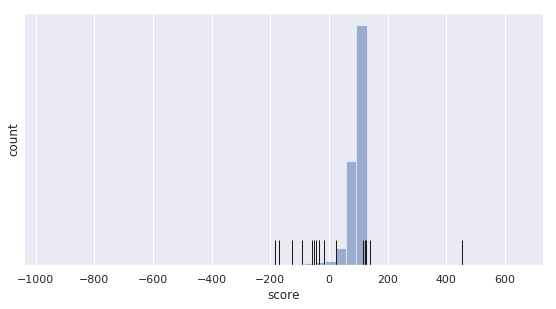

In [259]:
fig_size = 9.3
fig = plt.figure(figsize=(fig_size, float(fig_size)/2))


# ax_min = -0.15
ax_min = min(metcalf_raw_all_scores)
# ax_max = 0.35
ax_max = max(metcalf_raw_all_scores)

gs = gridspec.GridSpec(1, 1, hspace=0.05)

ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])


ax1.hist(metcalf_raw_all_scores, bins=50, range=[ax_min, ax_max], alpha=0.5)
ax1.plot(metcalf_raw_verified_scores, [0]*len(metcalf_raw_verified_scores), '|', color='k', markersize=50)

ax1.set_xlim([ax_min, ax_max])
#ax2.set_xlim([ax_min, ax_max])
#ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_ylabel('count')
ax1.set_xlabel('score')

plt.tight_layout()

plt.savefig('20200511_graph_metcalf_raw_crusemann.pdf')


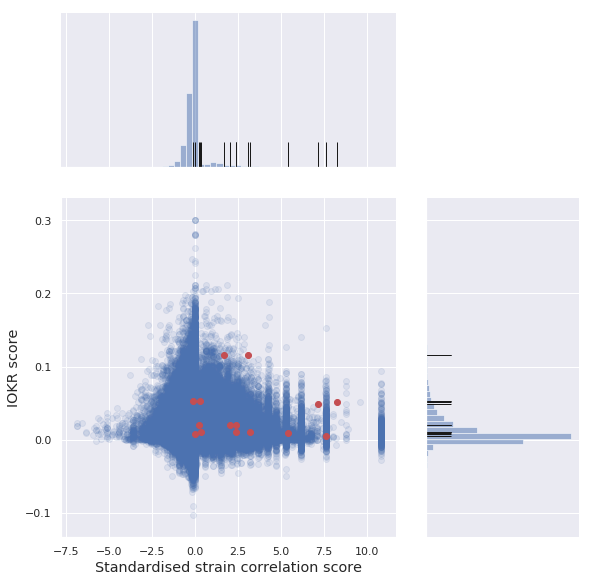

In [270]:


plot = sns.jointplot([x[0] for x in all_score_pairs if x[1] != -100], [x[1] for x in all_score_pairs if x[1] != -100], alpha=0.1, ratio=2, height=8, marginal_kws={'hist_kws': {'alpha': 0.5}})
plot.ax_joint.plot([x[0] for x in verified_score_pairs if x[1] != -100], [x[1] for x in verified_score_pairs if x[1] != -100], 'ro', color='r')
# bc horizontal, flip x and y axis
plot.ax_marg_y.plot([0]*len(iokr_scores_valid), iokr_scores_valid, '|', color='k', marker=(2, 0, 90), markersize=50)
plot.ax_marg_x.plot(metcalf_scores_valid, [0]*len(metcalf_scores_valid), '|', color='k', markersize=50)


plot.set_axis_labels('Standardised strain correlation score', 'IOKR score', size='large')

filename = '20200514_graph_combined_data_iokr_metcalf'


data = (all_score_pairs, verified_score_pairs)

with open(filename + '.bin', 'wb') as f:
    pickle.dump(data, f)

plot.savefig(filename + '.png', dpi=1200)


In [263]:
import matplotlib.gridspec as gridspec


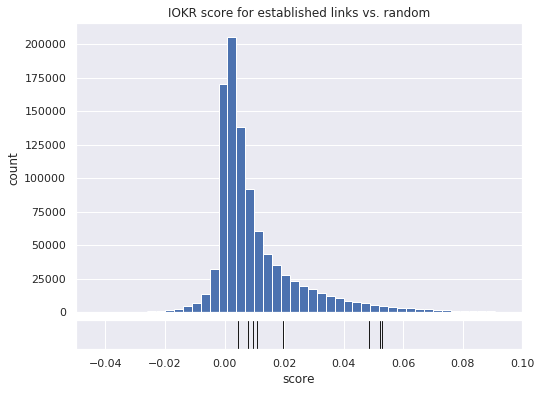

In [140]:
fig = plt.figure(figsize=(8, 6))

filename = '20200402_graph_iokr_paired_data_crusemann'

# ax_min = -0.15
ax_min = -0.05
# ax_max = 0.35
ax_max = 0.1

gs = gridspec.GridSpec(2, 1, height_ratios=[20, 2], hspace=0.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title('IOKR score for established links vs. random')

ax1.hist(iokr_scores_all, bins=50, range=[ax_min, ax_max])

ax2.plot(iokr_scores_valid, [5000]*len(iokr_scores_valid), '|', color='k', markersize=50)
ax1.set_xlim([ax_min, ax_max])
ax2.set_xlim([ax_min, ax_max])
ax1.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel('count')
ax2.set_xlabel('score')

plt.tight_layout()

data = (iokr_scores_all, iokr_scores_valid)
with open(filename + '.bin', 'wb') as f:
    pickle.dump(data, f)

plt.savefig('20200402_graph_iokr_paired_data_crusemann.png')

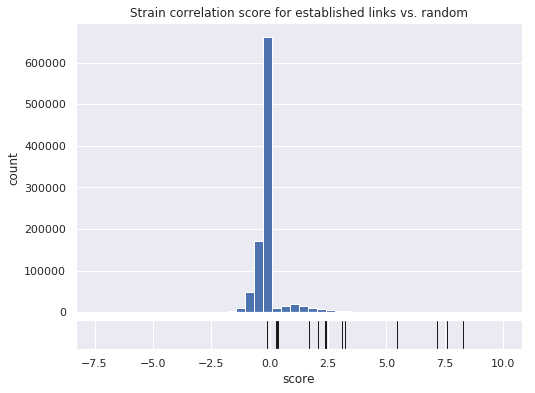

In [104]:
fig = plt.figure(figsize=(8, 6))


# ax_min = -0.15
ax_min = min(metcalf_all_scores)
# ax_max = 0.35
ax_max = max(metcalf_all_scores)

gs = gridspec.GridSpec(2, 1, height_ratios=[20, 2], hspace=0.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title('Strain correlation score for established links vs. random')

ax1.hist(metcalf_scores_all, bins=50, range=[ax_min, ax_max])

ax2.plot(metcalf_scores_valid, [5000]*len(metcalf_scores_valid), '|', color='k', markersize=50)
ax1.set_xlim([ax_min, ax_max])
ax2.set_xlim([ax_min, ax_max])
ax1.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel('count')
ax2.set_xlabel('score')

plt.tight_layout()

plt.savefig('graph_metcalf_paired_data_crusemann.png')

In [201]:
print("Valid links: {}".format(len(metcalf_scores_valid)))
print("Links > 0: {}".format(len([x for x in metcalf_scores_valid if x > 0])))

Valid links: 15
Links > 0: 13


In [ ]:
# This is a duplicate!

In [155]:
metcalf_raw_all_scores = []
metcalf_raw_verified_scores = []

for i, gcf in enumerate(npl.gcfs):
    print("{} / {}".format(i, len(npl.gcfs)))
    
    for mf in npl.molfams:
        metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)
        
        metcalf_raw_all_scores.append(metcalf_score)
        for link_bgc, link_mf in verified_bgc_mf_links:
            if link_bgc in gcf.bgcs and link_mf == mf:
                print('add verified')
                metcalf_raw_verified_scores.append(metcalf_score)


0 / 454
1 / 454
2 / 454
3 / 454
4 / 454
5 / 454
6 / 454
7 / 454
8 / 454
9 / 454
10 / 454
11 / 454
12 / 454
13 / 454
14 / 454
15 / 454
16 / 454
17 / 454
18 / 454
19 / 454
20 / 454
21 / 454
22 / 454
23 / 454
24 / 454
25 / 454
26 / 454
27 / 454
28 / 454
29 / 454
30 / 454
31 / 454
32 / 454
33 / 454
34 / 454
35 / 454
36 / 454
37 / 454
38 / 454
39 / 454
40 / 454
41 / 454
42 / 454
43 / 454
44 / 454
45 / 454
46 / 454
47 / 454
48 / 454
add verified
add verified
49 / 454
50 / 454
51 / 454
52 / 454
53 / 454
54 / 454
55 / 454
56 / 454
57 / 454
58 / 454
59 / 454
60 / 454
61 / 454
62 / 454
63 / 454
64 / 454
65 / 454
66 / 454
67 / 454
68 / 454
69 / 454
70 / 454
71 / 454
add verified
add verified
72 / 454
73 / 454
74 / 454
75 / 454
76 / 454
77 / 454
78 / 454
79 / 454
80 / 454
81 / 454
82 / 454
83 / 454
84 / 454
85 / 454
86 / 454
87 / 454
88 / 454
89 / 454
90 / 454
91 / 454
92 / 454
93 / 454
94 / 454
95 / 454
96 / 454
97 / 454
98 / 454
99 / 454
100 / 454
101 / 454
102 / 454
103 / 454
104 / 454
105 / 45

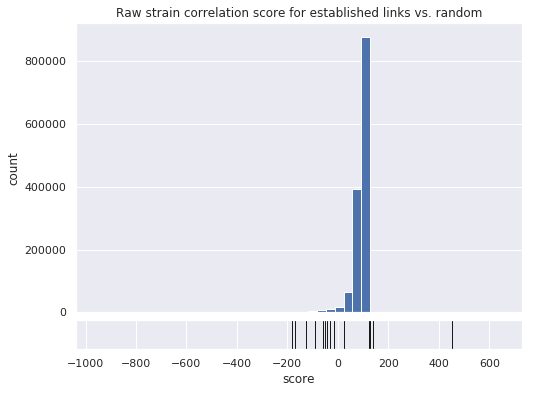

In [103]:
fig = plt.figure(figsize=(8, 6))


# ax_min = -0.15
ax_min = min(metcalf_raw_all_scores)
# ax_max = 0.35
ax_max = max(metcalf_raw_all_scores)

gs = gridspec.GridSpec(2, 1, height_ratios=[20, 2], hspace=0.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title('Raw strain correlation score for established links vs. random')

ax1.hist(metcalf_raw_all_scores, bins=50, range=[ax_min, ax_max])

ax2.plot(metcalf_raw_verified_scores, [5000]*len(metcalf_raw_verified_scores), '|', color='k', markersize=50)
ax1.set_xlim([ax_min, ax_max])
ax2.set_xlim([ax_min, ax_max])
ax1.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel('count')
ax2.set_xlabel('score')

plt.tight_layout()

plt.savefig('graph_metcalf_raw_paired_data_crusemann.png')

In [160]:
metcalf_raw_scores_all = [x for x, y in zip(metcalf_raw_all_scores, all_score_pairs) if y[1] != -100]
metcalf_raw_scores_valid = [x for x, y in zip(metcalf_raw_verified_scores, verified_score_pairs) if y[1] != -100]
print('Mean Metcalf all: {}'.format(numpy.mean(metcalf_raw_scores_all)))
print('Mean Metcalf valid: {}'.format(numpy.mean(metcalf_raw_scores_valid)))
print('Metcalf difference in means p-value: {}'.format(scipy.stats.ttest_ind(metcalf_raw_scores_all, metcalf_raw_scores_valid)))

Mean Metcalf all: 84.19524256475631
Mean Metcalf valid: 14.0
Metcalf difference in means p-value: Ttest_indResult(statistic=3.9408053673283527, pvalue=8.121401609179454e-05)


In [ ]:
# cache results...

In [152]:
with open('20200402_crusemann_metcalf_iokr_verified.bin', 'wb') as f:
    pickle.dump((iokr_scores_all, 
                 iokr_scores_valid, 
                 metcalf_scores_all, 
                 metcalf_scores_valid, 
                 metcalf_raw_scores_all, 
                 metcalf_raw_scores_valid,
                 all_score_pairs,
                 verified_score_pairs), f)

In [ ]:
# Plot standardised vs. raw correlation score

/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


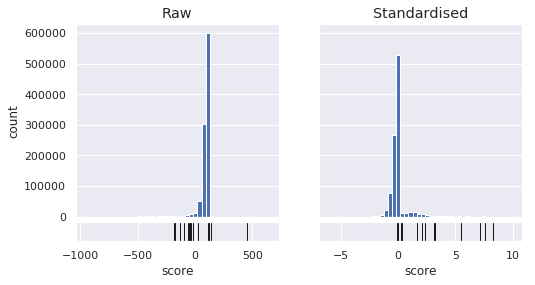

In [269]:
fig = plt.figure(figsize=(8, 4))

filename = '20200514_raw_vs_standardised_correlation_score_crusemann'

metcalf_raw_all_scores = metcalf_raw_scores_all

# ax_min = -0.15
raw_ax_min = min(metcalf_raw_all_scores)
# ax_max = 0.35
raw_ax_max = max(metcalf_raw_all_scores)

gs = gridspec.GridSpec(2, 2, height_ratios=[20, 2], hspace=0.05)
raw_hist = plt.subplot(gs[0])
raw_ticks = plt.subplot(gs[2])

raw_hist.set_title('Raw', size='large')

raw_hist.hist(metcalf_raw_scores_all, bins=50, range=[raw_ax_min, raw_ax_max])

raw_ticks.plot(metcalf_raw_scores_valid, [5000]*len(metcalf_raw_scores_valid), '|', color='k', markersize=50)
raw_hist.set_xlim([raw_ax_min, raw_ax_max])
raw_ticks.set_xlim([raw_ax_min, raw_ax_max])
raw_hist.set_xticks([])
raw_ticks.set_yticks([])

raw_hist.set_ylabel('count')
raw_ticks.set_xlabel('score')

# raw_hist.yaxis.tick_left()


# ax_min = -0.15
std_ax_min = min(metcalf_scores_all)
# ax_max = 0.35
std_ax_max = max(metcalf_scores_all)


std_hist = plt.subplot(gs[1])
std_ticks = plt.subplot(gs[3])

std_hist.set_title('Standardised', size='large')

std_hist.hist(metcalf_scores_all, bins=50, range=[std_ax_min, std_ax_max])

std_ticks.plot(metcalf_scores_valid, [5000]*len(metcalf_scores_valid), '|', color='k', markersize=50)
std_hist.set_xlim([std_ax_min, std_ax_max])
std_ticks.set_xlim([std_ax_min, std_ax_max])
std_hist.set_xticks([])
std_ticks.set_yticks([])

#ax1.set_yticks([])
#std_hist.yaxis.tick_right()
std_hist.set_yticklabels([])

# ax1.set_ylabel('count')
std_ticks.set_xlabel('score', size='medium')

hist_max = max(std_hist.get_ylim()[1], raw_hist.get_ylim()[1])
std_hist.set_ylim(top=hist_max)
raw_hist.set_ylim(top=hist_max)


plt.tight_layout()

#data = (metcalf_raw_all_scores, metcalf_raw_verified_scores, metcalf_scores_all, metcalf_scores_valid)
#with open(filename + '.bin', 'wb') as f:
#    pickle.dump(data, f)

plt.savefig(filename + '.pdf')

In [ ]:
# Scores starting from a given BGC

In [57]:
scores_from_bgc = []
scores_from_bgc_idlist = []

# scores_from_bgc has order (IOKR, std.corr., raw corr)

for (valid_bgc, valid_mf), mibig_id in zip(verified_bgc_mf_links, verified_bgc_mf_links_labels):
    for gcf in npl.gcfs:
        if valid_bgc in gcf.bgcs:
            iokr_score_list = []
            metcalf_score_list = []
            raw_metcalf_score_list = []
            for mf in npl.molfams:
                iokr_score = get_iokr_score(mf, gcf)
                iokr_score_list.append(iokr_score)
                raw_metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)
                raw_metcalf_score_list.append(raw_metcalf_score)
                metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
                metcalf_score_list.append(metcalf_score)
                if mf == valid_mf:
                    valid_iokr_score = iokr_score
                    valid_metcalf_score = metcalf_score
                    valid_raw_metcalf_score = raw_metcalf_score
            scores_from_bgc.append((
                (iokr_score_list, valid_iokr_score),
                (metcalf_score_list, valid_metcalf_score),
                (raw_metcalf_score_list, valid_raw_metcalf_score)
            ))
                
            scores_from_bgc_idlist.append((gcf, valid_bgc, mibig_id))

In [ ]:
# Plot scores for a selection of BGCs

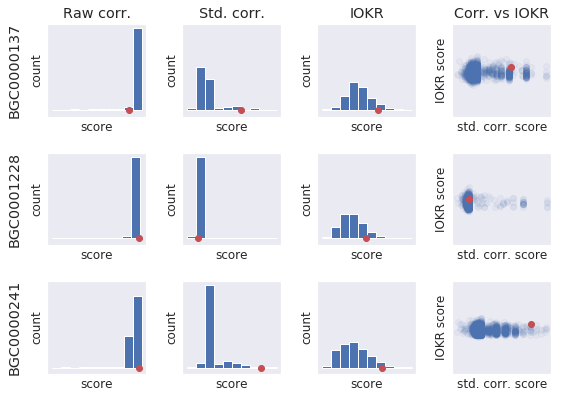

In [258]:
sample_plot_indices = [9, 11, 14]

w = 8
h = (32.0 / 15 * 3) / 9 * 8

filename = '20200820_bgc_scores_crusemann'

fig, axes = plt.subplots(nrows=len(sample_plot_indices), ncols=4, figsize=(w, h))

#cols = ['IOKR', 'Standardised strain correlation', 'Raw strain correlation']
cols = ['Raw corr.', 'Std. corr.', 'IOKR', 'Corr. vs IOKR']
for ax, col in zip(axes[0], cols):
    ax.set_title(col, size='large')

pad = 5

for row_idx, sample_idx in enumerate(sample_plot_indices):
    gcf, bgc, mibig = scores_from_bgc_idlist[sample_idx]
    
    #axes[row_idx, 0].set_ylabel(mibig)
    ax = axes[row_idx, 0]
    n = ax.annotate(mibig, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0), 
                xycoords=ax.yaxis.label, textcoords='offset points', 
                size='large', ha='right', va='center')
    
    n.set_rotation(90)
    
    initial_bgc = scores_from_bgc[sample_idx]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]
    ax = axes[row_idx, 3]
    ax.scatter(score_set_metcalf, score_set_iokr, alpha=0.05)
    ax.scatter([actual_score_metcalf], [actual_score_iokr], color='r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('IOKR score', size='medium')
    ax.set_xlabel('std. corr. score', size='medium')
    
    max_ylim = 0
    min_ylim = 0
    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        # invert col. order
        col_idx = 2 - col_idx
        ax = axes[row_idx, col_idx]
        ax.hist(score_set)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('score', size='medium')
        ax.set_ylabel('count', size='medium')
        ax.scatter([actual_score], [0], zorder=4, color='r')
        min_ylim = ax.get_ylim()[0]
        max_ylim = max(max_ylim, ax.get_ylim()[1])

    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        ax = axes[row_idx, col_idx]
        ax.set_ylim(min_ylim, max_ylim)



fig.tight_layout()

data = (sample_plot_indices, scores_from_bgc_idlist, scores_from_bgc)
with open(filename + '.data', 'wb') as f:
    pickle.dump(data, f)

plt.savefig(filename + '_top.png', dpi=1200)

In [ ]:
# How many links score higher than the verified link?

In [169]:
# 11: retimycin, 14: lomaiviticin
sample_idx = 14
gcf, bgc, mibig = scores_from_bgc_idlist[sample_idx]
initial_bgc = scores_from_bgc[sample_idx]
score_set_metcalf_raw, actual_score_metcalf_raw = initial_bgc[2]
score_set_metcalf, actual_score_metcalf = initial_bgc[1]
score_set_iokr, actual_score_iokr = initial_bgc[0]

print('lomaiviticin A, BGC0000241')
print('total number of links', len(score_set_metcalf_raw))
print('Number of links with equal or higher raw corr. score:', len([x for x in score_set_metcalf_raw if x >= actual_score_metcalf_raw]))
print('Number of links with equal or higher raw corr. and IOKR scores:', len([x for x, y in zip(score_set_iokr, score_set_metcalf_raw) if y >= actual_score_metcalf_raw and x >= actual_score_iokr]))
print('Number of links with equal or higher correlation score:', len([x for x in score_set_metcalf if x >= actual_score_metcalf]))
print('Number of links with equal or higher corr. and IOKR scores:', len([x for x, y in zip(score_set_iokr, score_set_metcalf) if y >= actual_score_metcalf and x >= actual_score_iokr]))
print('Number of links with equal or higher IOKR score:', len([x for x in score_set_iokr if x >= actual_score_iokr]))

iokr_mean = numpy.mean(iokr_scores_all)
iokr_std = numpy.std(iokr_scores_all)
score_set_iokr_std = (score_set_iokr - iokr_mean) / iokr_std
actual_score_iokr_std = (actual_score_iokr - iokr_mean) / iokr_std
sum_scores = [numpy.sign(x) * numpy.sqrt(numpy.abs(x)) + numpy.sign(y) * numpy.sqrt(numpy.abs(y)) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
sum_scores.sort(reverse=True)
sum_scores.index(
    numpy.sign(actual_score_iokr_std) * numpy.sqrt(numpy.abs(actual_score_iokr_std)) + 
    numpy.sign(actual_score_metcalf) * numpy.sqrt(numpy.abs(actual_score_metcalf))
)

lomaiviticin A, BGC0000241
total number of links 3094
Number of links with equal or higher raw corr. score: 22
Number of links with equal or higher raw corr. and IOKR scores: 1
Number of links with equal or higher correlation score: 16
Number of links with equal or higher corr. and IOKR scores: 1
Number of links with equal or higher IOKR score: 119


4

In [167]:
# 11: retimycin, 14: lomaiviticin
sample_idx = 11
gcf, bgc, mibig = scores_from_bgc_idlist[sample_idx]
initial_bgc = scores_from_bgc[sample_idx]
score_set_metcalf_raw, actual_score_metcalf_raw = initial_bgc[2]
score_set_metcalf, actual_score_metcalf = initial_bgc[1]
score_set_iokr, actual_score_iokr = initial_bgc[0]

print('retimycin A, BGC0001228')
print('total number of links', len(score_set_metcalf_raw))
print('Number of links with equal or higher raw corr. score:', len([x for x in score_set_metcalf_raw if x >= actual_score_metcalf_raw]))
print('Number of links with equal or higher raw corr. and IOKR scores:', len([x for x, y in zip(score_set_iokr, score_set_metcalf_raw) if y >= actual_score_metcalf_raw and x >= actual_score_iokr]))
print('Number of links with equal or higher correlation score:', len([x for x in score_set_metcalf if x >= actual_score_metcalf]))
print('Number of links with equal or higher corr. and IOKR scores:', len([x for x, y in zip(score_set_iokr, score_set_metcalf) if y >= actual_score_metcalf and x >= actual_score_iokr]))
print('Number of links with equal or higher IOKR score:', len([x for x in score_set_iokr if x >= actual_score_iokr]))

iokr_mean = numpy.mean(iokr_scores_all)
iokr_std = numpy.std(iokr_scores_all)
score_set_iokr_std = (score_set_iokr - iokr_mean) / iokr_std
actual_score_iokr_std = (actual_score_iokr - iokr_mean) / iokr_std
sum_scores = [numpy.sign(x) * numpy.sqrt(numpy.abs(x)) + numpy.sign(y) * numpy.sqrt(numpy.abs(y)) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
sum_scores.sort(reverse=True)
sum_scores.index(
    numpy.sign(actual_score_iokr_std) * numpy.sqrt(numpy.abs(actual_score_iokr_std)) + 
    numpy.sign(actual_score_metcalf) * numpy.sqrt(numpy.abs(actual_score_metcalf))
)

retimycin A, BGC0001228
total number of links 3094
Number of links with equal or higher raw corr. score: 1089
Number of links with equal or higher raw corr. and IOKR scores: 122
Number of links with equal or higher correlation score: 1152
Number of links with equal or higher corr. and IOKR scores: 141
Number of links with equal or higher IOKR score: 384


252

In [ ]:
# Rank of the verified link according to the scoring functions, and l_p combinations

In [230]:
def l_p(x, y, p):
    return numpy.sign(x) * numpy.power(numpy.abs(x), p) + numpy.sign(y) * numpy.power(numpy.abs(y), p)

l_p(1, 2, 0.5)

2.414213562373095

In [250]:
# 11: retimycin, 14: lomaiviticin
results = []
for sample_idx in range(len(scores_from_bgc_idlist)):
    gcf, bgc, mibig = scores_from_bgc_idlist[sample_idx]
    initial_bgc = scores_from_bgc[sample_idx]
    score_set_metcalf_raw, actual_score_metcalf_raw = initial_bgc[2]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]

    # print('retimycin A, BGC0001228')
    total = len(score_set_metcalf_raw)
    higher_corr_raw = len([x for x in score_set_metcalf_raw if x >= actual_score_metcalf_raw])
    higher_both_raw = len([x for x, y in zip(score_set_iokr, score_set_metcalf_raw) if y >= actual_score_metcalf_raw and x >= actual_score_iokr])
    higher_corr = len([x for x in score_set_metcalf if x >= actual_score_metcalf])
    higher_both = len([x for x, y in zip(score_set_iokr, score_set_metcalf) if y >= actual_score_metcalf and x >= actual_score_iokr])
    higher_iokr = len([x for x in score_set_iokr if x >= actual_score_iokr])


    iokr_mean = numpy.mean(iokr_scores_all)
    iokr_std = numpy.std(iokr_scores_all)
    score_set_iokr_std = (score_set_iokr - iokr_mean) / iokr_std
    actual_score_iokr_std = (actual_score_iokr - iokr_mean) / iokr_std
    
    sum_scores = [l_p(x, y, 0.5) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
    sum_scores.sort(reverse=True)
    rank_index_12 = len([x for x in sum_scores if x >= l_p(actual_score_iokr_std, actual_score_metcalf, 0.5)])
    
    sum_scores = [l_p(x, y, 2) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
    sum_scores.sort(reverse=True)
    rank_index_2 = len([x for x in sum_scores if x >= l_p(actual_score_iokr_std, actual_score_metcalf, 2)])
    
    sum_scores = [l_p(x, y, 1) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
    sum_scores.sort(reverse=True)
    rank_index_1 = len([x for x in sum_scores if x >= l_p(actual_score_iokr_std, actual_score_metcalf, 1)])

    results.append((mibig, higher_iokr, higher_corr, rank_index_12, rank_index_1, rank_index_2, higher_both))

In [251]:
for r in results:
    print(r)

('BGC0000137', 80, 16, 2, 14, 49, 1)
('BGC0000137', 78, 189, 12, 29, 66, 3)
('BGC0000137', 798, 1968, 1232, 997, 920, 534)
('BGC0000137', 636, 612, 409, 642, 735, 120)
('BGC0000137', 6, 287, 36, 214, 261, 1)
('BGC0000137', 6, 126, 14, 105, 122, 1)
('BGC0000137', 6, 216, 4, 85, 203, 1)
('BGC0000137', 184, 282, 146, 271, 285, 17)
('BGC0000137', 184, 101, 28, 92, 99, 7)
('BGC0000137', 184, 90, 19, 89, 88, 7)
('BGC0000333', 1810, 25, 32, 12, 12, 12)
('BGC0001228', 384, 1152, 253, 271, 317, 141)
('BGC0000827', 6, 1, 2, 1, 1, 1)
('BGC0001830', 673, 7, 7, 9, 24, 4)
('BGC0000241', 119, 16, 5, 12, 14, 1)


In [ ]:
# Plot of the unit circle in the l_p "norms"

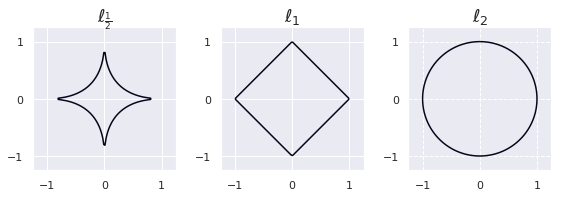

In [257]:
x = numpy.linspace(-1.0, 1.0, 100)
y = numpy.linspace(-1.0, 1.0, 100)

fig, axes = plt.subplots(ncols=3, figsize=(8, 4))

X0, Y0 = numpy.meshgrid(x, y)
F0 = numpy.sqrt(numpy.abs(X0)) + numpy.sqrt(numpy.abs(Y0)) - 1.0

X1, Y1 = numpy.meshgrid(x, y)
F1 = numpy.abs(X1) + numpy.abs(Y1) - 1.0

X2, Y2 = numpy.meshgrid(x,y)
F2 = X2**2 + Y2**2 - 1.0

eqn_list = (
    ('$\ell_\\frac{1}{2}$', F0),
    ('$\ell_1$', F1),
    ('$\ell_2$', F2)
)

for ax, eqn_pair in zip(axes, eqn_list):
    eqn_title, eqn = eqn_pair

    ax.set_title(eqn_title, size=18)
    
    ax.contour(X,Y,eqn,[0])

    ax.set_aspect(1)

    ax.set_xlim(-1.25,1.25)
    ax.set_ylim(-1.25,1.25)
    
    ax.set_yticks([-1, 0, 1])

    plt.grid(linestyle='--')
    
plt.tight_layout()

plt.savefig('fig_norms.pdf')

In [ ]:
# Plots for all of the BGCs that are part of established links

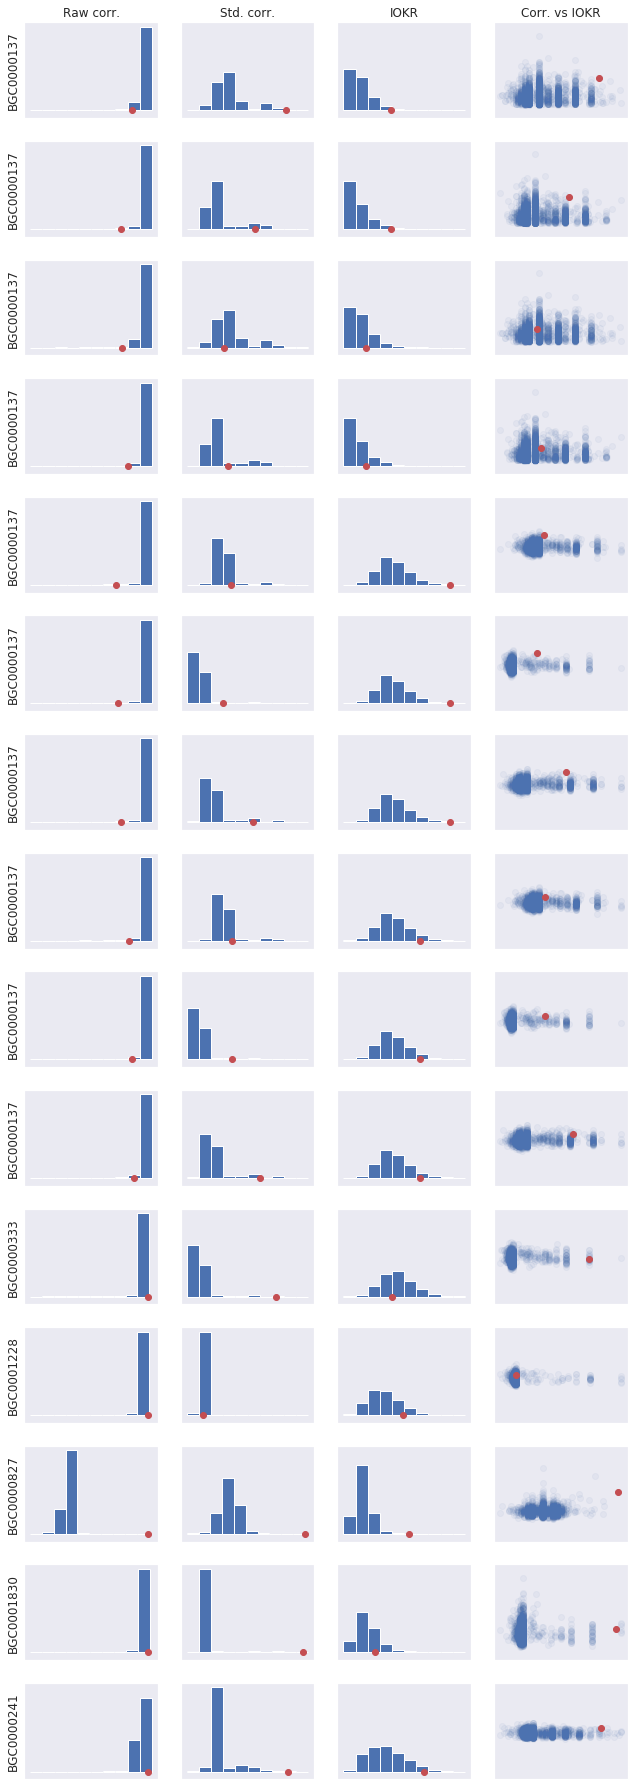

In [197]:
fig, axes = plt.subplots(nrows=15, ncols=4, figsize=(9, 25))

filename = '20200420_bgc_scores_crusemann'

#cols = ['IOKR', 'Standardised strain correlation', 'Raw strain correlation']
cols = ['Raw corr.', 'Std. corr.', 'IOKR', 'Corr. vs IOKR']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for row_idx in range(len(scores_from_bgc)):
    gcf, bgc, mibig = scores_from_bgc_idlist[row_idx]
    axes[row_idx, 0].set_ylabel(mibig)


    initial_bgc = scores_from_bgc[row_idx]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]
    ax = axes[row_idx, 3]
    ax.scatter(score_set_metcalf, score_set_iokr, alpha=0.05)
    ax.scatter([actual_score_metcalf], [actual_score_iokr], color='r')
    ax.set_xticks([])
    ax.set_yticks([])
    
    max_ylim = 0
    min_ylim = 0
    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        # invert col. order
        col_idx = 2 - col_idx
        ax = axes[row_idx, col_idx]
        ax.hist(score_set)
        ax.scatter([actual_score], [0], zorder=3, color='r')
        ax.set_xticks([])
        ax.set_yticks([])
        min_ylim = ax.get_ylim()[0]
        max_ylim = max(max_ylim, ax.get_ylim()[1])

    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        ax = axes[row_idx, col_idx]
        ax.set_ylim(min_ylim, max_ylim)

fig.tight_layout()

plt.savefig(filename + '_all.png')

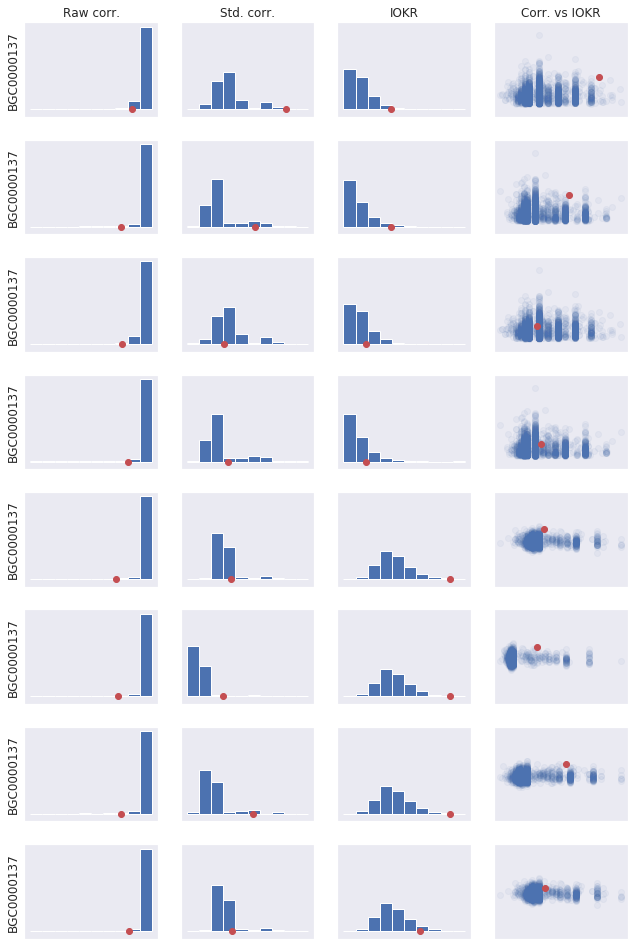

In [284]:
# 15 in total -- 8 + 7
# first part
nrows = 8
figheight = 25 / 15 * nrows
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(9, figheight))

filename = '20200518_bgc_scores_crusemann_part1'

#cols = ['IOKR', 'Standardised strain correlation', 'Raw strain correlation']
cols = ['Raw corr.', 'Std. corr.', 'IOKR', 'Corr. vs IOKR']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

#for row_idx in range(len(scores_from_bgc)):
for row_idx in range(8):
    gcf, bgc, mibig = scores_from_bgc_idlist[row_idx]
    axes[row_idx, 0].set_ylabel(mibig)


    initial_bgc = scores_from_bgc[row_idx]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]
    ax = axes[row_idx, 3]
    ax.scatter(score_set_metcalf, score_set_iokr, alpha=0.05)
    ax.scatter([actual_score_metcalf], [actual_score_iokr], color='r')
    ax.set_xticks([])
    ax.set_yticks([])
    
    max_ylim = 0
    min_ylim = 0
    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        # invert col. order
        col_idx = 2 - col_idx
        ax = axes[row_idx, col_idx]
        ax.hist(score_set)
        ax.scatter([actual_score], [0], zorder=3, color='r')
        ax.set_xticks([])
        ax.set_yticks([])
        min_ylim = ax.get_ylim()[0]
        max_ylim = max(max_ylim, ax.get_ylim()[1])

    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        ax = axes[row_idx, col_idx]
        ax.set_ylim(min_ylim, max_ylim)

fig.tight_layout()

plt.savefig(filename + '_all.png')

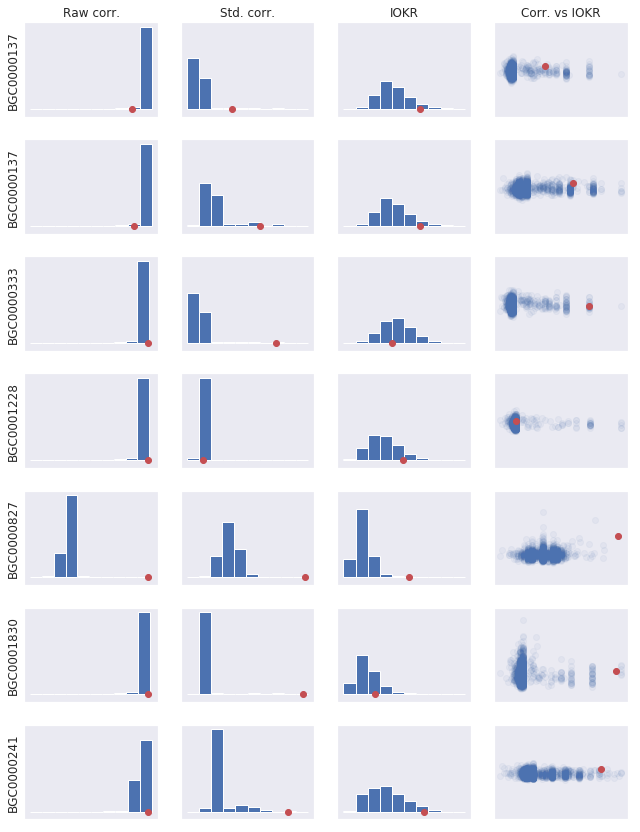

In [288]:
# second part
row_offset = 8
nrows = 7
figheight = 25 / 15 * nrows
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(9, figheight))

filename = '20200518_bgc_scores_crusemann_part2'

#cols = ['IOKR', 'Standardised strain correlation', 'Raw strain correlation']
cols = ['Raw corr.', 'Std. corr.', 'IOKR', 'Corr. vs IOKR']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

#for row_idx in range(len(scores_from_bgc)):
graph_row_idx = 0
for row_idx in range(8, 15):
    gcf, bgc, mibig = scores_from_bgc_idlist[row_idx]
    axes[graph_row_idx, 0].set_ylabel(mibig)

    initial_bgc = scores_from_bgc[row_idx]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]
    ax = axes[graph_row_idx, 3]
    ax.scatter(score_set_metcalf, score_set_iokr, alpha=0.05)
    ax.scatter([actual_score_metcalf], [actual_score_iokr], color='r')
    ax.set_xticks([])
    ax.set_yticks([])
    
    max_ylim = 0
    min_ylim = 0
    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        # invert col. order
        col_idx = 2 - col_idx
        ax = axes[graph_row_idx, col_idx]
        ax.hist(score_set)
        ax.scatter([actual_score], [0], zorder=3, color='r')
        ax.set_xticks([])
        ax.set_yticks([])
        min_ylim = ax.get_ylim()[0]
        max_ylim = max(max_ylim, ax.get_ylim()[1])

    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        ax = axes[graph_row_idx, col_idx]
        ax.set_ylim(min_ylim, max_ylim)
        
    graph_row_idx += 1

fig.tight_layout()

plt.savefig(filename + '_all.png')